In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from pytrends.request import TrendReq

%matplotlib inline

In [2]:
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

#### Check TensorFlow

In [3]:
print(tf.__version__)

2.3.0


### Get VTI history

In [4]:
vti = yf.Ticker("VTI")
vti_hist = vti.history(period="max")

In [5]:
vti_close_hist = vti_hist.Close

In [6]:
# this is a good reminder of what day you pulled the history!!!!
vti_close_hist.tail()

Date
2020-08-12    171.16
2020-08-13    171.03
2020-08-14    170.98
2020-08-17    171.71
2020-08-18    171.97
Name: Close, dtype: float64

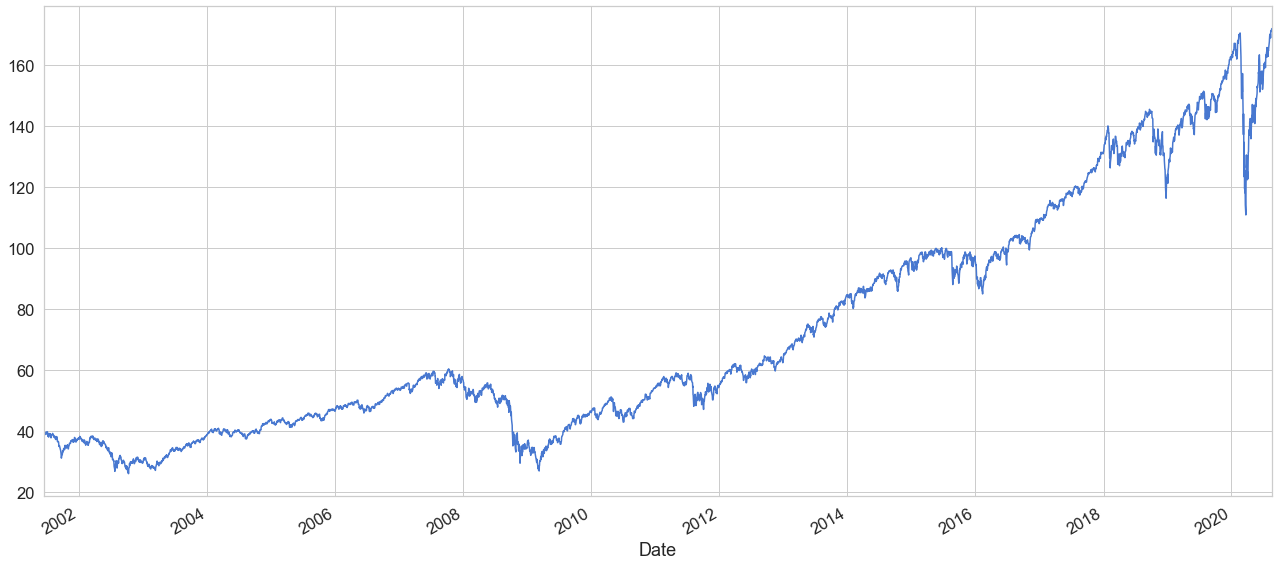

In [7]:
vti_close_hist.plot()

#### Get top 10 holding in VTI


##### * Top 10 holdings were NOT found programatically. This info has yet to be found in the vti object *

In [8]:
microsoft = yf.Ticker('MSFT').history(period="max")
apple = yf.Ticker('AAPL').history(period="max")
amazon = yf.Ticker('AMZN').history(period="max")
facebook = yf.Ticker('FB').history(period="max")
alphabetA = yf.Ticker('GOOGL').history(period="max")
alphabetC = yf.Ticker('GOOG').history(period="max")
johnson = yf.Ticker('JNJ').history(period="max")
berkshire = yf.Ticker('BRK-B').history(period="max")
visa = yf.Ticker('V').history(period="max")
proctor = yf.Ticker('PG').history(period="max")

In [9]:
# In cases of dividends being reported, during that day the day is listed twice causing a duplicate index.
# droping nan's should get rid of of the duplicate row
holdings = [microsoft, apple, amazon, facebook, alphabetA, alphabetC, johnson, berkshire, visa, proctor]
for holding in holdings:
    holding.dropna(inplace=True)

#### Get DOW

In [10]:
dow = yf.Ticker('DJIA').history(period="max")

#### Get Gooogle Trends data

In [11]:
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload(['vti'], timeframe='all')
trend_df = pytrends.interest_over_time()

#### Upsample Google trend data to daily

In [12]:
# upsample: every day in month will have the monthly average
g_trends_daily = trend_df.resample('D').ffill()

In [13]:
last_full_month_value = g_trends_daily.iloc[-2].vti

In [14]:
g_trends_daily.rename(columns={'vti': 'avg_searches', 'date': 'Date'}, inplace=True)

In [15]:
g_trends_daily.drop(columns='isPartial', inplace=True)

### Combine holdings into DF

In [16]:
df = pd.concat([vti_hist.Close.rename('vti'),
                 microsoft.Close.rename('msft'),
                 apple.Close.rename('appl'),
                 amazon.Close.rename('amzn'),
                 facebook.Close.rename('fb'),
                 alphabetA.Close.rename('google'),
                 alphabetC.Close.rename('googlb'),
                 johnson.Close.rename('jnj'),
                 berkshire.Close.rename('brk'),
                 visa.Close.rename('visa'),
                 proctor.Close.rename('pg'),
                 dow.Close.rename('dow')], join='outer', axis=1)


#### left join google trends (to accomodate for gtrends including weekends)

In [17]:
df = df.join(g_trends_daily['avg_searches'].rename('gtrnd'), how='left')

#### truncate to dates when vti is in existance

In [18]:
df = df.loc['2001-06-15':]

### Special Cleaning for Google Trends

In [19]:
# fill the month of august with the values from the last full month
df.gtrnd.iloc[-30::].fillna(last_full_month_value, inplace=True)

In [20]:
df.tail(10)

,vti,msft,appl,amzn,fb,google,googlb,jnj,brk,visa,pg,dow,gtrnd
Date,,,,,,,,,,,,,
2020-08-05,168.84,212.94,439.46,3205.03,249.12,1479.09,1473.61,148.40,203.62,195.80,133.44,27201.52,55.0
2020-08-06,169.66,216.35,454.79,3225.00,265.28,1504.95,1500.10,147.55,205.02,198.47,132.71,27386.98,55.0
2020-08-07,169.80,212.48,444.45,3167.46,268.44,1498.37,1494.49,148.60,209.48,196.06,133.55,27433.48,55.0
2020-08-10,170.27,208.25,450.91,3148.16,263.00,1496.82,1496.10,148.03,212.58,196.49,134.10,27791.44,55.0
2020-08-11,168.90,203.38,437.50,3080.67,256.13,1480.54,1480.32,146.97,212.66,197.47,133.23,27686.91,55.0
2020-08-12,171.16,209.19,452.04,3162.24,259.89,1507.24,1506.62,149.66,213.24,198.44,135.46,27976.84,55.0
2020-08-13,171.03,208.70,460.04,3161.02,261.30,1516.65,1518.45,148.00,211.98,197.58,135.78,27896.72,55.0
2020-08-14,170.98,208.90,459.63,3148.02,261.24,1504.63,1507.73,148.24,210.96,196.64,135.10,27931.02,55.0
2020-08-17,171.71,210.28,458.43,3182.41,261.16,1516.24,1517.98,148.99,206.78,199.43,135.50,27844.91,55.0


In [21]:
df.gtrnd.fillna(df.gtrnd.mean(), inplace=True)

### Handle case when DOW's latest close in NaN

In [22]:
if np.isnan(df.iloc[-1].dow):
    df.iloc[-1].dow = dow.iloc[-1].Close

### For holdings that didn't exist yet, fill NAs with its minimum price

In [23]:
for col in df.columns:
    df[col].fillna(df[col].min(), inplace=True)

## Modeling

#### Train Test Split

In [24]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
# make a copy so you don't change the original when scaling. This method was easier than modifying it during the the assignment
df_copy = df.copy()
train, test = df_copy.iloc[0:train_size], df_copy.iloc[train_size:len(df)]
print(len(train), len(test))

4341 483


In [25]:
# select only feature columns
features = df.columns.drop('vti')

# scale all data
feature_transformer = MinMaxScaler()
vti_transformer = MinMaxScaler()

train[features] = feature_transformer.fit_transform(train[features].values)
train['vti'] = vti_transformer.fit_transform(train[['vti']])

test[features] = feature_transformer.transform(test[features].values)
test['vti'] = vti_transformer.transform(test[['vti']])

/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

In [26]:
train.head(1)

,vti,msft,appl,amzn,fb,google,googlb,jnj,brk,visa,pg,dow,gtrnd
Date,,,,,,,,,,,,,
2001-06-15,0.109372,0.10196,0.002028,0.003206,0.0,0.0,0.0,0.051885,0.021213,0.0,0.001883,0.203122,0.429638


In [27]:
#offsets the y values (target values) to be the time_step ammount infront of each row
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [28]:
time_steps = 1

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.vti, time_steps)
X_test, y_test = create_dataset(test, test.vti, time_steps)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4340, 1, 13) (4340,)
(482, 1, 13) (482,)


In [29]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')

In [30]:
history = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/20
123/123 [==============================] - 1s 6ms/step - loss: 7.6338e-04 - val_loss: 0.0105
Epoch 2/20
123/123 [==============================] - 0s 2ms/step - loss: 5.3263e-04 - val_loss: 0.0027
Epoch 3/20
123/123 [==============================] - 0s 2ms/step - loss: 5.1004e-04 - val_loss: 3.0593e-04
Epoch 4/20
123/123 [==============================] - 0s 2ms/step - loss: 4.5416e-04 - val_loss: 7.2868e-04
Epoch 5/20
123/123 [==============================] - 0s 2ms/step - loss: 4.2076e-04 - val_loss: 0.0065
Epoch 6/20
123/123 [==============================] - 0s 2ms/step - loss: 4.7135e-04 - val_loss: 4.0131e-04
Epoch 7/20
123/123 [==============================] - 0s 2ms/step - loss: 4.0804e-04 - val_loss: 0.0012
Epoch 8/20
123/123 [==============================] - 0s 2ms/step - loss: 4.3194e-04 - val_loss: 8.3621e-04
Epoch 9/20
123/123 [==============================] - 0s 2ms/step - loss: 3.8354e-04 - val_loss: 0.0125
Epoch 10/20
123/123 [===========================

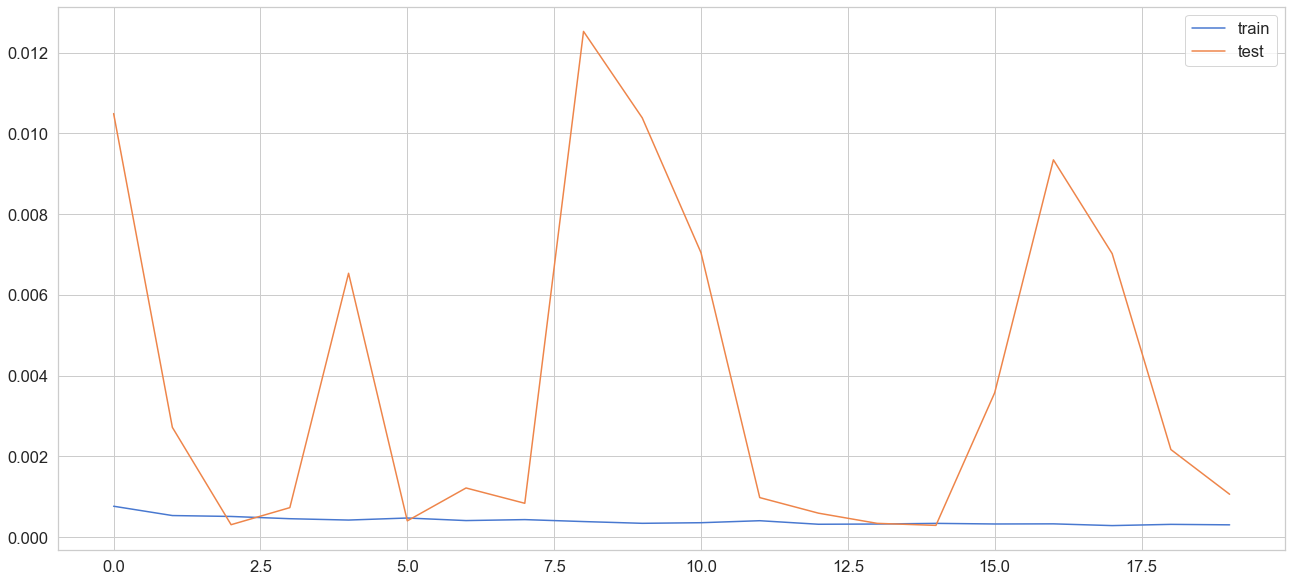

In [31]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [32]:
y_pred = model.predict(X_test)

In [33]:
y_train_inv = vti_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = vti_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = vti_transformer.inverse_transform(y_pred)

In [34]:
print("RMSE = ", np.sqrt(mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten())))
print("MAE = ", mean_absolute_error(y_test_inv.flatten(), y_pred_inv.flatten()))

RMSE =  4.710478513003809
MAE =  3.5429766535462193


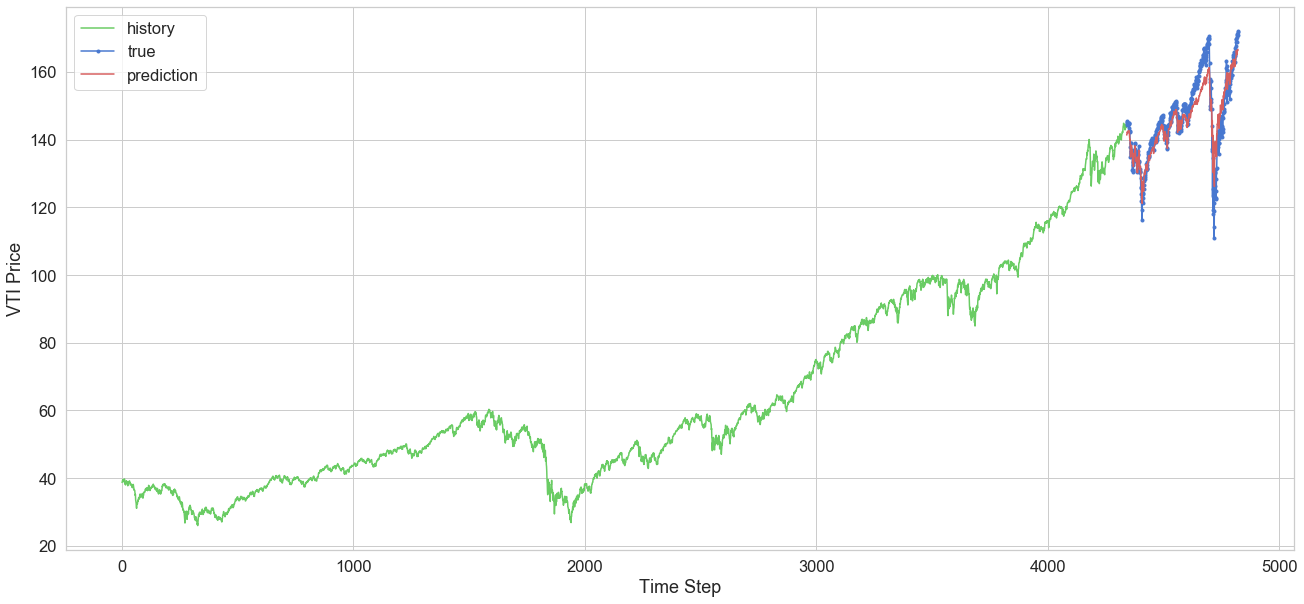

In [35]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('VTI Price')
plt.xlabel('Time Step')
plt.legend()
plt.savefig('images/hist_preds.png')
plt.show();

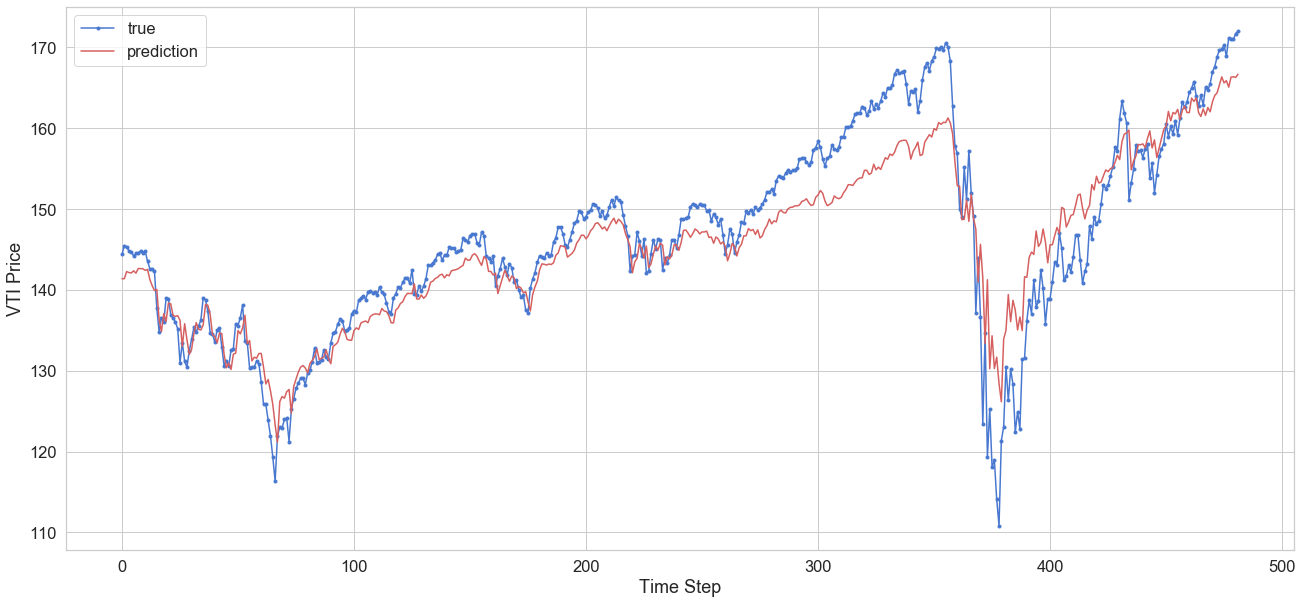

In [36]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('VTI Price')
plt.xlabel('Time Step')
plt.legend()
plt.savefig('images/lstm_preds_vs_true.png')
plt.show();


In [37]:
def get_buy_sell(prices):
    outcomes=[]
    for index, price in enumerate(prices[1:]):
        if price > prices[index] :
            outcomes.append(1)
        else:
            outcomes.append(0)
    return outcomes

In [38]:
y_test_outcomes = get_buy_sell(y_test_inv.flatten())

In [39]:
y_pred_outcomes = get_buy_sell(y_pred_inv.flatten())

In [40]:
confusion_matrix(y_test_outcomes, y_pred_outcomes)

array([[ 84, 127],
       [121, 149]])

In [65]:
def calc_returns(pred_outcomes, true_prices, investment):
    capital = investment
    in_market = False
    for index, price in enumerate(true_prices[:-1]):
        if pred_outcomes[index] == 1:
            if in_market == False:
                holdings = capital/price
                capital = 0
                in_market = True
        if pred_outcomes[index] == 0:
            if in_market:
                capital = holdings*price
                holdings = 0
                in_market = False
    return holdings*true_prices[-1] or capital

#### Returns if I had started my trading strategy from the start of the tset period

In [66]:
calc_returns(y_pred_outcomes, y_test_inv.flatten(), 1000)

867.2635633675895

#### Returns if I had bought at the beginning of the test period and just held

In [43]:
(1000/y_test_inv.flatten()[0])*y_test_inv.flatten()[-1]

1191.0929491619338

## Train model on full dataset

In [78]:
# select only feature columns
full_train = df.copy()

# scale all data
funct_full_transformer = MinMaxScaler()
vti_full_transformer = MinMaxScaler()

full_train[features] = funct_full_transformer.fit_transform(full_train[features])
full_train['vti'] = vti_full_transformer.fit_transform(full_train[['vti']])


In [79]:
full_test = full_train.iloc[int(len(df) * 0.9):]

In [80]:
time_steps = 1

# reshape to [samples, time_steps, n_features]
X_full_train, y_full_train = create_dataset(full_train, full_train.vti, time_steps)

print(X_full_train.shape, y_full_train.shape)

(4823, 1, 13) (4823,)


In [81]:
X_test_full, y_test_full = create_dataset(full_test, full_test.vti, time_steps=1)

In [48]:
full_model = keras.Sequential()
full_model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_full_train.shape[1], X_full_train.shape[2])
    )
  )
)
full_model.add(keras.layers.Dropout(rate=0.2))
full_model.add(keras.layers.Dense(units=1))
full_model.compile(loss='mean_squared_error', optimizer='adam')

In [49]:
full_history = full_model.fit(
    X_full_train, y_full_train, 
    epochs=18, 
    batch_size=32, 
    validation_split=0.2,
    shuffle=False
)

Epoch 1/18
121/121 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 2/18
121/121 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 8.9101e-04
Epoch 3/18
121/121 [==============================] - 0s 2ms/step - loss: 6.3204e-04 - val_loss: 9.1877e-04
Epoch 4/18
121/121 [==============================] - 0s 2ms/step - loss: 5.8008e-04 - val_loss: 8.6753e-04
Epoch 5/18
121/121 [==============================] - 0s 3ms/step - loss: 5.1342e-04 - val_loss: 6.9737e-04
Epoch 6/18
121/121 [==============================] - 0s 2ms/step - loss: 5.1495e-04 - val_loss: 7.6299e-04
Epoch 7/18
121/121 [==============================] - 0s 2ms/step - loss: 5.0408e-04 - val_loss: 6.7304e-04
Epoch 8/18
121/121 [==============================] - 0s 3ms/step - loss: 4.8645e-04 - val_loss: 8.7871e-04
Epoch 9/18
121/121 [==============================] - 0s 3ms/step - loss: 4.8391e-04 - val_loss: 7.0377e-04
Epoch 10/18
121/121 [===================

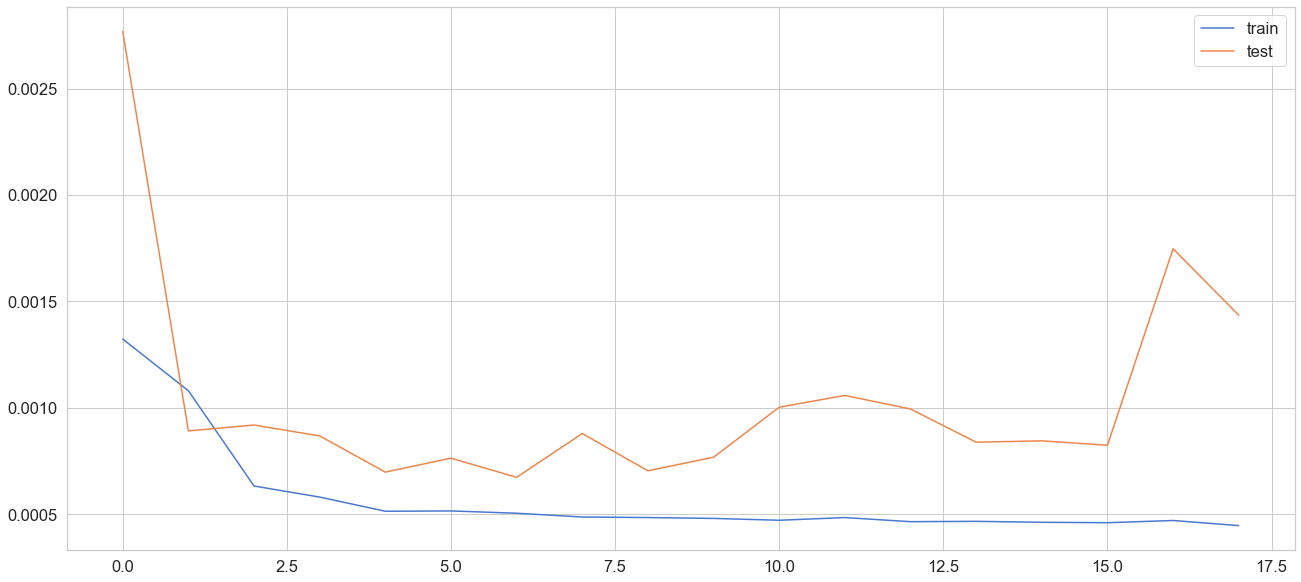

In [50]:
plt.plot(full_history.history['loss'], label='train')
plt.plot(full_history.history['val_loss'], label='test')
plt.legend();

### Make a prediction for tomorrow

In [51]:
tomorrow_pred = full_model.predict(full_train.iloc[-1].values.reshape(1, 1, -1))

In [52]:
# transform back to dollar value
vti_full_transformer.inverse_transform(tomorrow_pred)

array([[168.79115]], dtype=float32)

### Test on same period as before

In [53]:
y_full_pred = full_model.predict(X_test_full)

In [54]:
y_test_inv = vti_full_transformer.inverse_transform(np.array(y_test_full).reshape(1, -1))
y_full_pred_inv = vti_full_transformer.inverse_transform(y_full_pred)

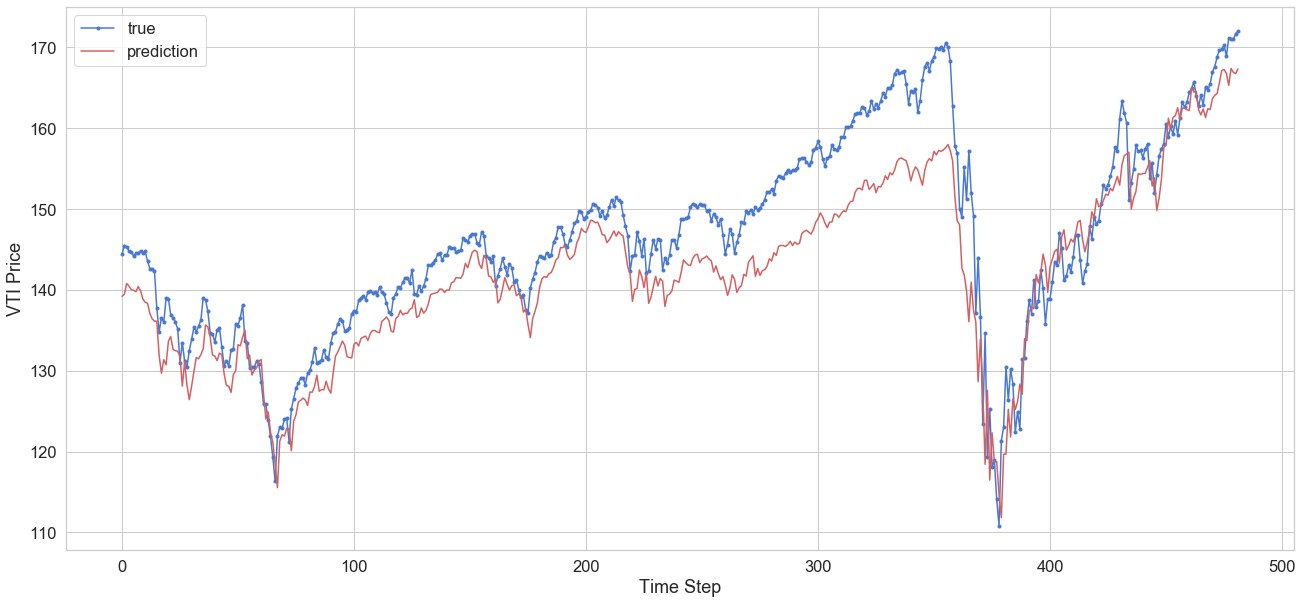

In [55]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_full_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('VTI Price')
plt.xlabel('Time Step')
plt.legend()
plt.savefig('images/lstm_preds_vs_true.png')
plt.show();

In [56]:
print("RMSE = ", np.sqrt(mean_squared_error(y_test_inv.flatten(), y_full_pred_inv.flatten())))
print("MAE = ", mean_absolute_error(y_test_inv.flatten(), y_full_pred_inv.flatten()))

RMSE =  5.793454171722307
MAE =  4.789240118636137


In [57]:
y_full_pred_outcomes = get_buy_sell(y_full_pred_inv.flatten())

In [58]:
confusion_matrix(y_test_outcomes, y_full_pred_outcomes)

array([[ 90, 121],
       [125, 145]])

#### Returns if I had started my trading strategy from the start of the tset period

In [59]:
calc_returns(y_full_pred_outcomes, y_test_inv.flatten(), 1000)

894.4047571394731

#### Returns if I had bought at the beginning of the test period and just held

In [60]:
(1000/y_test_inv.flatten()[0])*y_test_inv.flatten()[-1]

1191.0929491619338

### Get retroactive metrics from model that predicts 1 day in advance 

In [67]:
# train_length = int(len(df) * 0.9)
train_length = 365

In [103]:
upto_date_preds = []

In [104]:
# set i to the length you want to train on, because you'll use reverse indexing to work through them
i = len(df)-train_length
while i > 0:
#     make new copy of df
    long_train = df.copy()
#     split copy upto inverse of i
    loop_train = long_train.iloc[0:-i]
#     scale looped training set
    looped_transformer = MinMaxScaler()
    vti_looped_transformer = MinMaxScaler()
    loop_train[features] = looped_transformer.fit_transform(loop_train[features])
    loop_train['vti'] = vti_looped_transformer.fit_transform(loop_train[['vti']])
#     make training and target value dataset
    X_train_loop, y_train_loop = create_dataset(loop_train, loop_train.vti, 1)
#     setup a new model on the new loop_train dimensions
    loop_model = keras.Sequential()
    loop_model.add(
      keras.layers.Bidirectional(
        keras.layers.LSTM(
          units=128, 
          input_shape=(X_train_loop.shape[1], X_train_loop.shape[2])
        )
      )
    )
    loop_model.add(keras.layers.Dropout(rate=0.2))
    loop_model.add(keras.layers.Dense(units=1))
    loop_model.compile(loss='mean_squared_error', optimizer='adam')
#     train new model on the new loop_train data sets
    full_history = loop_model.fit(
        X_train_loop, y_train_loop, 
        epochs=6, 
        batch_size=32, 
        validation_split=0.2,
        shuffle=False
        )
#     make prediction for next day
    loop_tomorrow_pred = loop_model.predict(loop_train.iloc[-1].values.reshape(1, 1, -1))
#     invert scaling and append to results
    inv_loop_tomorrow_pred = vti_looped_transformer.inverse_transform(loop_tomorrow_pred)
    upto_date_preds.append(inv_loop_tomorrow_pred)
#     show progress while this runs
    print("prediction for ", loop_train.index[-1], " is: ", inv_loop_tomorrow_pred)
#     increment i
    i -= 1

/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3469: SettingWithCopyWarning: 
A value is trying to be set on 

Epoch 1/18
109/109 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 9.3888e-04
Epoch 2/18
109/109 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 4.8723e-04
Epoch 3/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 3.8209e-04
Epoch 4/18
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 7.4606e-04
Epoch 5/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 8.0635e-04
Epoch 6/18
109/109 [==============================] - 0s 2ms/step - loss: 9.3455e-04 - val_loss: 4.9306e-04
Epoch 7/18
109/109 [==============================] - 0s 2ms/step - loss: 8.5645e-04 - val_loss: 6.1507e-04
Epoch 8/18
109/109 [==============================] - 0s 2ms/step - loss: 7.9059e-04 - val_loss: 8.7729e-04
Epoch 9/18
109/109 [==============================] - 0s 2ms/step - loss: 7.4753e-04 - val_loss: 9.2078e-04
Epoch 10/18
109/109 [===========================

/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3469: SettingWithCopyWarning: 
A value is trying to be set on 

Epoch 1/18
109/109 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 2/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 9.9606e-04
Epoch 3/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 5.6552e-04
Epoch 4/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 5.5480e-04
Epoch 5/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 5.1640e-04
Epoch 6/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 6.2421e-04
Epoch 7/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 6.7414e-04
Epoch 8/18
109/109 [==============================] - 0s 2ms/step - loss: 9.2408e-04 - val_loss: 7.7537e-04
Epoch 9/18
109/109 [==============================] - 0s 2ms/step - loss: 8.3525e-04 - val_loss: 9.3538e-04
Epoch 10/18
109/109 [==============================] - 0s 2m

/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3469: SettingWithCopyWarning: 
A value is trying to be set on 

Epoch 1/18
109/109 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 5.8529e-04
Epoch 2/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 4.7368e-04
Epoch 3/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 8.5703e-04
Epoch 4/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 5.5714e-04
Epoch 5/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 6/18
109/109 [==============================] - 0s 2ms/step - loss: 9.1339e-04 - val_loss: 8.0137e-04
Epoch 7/18
109/109 [==============================] - 0s 3ms/step - loss: 7.7723e-04 - val_loss: 8.5686e-04
Epoch 8/18
109/109 [==============================] - 0s 3ms/step - loss: 7.6354e-04 - val_loss: 7.4328e-04
Epoch 9/18
109/109 [==============================] - 0s 3ms/step - loss: 7.2848e-04 - val_loss: 7.7519e-04
Epoch 10/18
109/109 [==============================]

W0819 09:47:26.773556 4724825536 def_function.py:120] 5 out of the last 21 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff452a82d90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

prediction for  2018-09-19 00:00:00  is:  [[138.65863]]
Epoch 1/18
109/109 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 2/18
109/109 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 4.1816e-04
Epoch 3/18
109/109 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 4.5557e-04
Epoch 4/18
109/109 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 5.4099e-04
Epoch 5/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 6/18
109/109 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/18
109/109 [==============================] - 0s 3ms/step - loss: 9.3824e-04 - val_loss: 0.0011
Epoch 8/18
109/109 [==============================] - 0s 3ms/step - loss: 8.4819e-04 - val_loss: 8.2965e-04
Epoch 9/18
109/109 [==============================] - 0s 3ms/step - loss: 8.0560e-04 - val_loss: 0.0013
Epoch 10/18
109/

W0819 09:47:37.149316 4724825536 def_function.py:120] 6 out of the last 22 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff46be24840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

prediction for  2018-09-20 00:00:00  is:  [[140.46622]]
Epoch 1/18
109/109 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 6.5970e-04
Epoch 2/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 4.6323e-04
Epoch 3/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 5.3916e-04
Epoch 4/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 4.4499e-04
Epoch 5/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 5.8786e-04
Epoch 6/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/18
109/109 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 9.3187e-04
Epoch 8/18
109/109 [==============================] - 0s 2ms/step - loss: 9.5802e-04 - val_loss: 0.0013
Epoch 9/18
109/109 [==============================] - 0s 2ms/step - loss: 8.7467e-04 - val_loss: 0.0015
Epoch 10/18


W0819 09:47:46.486286 4724825536 def_function.py:120] 7 out of the last 23 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff45f45a9d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

prediction for  2018-09-21 00:00:00  is:  [[148.86266]]
Epoch 1/18
109/109 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 7.8308e-04
Epoch 2/18
109/109 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 4.5033e-04
Epoch 3/18
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 5.1855e-04
Epoch 4/18
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 7.4810e-04
Epoch 6/18
109/109 [==============================] - 0s 2ms/step - loss: 9.1747e-04 - val_loss: 6.8717e-04
Epoch 7/18
109/109 [==============================] - 0s 3ms/step - loss: 8.4472e-04 - val_loss: 7.6730e-04
Epoch 8/18
109/109 [==============================] - 0s 2ms/step - loss: 7.9386e-04 - val_loss: 6.4931e-04
Epoch 9/18
109/109 [==============================] - 0s 3ms/step - loss: 7.2872e-04 - val_loss: 0.0017


W0819 09:47:57.171538 4724825536 def_function.py:120] 8 out of the last 24 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff45f7ad9d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

prediction for  2018-09-24 00:00:00  is:  [[144.2844]]
Epoch 1/18
109/109 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 2/18
109/109 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 3.5350e-04
Epoch 3/18
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 3.1837e-04
Epoch 4/18
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 5.3773e-04
Epoch 5/18
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 5.1933e-04
Epoch 6/18
109/109 [==============================] - 0s 3ms/step - loss: 9.8584e-04 - val_loss: 5.1925e-04
Epoch 7/18
109/109 [==============================] - 0s 3ms/step - loss: 8.7773e-04 - val_loss: 6.3318e-04
Epoch 8/18
109/109 [==============================] - 0s 2ms/step - loss: 8.1676e-04 - val_loss: 7.8513e-04
Epoch 9/18
109/109 [==============================] - 0s 2ms/step - loss: 7.2065e-04 - val_loss: 0.0010
E

W0819 09:48:06.481700 4724825536 def_function.py:120] 9 out of the last 25 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4617e3730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

prediction for  2018-09-25 00:00:00  is:  [[138.66]]
Epoch 1/18
109/109 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 6.4109e-04
Epoch 2/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 4.1499e-04
Epoch 3/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 4.0914e-04
Epoch 4/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 4.1407e-04
Epoch 5/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 5.1010e-04
Epoch 6/18
109/109 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 6.3569e-04
Epoch 7/18
109/109 [==============================] - 0s 2ms/step - loss: 9.8486e-04 - val_loss: 7.3244e-04
Epoch 8/18
109/109 [==============================] - 0s 3ms/step - loss: 8.9891e-04 - val_loss: 8.9792e-04
Epoch 9/18
109/109 [==============================] - 0s 2ms/step - loss: 8.0700e-04 - val_loss: 9.0390e-04

W0819 09:48:16.526350 4724825536 def_function.py:120] 10 out of the last 26 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff46e20cd90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-09-26 00:00:00  is:  [[140.6702]]
Epoch 1/18
109/109 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 4.7767e-04
Epoch 2/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 5.2150e-04
Epoch 3/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 3.6539e-04
Epoch 4/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 3.8162e-04
Epoch 5/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 5.7943e-04
Epoch 6/18
109/109 [==============================] - 0s 2ms/step - loss: 9.9125e-04 - val_loss: 5.6113e-04
Epoch 7/18
109/109 [==============================] - 0s 2ms/step - loss: 9.4857e-04 - val_loss: 7.2812e-04
Epoch 8/18
109/109 [==============================] - 0s 2ms/step - loss: 8.4032e-04 - val_loss: 8.5487e-04
Epoch 9/18
109/109 [==============================] - 0s 2ms/step - loss: 7.4198e-04 - val_loss: 0.00

W0819 09:48:24.811528 4724825536 def_function.py:120] 11 out of the last 27 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff44e5fb6a8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-09-27 00:00:00  is:  [[145.08371]]
Epoch 1/18
109/109 [==============================] - 1s 11ms/step - loss: 0.0018 - val_loss: 5.1410e-04
Epoch 2/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 9.4336e-04
Epoch 3/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 6.0787e-04
Epoch 4/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 5.2580e-04
Epoch 5/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 7/18
109/109 [==============================] - 0s 2ms/step - loss: 8.5009e-04 - val_loss: 0.0030
Epoch 8/18
109/109 [==============================] - 0s 2ms/step - loss: 7.4981e-04 - val_loss: 0.0024
Epoch 9/18
109/109 [==============================] - 0s 2ms/step - loss: 7.2631e-04 - val_loss: 0.0014
Epoch 10/18
109

W0819 09:48:33.698407 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff475caea60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-09-28 00:00:00  is:  [[145.44247]]
Epoch 1/18
109/109 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 2/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 4.1347e-04
Epoch 3/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 3.6024e-04
Epoch 4/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 4.1666e-04
Epoch 5/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 6.1568e-04
Epoch 6/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 6.9372e-04
Epoch 7/18
109/109 [==============================] - 0s 2ms/step - loss: 9.7368e-04 - val_loss: 6.3963e-04
Epoch 8/18
109/109 [==============================] - 0s 2ms/step - loss: 8.3200e-04 - val_loss: 9.1326e-04
Epoch 9/18
109/109 [==============================] - 0s 2ms/step - loss: 7.3986e-04 - val_loss: 0.0011
Epoc

W0819 09:48:41.903789 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff454acec80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-01 00:00:00  is:  [[140.52171]]
Epoch 1/18
109/109 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 9.6845e-04
Epoch 2/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 5.1423e-04
Epoch 3/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 3.8763e-04
Epoch 4/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 4.9637e-04
Epoch 5/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 6.3014e-04
Epoch 6/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 9.7147e-04
Epoch 7/18
109/109 [==============================] - 0s 2ms/step - loss: 9.9983e-04 - val_loss: 8.2877e-04
Epoch 8/18
109/109 [==============================] - 0s 2ms/step - loss: 8.2608e-04 - val_loss: 0.0010
Epoch 9/18
109/109 [==============================] - 0s 2ms/step - loss: 7.4112e-04 - val_loss: 0.0015
Epoc

W0819 09:48:50.769990 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4401a3ea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-02 00:00:00  is:  [[139.29855]]
Epoch 1/18
109/109 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 9.3501e-04
Epoch 2/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 5.0137e-04
Epoch 3/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 6.8244e-04
Epoch 4/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 5/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 9.9156e-04
Epoch 6/18
109/109 [==============================] - 0s 2ms/step - loss: 9.9277e-04 - val_loss: 0.0016
Epoch 7/18
109/109 [==============================] - 0s 2ms/step - loss: 9.0780e-04 - val_loss: 0.0012
Epoch 8/18
109/109 [==============================] - 0s 2ms/step - loss: 7.8166e-04 - val_loss: 0.0020
Epoch 9/18
109/109 [==============================] - 0s 2ms/step - loss: 7.2511e-04 - val_loss: 0.0015
Epoch 10/18


W0819 09:48:59.212795 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff452eb09d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-03 00:00:00  is:  [[144.30118]]
Epoch 1/18
109/109 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 2/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 4.0501e-04
Epoch 3/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 5.2842e-04
Epoch 4/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 7.3011e-04
Epoch 5/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 6.7793e-04
Epoch 7/18
109/109 [==============================] - 0s 2ms/step - loss: 9.2106e-04 - val_loss: 0.0012
Epoch 8/18
109/109 [==============================] - 0s 2ms/step - loss: 7.8538e-04 - val_loss: 9.2635e-04
Epoch 9/18
109/109 [==============================] - 0s 2ms/step - loss: 6.9820e-04 - val_loss: 0.0012
Epoch 10/18


W0819 09:49:07.729491 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff458802400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-04 00:00:00  is:  [[139.30423]]
Epoch 1/18
109/109 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 2/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 5.9536e-04
Epoch 3/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 3.6070e-04
Epoch 4/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 4.2968e-04
Epoch 5/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 6.7105e-04
Epoch 6/18
109/109 [==============================] - 0s 2ms/step - loss: 9.8516e-04 - val_loss: 8.2205e-04
Epoch 7/18
109/109 [==============================] - 0s 2ms/step - loss: 8.5222e-04 - val_loss: 9.3415e-04
Epoch 8/18
109/109 [==============================] - 0s 2ms/step - loss: 7.6454e-04 - val_loss: 9.2690e-04
Epoch 9/18
109/109 [==============================] - 0s 2ms/step - loss: 7.2326e-04 - val_loss: 8.7784e

W0819 09:49:17.394612 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff454a7eae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-05 00:00:00  is:  [[140.36374]]
Epoch 1/18
109/109 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 5.0980e-04
Epoch 2/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 5.2948e-04
Epoch 3/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 7.1413e-04
Epoch 4/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 6.6021e-04
Epoch 5/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 8.9696e-04
Epoch 6/18
109/109 [==============================] - 0s 2ms/step - loss: 9.6798e-04 - val_loss: 0.0018
Epoch 7/18
109/109 [==============================] - 0s 2ms/step - loss: 8.7525e-04 - val_loss: 0.0022
Epoch 8/18
109/109 [==============================] - 0s 2ms/step - loss: 7.8880e-04 - val_loss: 0.0015
Epoch 9/18
109/109 [==============================] - 0s 2ms/step - loss: 7.3379e-04 - val_loss: 0.0022
Epoch 10

W0819 09:49:27.142930 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff43db252f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-08 00:00:00  is:  [[146.34445]]
Epoch 1/18
109/109 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 2/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 3.6649e-04
Epoch 3/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 4.1976e-04
Epoch 4/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 5.3267e-04
Epoch 5/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 7.1038e-04
Epoch 6/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 6.6589e-04
Epoch 7/18
109/109 [==============================] - 0s 2ms/step - loss: 9.1799e-04 - val_loss: 8.5020e-04
Epoch 8/18
109/109 [==============================] - 0s 2ms/step - loss: 8.6313e-04 - val_loss: 8.4837e-04
Epoch 9/18
109/109 [==============================] - 0s 2ms/step - loss: 8.1687e-04 - val_loss: 0.0012
Epoc

W0819 09:49:37.451970 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff46218e8c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-09 00:00:00  is:  [[139.12857]]
Epoch 1/18
109/109 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 2/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 6.5344e-04
Epoch 3/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 4/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 9.9500e-04
Epoch 5/18
109/109 [==============================] - 0s 2ms/step - loss: 9.1396e-04 - val_loss: 0.0013
Epoch 6/18
109/109 [==============================] - 0s 2ms/step - loss: 8.1360e-04 - val_loss: 0.0015
Epoch 7/18
109/109 [==============================] - 0s 2ms/step - loss: 7.6519e-04 - val_loss: 0.0020
Epoch 8/18
109/109 [==============================] - 0s 2ms/step - loss: 6.9842e-04 - val_loss: 0.0023
Epoch 9/18
109/109 [==============================] - 0s 2ms/step - loss: 7.0640e-04 - val_loss: 0.0013
Epoch 10/18
109/

W0819 09:49:47.017153 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff478f4dd08> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-10 00:00:00  is:  [[139.14781]]
Epoch 1/18
109/109 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 9.7705e-04
Epoch 2/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 3.8997e-04
Epoch 3/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 3.4506e-04
Epoch 4/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 6.2681e-04
Epoch 5/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 6.2563e-04
Epoch 6/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/18
109/109 [==============================] - 0s 2ms/step - loss: 9.6232e-04 - val_loss: 0.0013
Epoch 8/18
109/109 [==============================] - 0s 2ms/step - loss: 8.2749e-04 - val_loss: 0.0017
Epoch 9/18
109/109 [==============================] - 0s 2ms/step - loss: 7.4950e-04 - val_loss: 0.0012
Epoch 10/18


W0819 09:49:56.974807 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff46218e730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-11 00:00:00  is:  [[136.58524]]
Epoch 1/18
109/109 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 4.8167e-04
Epoch 2/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 7.2398e-04
Epoch 3/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 8.6220e-04
Epoch 4/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 4.3932e-04
Epoch 5/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 4.7229e-04
Epoch 6/18
109/109 [==============================] - 0s 2ms/step - loss: 9.6293e-04 - val_loss: 7.0381e-04
Epoch 7/18
109/109 [==============================] - 0s 2ms/step - loss: 9.0906e-04 - val_loss: 7.1011e-04
Epoch 8/18
109/109 [==============================] - 0s 2ms/step - loss: 8.4042e-04 - val_loss: 0.0011
Epoch 9/18
109/109 [==============================] - 0s 2ms/step - loss: 8.1715e-04 - val_loss: 6.9857e

W0819 09:50:06.241985 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff44376cf28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-12 00:00:00  is:  [[138.44557]]
Epoch 1/18
109/109 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 9.7691e-04
Epoch 2/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 4.3716e-04
Epoch 3/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 4.9100e-04
Epoch 4/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 7.8556e-04
Epoch 5/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/18
109/109 [==============================] - 0s 2ms/step - loss: 9.4854e-04 - val_loss: 0.0019
Epoch 7/18
109/109 [==============================] - 0s 2ms/step - loss: 8.8799e-04 - val_loss: 0.0016
Epoch 8/18
109/109 [==============================] - 0s 2ms/step - loss: 7.7601e-04 - val_loss: 0.0013
Epoch 9/18
109/109 [==============================] - 0s 2ms/step - loss: 6.8875e-04 - val_loss: 0.0021
Epoch 10/18

W0819 09:50:14.969151 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4489af268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-15 00:00:00  is:  [[143.07483]]
Epoch 1/18
109/109 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 4.6207e-04
Epoch 2/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 5.0590e-04
Epoch 3/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 5.4042e-04
Epoch 4/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 3.9526e-04
Epoch 5/18
109/109 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 5.0707e-04
Epoch 6/18
109/109 [==============================] - 0s 2ms/step - loss: 9.8036e-04 - val_loss: 5.5689e-04
Epoch 7/18
109/109 [==============================] - 0s 2ms/step - loss: 9.5284e-04 - val_loss: 9.6793e-04
Epoch 8/18
109/109 [==============================] - 0s 2ms/step - loss: 8.1417e-04 - val_loss: 0.0012
Epoch 9/18
109/109 [==============================] - 0s 2ms/step - loss: 7.5429e-04 - val_loss: 0.0014

W0819 09:50:23.104814 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff43de1a268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-16 00:00:00  is:  [[142.24721]]
Epoch 1/18
110/110 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 5.2467e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 9.9052e-04
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 9.7343e-04 - val_loss: 0.0021
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.3827e-04 - val_loss: 0.0014
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 8.3355e-04 - val_loss: 0.0016
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.6629e-04 - val_loss: 0.0028
Epoch 10/18
110/110 

W0819 09:50:32.649008 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff46d427d08> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-17 00:00:00  is:  [[161.0222]]
Epoch 1/18
110/110 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 5.0214e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0039
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 8.7831e-04 - val_loss: 0.0032
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.4344e-04 - val_loss: 0.0030
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 7.6962e-04 - val_loss: 0.0035
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 7.2534e-04 - val_loss: 0.0042
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 6.7760e-04 - val_loss: 0.0050
Epoch 10/18
110/110 [

W0819 09:50:42.878266 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff456cc68c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-18 00:00:00  is:  [[159.34627]]
Epoch 1/18
110/110 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 4.2998e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 7.6368e-04
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 6.0670e-04
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 9.8140e-04 - val_loss: 0.0010
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 9.4068e-04 - val_loss: 0.0014
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 8.4104e-04 - val_loss: 0.0020
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.7395e-04 - val_loss: 0.0012
Epoch 10/18
110/

W0819 09:50:52.594999 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff442b9eae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-19 00:00:00  is:  [[142.92484]]
Epoch 1/18
110/110 [==============================] - 1s 12ms/step - loss: 0.0019 - val_loss: 7.6619e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 7.2319e-04
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 8.3767e-04
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 9.7542e-04
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.6735e-04 - val_loss: 0.0017
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 7.9221e-04 - val_loss: 0.0022
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.5590e-04 - val_loss: 0.0017
Epoch 10/18
110

W0819 09:51:02.804677 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff43f249d08> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-22 00:00:00  is:  [[150.28328]]
Epoch 1/18
110/110 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 9.5153e-04 - val_loss: 0.0032
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 8.7774e-04 - val_loss: 0.0047
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 9.2389e-04 - val_loss: 0.0034
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.8127e-04 - val_loss: 0.0039
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 7.4789e-04 - val_loss: 0.0091
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 6.6357e-04 - val_loss: 0.0114
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.0050e-04 - val_loss: 0.0072
Epoch 10/18
110/

W0819 09:51:12.059083 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff453948488> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-23 00:00:00  is:  [[145.26897]]
Epoch 1/18
110/110 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 8.3779e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 5.6011e-04
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 9.6453e-04
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 9.7851e-04 - val_loss: 0.0011
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 9.0783e-04 - val_loss: 0.0022
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.2206e-04 - val_loss: 0.0032
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.0522e-04 - val_loss: 0.0028
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 7.9521e-04 - val_loss: 0.0015
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.6695e-04 - val_loss: 0.0023
Epoch 10

W0819 09:51:21.167652 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff42f275598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-24 00:00:00  is:  [[137.3927]]
Epoch 1/18
110/110 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 7.5447e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 9.5676e-04 - val_loss: 0.0012
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 9.3702e-04 - val_loss: 0.0016
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 8.5160e-04 - val_loss: 0.0019
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.2014e-04 - val_loss: 0.0024
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 7.9422e-04 - val_loss: 0.0021
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 7.5123e-04 - val_loss: 0.0026
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.2342e-04 - val_loss: 0.0017
Epoch 10/18
1

W0819 09:51:31.283432 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff478f4d1e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-25 00:00:00  is:  [[144.78754]]
Epoch 1/18
110/110 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 9.3339e-04 - val_loss: 0.0043
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 8.7208e-04 - val_loss: 0.0038
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 8.6315e-04 - val_loss: 0.0039
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.8992e-04 - val_loss: 0.0028
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.7002e-04 - val_loss: 0.0039
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 8.6797e-04 - val_loss: 0.0048
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 8.5495e-04 - val_loss: 0.0030
Epoch 10/18
110/

W0819 09:51:40.588438 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4428bd268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-26 00:00:00  is:  [[141.69194]]
Epoch 1/18
110/110 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 9.7999e-04 - val_loss: 0.0034
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 9.7927e-04 - val_loss: 0.0025
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 9.9654e-04 - val_loss: 0.0016
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 9.8909e-04 - val_loss: 0.0021
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 9.9357e-04 - val_loss: 0.0018
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 9.5849e-04 - val_loss: 0.0035
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 8.4718e-04 - val_loss: 0.0029
Epoch 10/18
110/

W0819 09:51:49.833905 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff44acd5950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-29 00:00:00  is:  [[137.04713]]
Epoch 1/18
110/110 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 5.5674e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 9.1809e-04 - val_loss: 0.0031
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 8.9401e-04 - val_loss: 0.0025
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.8046e-04 - val_loss: 0.0022
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.9480e-04 - val_loss: 0.0022
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 8.3162e-04 - val_loss: 0.0036
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.3855e-04 - val_loss: 0.0030
Epoch 10/18
110/

W0819 09:51:59.891870 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff44376c9d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-30 00:00:00  is:  [[140.19563]]
Epoch 1/18
110/110 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0045
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 8.8241e-04 - val_loss: 0.0029
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 7.8555e-04 - val_loss: 0.0047
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 8.0053e-04 - val_loss: 0.0037
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.1670e-04 - val_loss: 0.0033
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.0016e-04 - val_loss: 0.0029
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 8.1399e-04 - val_loss: 0.0036
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.7947e-04 - val_loss: 0.0032
Epoch 10/18
110/

W0819 09:52:09.108865 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff46d427268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-10-31 00:00:00  is:  [[136.22728]]
Epoch 1/18
110/110 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 7.2552e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 5.2059e-04
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 5.0843e-04
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 5.9567e-04
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 9.2345e-04 - val_loss: 8.0506e-04
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 9.1291e-04 - val_loss: 0.0017
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 7.9957e-04 - val_loss: 0.0022
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 7.6203e-04 - val_loss: 0.0028
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.2568e-04 - val_loss: 0.0025
Epoc

W0819 09:52:18.908549 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff43526ee18> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-11-01 00:00:00  is:  [[143.89178]]
Epoch 1/18
110/110 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 6.9052e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 9.2712e-04 - val_loss: 0.0038
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 8.9064e-04 - val_loss: 0.0034
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.6227e-04 - val_loss: 0.0035
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.1495e-04 - val_loss: 0.0045
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 8.1959e-04 - val_loss: 0.0034
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.9542e-04 - val_loss: 0.0028
Epoch 10/18
110/

W0819 09:52:28.314910 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff43eb28620> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-11-02 00:00:00  is:  [[145.53352]]
Epoch 1/18
110/110 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 8.5213e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 9.2601e-04 - val_loss: 0.0026
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 8.5441e-04 - val_loss: 0.0035
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 8.6490e-04 - val_loss: 0.0037
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.1240e-04 - val_loss: 0.0051
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 7.7389e-04 - val_loss: 0.0058
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 6.8077e-04 - val_loss: 0.0092
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 6.3045e-04 - val_loss: 0.0069
Epoch 10/18


W0819 09:52:38.070713 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff44a1bd620> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-11-05 00:00:00  is:  [[148.3273]]
Epoch 1/18
110/110 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 9.9941e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 9.6162e-04 - val_loss: 0.0025
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.6488e-04 - val_loss: 0.0037
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.0456e-04 - val_loss: 0.0045
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 6.9630e-04 - val_loss: 0.0054
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 6.9113e-04 - val_loss: 0.0028
Epoch 10/18
110/110 

W0819 09:52:48.399276 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff434266ae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-11-06 00:00:00  is:  [[146.15353]]
Epoch 1/18
110/110 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 6.0683e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 9.8453e-04 - val_loss: 0.0035
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 9.1626e-04 - val_loss: 0.0035
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 9.1494e-04 - val_loss: 0.0028
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.4072e-04 - val_loss: 0.0039
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.3351e-04 - val_loss: 0.0034
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 8.0353e-04 - val_loss: 0.0028
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.4966e-04 - val_loss: 0.0045
Epoch 10/18


W0819 09:52:57.878731 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff458ed8378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-11-07 00:00:00  is:  [[147.08978]]
Epoch 1/18
110/110 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 5.4383e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 8.0835e-04
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 6.8801e-04
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 9.5050e-04 - val_loss: 0.0014
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 9.1434e-04 - val_loss: 0.0025
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 9.2441e-04 - val_loss: 0.0017
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 9.0777e-04 - val_loss: 0.0026
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 8.1426e-04 - val_loss: 0.0026
Epoch 10/18


W0819 09:53:07.048077 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff439737f28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-11-08 00:00:00  is:  [[142.04463]]
Epoch 1/18
110/110 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 9.9457e-04 - val_loss: 0.0021
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 9.7903e-04 - val_loss: 0.0020
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 9.4902e-04 - val_loss: 0.0014
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 8.8483e-04 - val_loss: 0.0022
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.9134e-04 - val_loss: 0.0029
Epoch 10/18
110/110 [===

W0819 09:53:17.078864 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff41ff19b70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-11-09 00:00:00  is:  [[139.74298]]
Epoch 1/18
110/110 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 4.7384e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 9.6017e-04 - val_loss: 0.0040
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 8.7647e-04 - val_loss: 0.0028
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.0877e-04 - val_loss: 0.0048
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 7.8452e-04 - val_loss: 0.0049
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 7.5557e-04 - val_loss: 0.0049
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.2475e-04 - val_loss: 0.0050
Epoch 10/18
110/

W0819 09:53:26.248805 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff458ed8048> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-11-12 00:00:00  is:  [[149.93608]]
Epoch 1/18
110/110 [==============================] - 1s 7ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 9.8171e-04 - val_loss: 0.0017
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 9.0034e-04 - val_loss: 0.0024
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.5297e-04 - val_loss: 0.0024
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 8.1124e-04 - val_loss: 0.0026
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.5384e-04 - val_loss: 0.0027
Epoch 10/18
110/110 [===

W0819 09:53:35.450384 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff43433e620> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-11-13 00:00:00  is:  [[146.76692]]
Epoch 1/18
110/110 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 5.3199e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 7.1639e-04
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 9.7720e-04 - val_loss: 0.0014
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 9.3485e-04 - val_loss: 0.0024
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.7374e-04 - val_loss: 0.0024
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 7.8646e-04 - val_loss: 0.0041
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.0895e-04 - val_loss: 0.0054
Epoch 10/18
110/

W0819 09:53:45.728388 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff448e08730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-11-14 00:00:00  is:  [[144.7466]]
Epoch 1/18
110/110 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 9.9354e-04 - val_loss: 0.0040
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 9.3811e-04 - val_loss: 0.0036
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.8490e-04 - val_loss: 0.0042
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.7241e-04 - val_loss: 0.0039
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 8.6293e-04 - val_loss: 0.0064
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.9637e-04 - val_loss: 0.0050
Epoch 10/18
110/110 [

W0819 09:53:55.408198 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4680fe488> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-11-15 00:00:00  is:  [[145.21361]]
Epoch 1/18
110/110 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 5.0202e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 9.5881e-04 - val_loss: 0.0019
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 9.0775e-04 - val_loss: 0.0025
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 8.9040e-04 - val_loss: 0.0016
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.7926e-04 - val_loss: 0.0024
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.4211e-04 - val_loss: 0.0035
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 8.1187e-04 - val_loss: 0.0032
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.0455e-04 - val_loss: 0.0040
Epoch 10/18


W0819 09:54:05.095621 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff43754fea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-11-16 00:00:00  is:  [[141.27397]]
Epoch 1/18
110/110 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 5.6449e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 7.8656e-04
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 9.0619e-04 - val_loss: 0.0032
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.4498e-04 - val_loss: 0.0023
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 7.9558e-04 - val_loss: 0.0020
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 8.1451e-04 - val_loss: 0.0018
Epoch 10/18
110/110 

W0819 09:54:15.210489 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff41fbfaae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-11-19 00:00:00  is:  [[145.30223]]
Epoch 1/18
110/110 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 9.8165e-04 - val_loss: 0.0045
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 8.9816e-04 - val_loss: 0.0051
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 8.5144e-04 - val_loss: 0.0064
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.2127e-04 - val_loss: 0.0064
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 7.6749e-04 - val_loss: 0.0062
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 7.5613e-04 - val_loss: 0.0052
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.6174e-04 - val_loss: 0.0043
Epoch 10/18
110/

W0819 09:54:24.593528 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4307d98c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-11-20 00:00:00  is:  [[148.1147]]
Epoch 1/18
110/110 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 7.9217e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 6.3848e-04
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 3.7348e-04
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 6.1574e-04
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 9.6658e-04 - val_loss: 6.8496e-04
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.6754e-04 - val_loss: 0.0011
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.3423e-04 - val_loss: 8.8589e-04
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 8.1288e-04 - val_loss: 8.5068e-04
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.8530e-04 - val_loss: 9.59

W0819 09:54:34.238709 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff42f338840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-11-21 00:00:00  is:  [[138.57808]]
Epoch 1/18
110/110 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 5.5033e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 9.0921e-04 - val_loss: 0.0036
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 8.5142e-04 - val_loss: 0.0051
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 7.5913e-04 - val_loss: 0.0071
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 7.4381e-04 - val_loss: 0.0064
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 7.0354e-04 - val_loss: 0.0079
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 6.7616e-04 - val_loss: 0.0090
Epoch 10/18
110/

W0819 09:54:43.844264 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff423b41ea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-11-23 00:00:00  is:  [[149.97527]]
Epoch 1/18
110/110 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 7.9715e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 9.6501e-04 - val_loss: 0.0031
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 9.3822e-04 - val_loss: 0.0027
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.7039e-04 - val_loss: 0.0040
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.3396e-04 - val_loss: 0.0025
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 7.8193e-04 - val_loss: 0.0045
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 6.9692e-04 - val_loss: 0.0045
Epoch 10/18
110/

W0819 09:54:54.037110 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4336a0d90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-11-26 00:00:00  is:  [[141.91536]]
Epoch 1/18
110/110 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 6.4351e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 5.7673e-04
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 9.6483e-04 - val_loss: 0.0010
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 9.0904e-04 - val_loss: 0.0011
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.9630e-04 - val_loss: 0.0015
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.6170e-04 - val_loss: 0.0014
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 7.9767e-04 - val_loss: 0.0027
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 8.1750e-04 - val_loss: 0.0011
Epoch 10/18


W0819 09:55:03.465998 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff43b67bd08> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-11-27 00:00:00  is:  [[141.86012]]
Epoch 1/18
110/110 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0044
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 9.2983e-04 - val_loss: 0.0037
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 8.4363e-04 - val_loss: 0.0062
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 7.5268e-04 - val_loss: 0.0081
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 7.4095e-04 - val_loss: 0.0085
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 6.9573e-04 - val_loss: 0.0108
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.0307e-04 - val_loss: 0.0079
Epoch 10/18
110/110 

W0819 09:55:12.530918 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4265e4488> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-11-28 00:00:00  is:  [[156.78134]]
Epoch 1/18
110/110 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 9.0622e-04 - val_loss: 0.0065
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 8.5985e-04 - val_loss: 0.0031
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 8.2969e-04 - val_loss: 0.0050
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.0983e-04 - val_loss: 0.0043
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.1359e-04 - val_loss: 0.0038
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 8.2946e-04 - val_loss: 0.0051
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.4273e-04 - val_loss: 0.0061
Epoch 10/18
110/

W0819 09:55:22.446142 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff43754fc80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-11-29 00:00:00  is:  [[148.67432]]
Epoch 1/18
110/110 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 4.9882e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0033
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 9.4269e-04 - val_loss: 0.0019
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.6498e-04 - val_loss: 0.0032
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 7.4987e-04 - val_loss: 0.0038
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 6.8030e-04 - val_loss: 0.0042
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 6.6235e-04 - val_loss: 0.0046
Epoch 10/18
110/110 

W0819 09:55:31.712090 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff43dd7ab70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-11-30 00:00:00  is:  [[150.17131]]
Epoch 1/18
110/110 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 9.8282e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 9.1739e-04 - val_loss: 0.0029
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.8688e-04 - val_loss: 0.0031
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.5958e-04 - val_loss: 0.0035
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 7.8410e-04 - val_loss: 0.0030
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.6920e-04 - val_loss: 0.0030
Epoch 10/18
110/110 

W0819 09:55:40.843278 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff424221840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-12-03 00:00:00  is:  [[151.54565]]
Epoch 1/18
110/110 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 9.6267e-04 - val_loss: 0.0032
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 9.2529e-04 - val_loss: 0.0030
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 8.6605e-04 - val_loss: 0.0048
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.3083e-04 - val_loss: 0.0036
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.3890e-04 - val_loss: 0.0039
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 7.9951e-04 - val_loss: 0.0028
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 8.0824e-04 - val_loss: 0.0033
Epoch 10/18
110/

W0819 09:55:51.176519 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff42ea04598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-12-04 00:00:00  is:  [[149.29471]]
Epoch 1/18
110/110 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 7.4891e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 4.7217e-04
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 5.5975e-04
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 9.1109e-04 - val_loss: 0.0012
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.4847e-04 - val_loss: 0.0023
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 8.3003e-04 - val_loss: 7.2645e-04
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.9502e-04 - val_loss: 0.0015
Epoch 10/18


W0819 09:56:00.695674 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff421e31a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-12-06 00:00:00  is:  [[142.35982]]
Epoch 1/18
110/110 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 7.0574e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 9.3641e-04
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 9.5379e-04 - val_loss: 0.0030
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.9508e-04 - val_loss: 0.0039
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.9106e-04 - val_loss: 0.0024
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 8.1664e-04 - val_loss: 0.0037
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.5654e-04 - val_loss: 0.0039
Epoch 10/18
110/

W0819 09:56:10.276389 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff464d4f0d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-12-07 00:00:00  is:  [[142.41776]]
Epoch 1/18
110/110 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 7.6218e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 9.8031e-04 - val_loss: 0.0025
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 9.3274e-04 - val_loss: 0.0026
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.0033e-04 - val_loss: 0.0042
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 7.8619e-04 - val_loss: 0.0036
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 7.4470e-04 - val_loss: 0.0041
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 6.7476e-04 - val_loss: 0.0058
Epoch 10/18
110/

W0819 09:56:19.824063 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff428d9d158> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-12-10 00:00:00  is:  [[145.61362]]
Epoch 1/18
110/110 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 9.7792e-04 - val_loss: 0.0022
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 9.3424e-04 - val_loss: 0.0022
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 9.3850e-04 - val_loss: 0.0021
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 9.0982e-04 - val_loss: 0.0021
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.7229e-04 - val_loss: 0.0036
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 8.3627e-04 - val_loss: 0.0034
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.6685e-04 - val_loss: 0.0029
Epoch 10/18
110/

W0819 09:56:30.235023 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff41ff85400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-12-11 00:00:00  is:  [[141.22234]]
Epoch 1/18
110/110 [==============================] - 1s 11ms/step - loss: 0.0021 - val_loss: 5.5590e-04
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 9.6072e-04 - val_loss: 0.0036
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 8.7452e-04 - val_loss: 0.0032
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.4450e-04 - val_loss: 0.0040
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.1080e-04 - val_loss: 0.0034
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 7.6899e-04 - val_loss: 0.0043
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.6169e-04 - val_loss: 0.0036
Epoch 10/18
110

W0819 09:56:38.918074 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4300916a8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-12-12 00:00:00  is:  [[141.95097]]
Epoch 1/18
110/110 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 2/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 3/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 4/18
110/110 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0034
Epoch 5/18
110/110 [==============================] - 0s 2ms/step - loss: 9.2399e-04 - val_loss: 0.0034
Epoch 6/18
110/110 [==============================] - 0s 2ms/step - loss: 8.3787e-04 - val_loss: 0.0045
Epoch 7/18
110/110 [==============================] - 0s 2ms/step - loss: 8.0650e-04 - val_loss: 0.0038
Epoch 8/18
110/110 [==============================] - 0s 2ms/step - loss: 7.8438e-04 - val_loss: 0.0045
Epoch 9/18
110/110 [==============================] - 0s 2ms/step - loss: 7.7626e-04 - val_loss: 0.0034
Epoch 10/18
110/110 [==

W0819 09:56:47.361577 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff42bdba620> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-12-13 00:00:00  is:  [[141.26154]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0043
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 9.3125e-04 - val_loss: 0.0096
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 8.4661e-04 - val_loss: 0.0120
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 8.6147e-04 - val_loss: 0.0136
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 6.9217e-04 - val_loss: 0.0186
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 7.6109e-04 - val_loss: 0.0268
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 6.6896e-04 - val_loss: 0.0280
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 8.1517e-04 - val_loss: 0.0291
Epoch 10/18
111/

W0819 09:56:56.498917 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff415c20378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-12-14 00:00:00  is:  [[147.51189]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0051
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 8.4237e-04 - val_loss: 0.0178
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 8.2716e-04 - val_loss: 0.0156
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 8.8114e-04 - val_loss: 0.0132
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 9.1835e-04 - val_loss: 0.0131
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 8.1368e-04 - val_loss: 0.0170
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 7.4869e-04 - val_loss: 0.0217
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 7.6520e-04 - val_loss: 0.0222
Epoch 10/18
111/

W0819 09:57:06.577049 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff42035e598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-12-17 00:00:00  is:  [[160.13759]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0059
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0066
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 8.2145e-04 - val_loss: 0.0130
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 7.4569e-04 - val_loss: 0.0157
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 7.5235e-04 - val_loss: 0.0186
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 8.2328e-04 - val_loss: 0.0183
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 7.6175e-04 - val_loss: 0.0220
Epoch 8/18
111/111 [==============================] - 0s 3ms/step - loss: 7.0789e-04 - val_loss: 0.0225
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 7.8886e-04 - val_loss: 0.0182
Epoch 10/18
111/

W0819 09:57:16.205934 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff43cd29510> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-12-18 00:00:00  is:  [[153.17963]]
Epoch 1/18
111/111 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0076
Epoch 2/18
111/111 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0073
Epoch 3/18
111/111 [==============================] - 0s 3ms/step - loss: 8.1798e-04 - val_loss: 0.0181
Epoch 4/18
111/111 [==============================] - 0s 3ms/step - loss: 7.7698e-04 - val_loss: 0.0188
Epoch 5/18
111/111 [==============================] - 0s 3ms/step - loss: 7.5985e-04 - val_loss: 0.0265
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 8.1767e-04 - val_loss: 0.0283
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 8.3441e-04 - val_loss: 0.0253
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 7.9123e-04 - val_loss: 0.0264
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 8.0554e-04 - val_loss: 0.0264
Epoch 10/18
111/

W0819 09:57:26.283401 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff42886fea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-12-19 00:00:00  is:  [[143.55869]]
Epoch 1/18
111/111 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0095
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 9.3622e-04 - val_loss: 0.0122
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 8.6434e-04 - val_loss: 0.0178
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 8.0788e-04 - val_loss: 0.0246
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 8.8392e-04 - val_loss: 0.0233
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 8.0649e-04 - val_loss: 0.0244
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 8.0686e-04 - val_loss: 0.0225
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 7.7224e-04 - val_loss: 0.0191
Epoch 10/18
111/

W0819 09:57:37.893373 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4198b3ae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-12-20 00:00:00  is:  [[144.91148]]
Epoch 1/18
111/111 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 2/18
111/111 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0062
Epoch 3/18
111/111 [==============================] - 0s 3ms/step - loss: 8.7464e-04 - val_loss: 0.0098
Epoch 4/18
111/111 [==============================] - 0s 3ms/step - loss: 8.3176e-04 - val_loss: 0.0167
Epoch 5/18
111/111 [==============================] - 0s 3ms/step - loss: 8.0305e-04 - val_loss: 0.0130
Epoch 6/18
111/111 [==============================] - 0s 3ms/step - loss: 8.6454e-04 - val_loss: 0.0159
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 7.7282e-04 - val_loss: 0.0184
Epoch 8/18
111/111 [==============================] - 0s 3ms/step - loss: 7.9302e-04 - val_loss: 0.0157
Epoch 9/18
111/111 [==============================] - 0s 3ms/step - loss: 8.4106e-04 - val_loss: 0.0149
Epoch 10/18
111

W0819 09:57:49.907024 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff426b73ae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-12-21 00:00:00  is:  [[138.41965]]
Epoch 1/18
111/111 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0092
Epoch 2/18
111/111 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0097
Epoch 3/18
111/111 [==============================] - 0s 3ms/step - loss: 8.8702e-04 - val_loss: 0.0142
Epoch 4/18
111/111 [==============================] - 0s 3ms/step - loss: 8.6843e-04 - val_loss: 0.0168
Epoch 5/18
111/111 [==============================] - 0s 3ms/step - loss: 8.5888e-04 - val_loss: 0.0231
Epoch 6/18
111/111 [==============================] - 0s 3ms/step - loss: 7.5284e-04 - val_loss: 0.0233
Epoch 7/18
111/111 [==============================] - 0s 3ms/step - loss: 7.7933e-04 - val_loss: 0.0265
Epoch 8/18
111/111 [==============================] - 0s 3ms/step - loss: 7.1695e-04 - val_loss: 0.0276
Epoch 9/18
111/111 [==============================] - 0s 3ms/step - loss: 7.8229e-04 - val_loss: 0.0239
Epoch 10/18
111

W0819 09:58:02.615721 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff410709620> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-12-24 00:00:00  is:  [[142.90141]]
Epoch 1/18
111/111 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 2/18
111/111 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 3/18
111/111 [==============================] - 0s 3ms/step - loss: 9.3627e-04 - val_loss: 0.0048
Epoch 4/18
111/111 [==============================] - 0s 3ms/step - loss: 9.4403e-04 - val_loss: 0.0084
Epoch 5/18
111/111 [==============================] - 0s 3ms/step - loss: 8.2671e-04 - val_loss: 0.0093
Epoch 6/18
111/111 [==============================] - 0s 3ms/step - loss: 8.4703e-04 - val_loss: 0.0109
Epoch 7/18
111/111 [==============================] - 0s 3ms/step - loss: 8.2047e-04 - val_loss: 0.0127
Epoch 8/18
111/111 [==============================] - 0s 3ms/step - loss: 7.7038e-04 - val_loss: 0.0158
Epoch 9/18
111/111 [==============================] - 0s 3ms/step - loss: 7.7180e-04 - val_loss: 0.0122
Epoch 10/18
111

W0819 09:58:15.218503 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff415bd16a8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-12-26 00:00:00  is:  [[144.05312]]
Epoch 1/18
111/111 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 2/18
111/111 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0072
Epoch 3/18
111/111 [==============================] - 0s 3ms/step - loss: 9.6341e-04 - val_loss: 0.0087
Epoch 4/18
111/111 [==============================] - 0s 3ms/step - loss: 9.0828e-04 - val_loss: 0.0111
Epoch 5/18
111/111 [==============================] - 0s 3ms/step - loss: 8.5673e-04 - val_loss: 0.0146
Epoch 6/18
111/111 [==============================] - 0s 3ms/step - loss: 7.7219e-04 - val_loss: 0.0192
Epoch 7/18
111/111 [==============================] - 0s 3ms/step - loss: 7.8232e-04 - val_loss: 0.0176
Epoch 8/18
111/111 [==============================] - 0s 3ms/step - loss: 8.2505e-04 - val_loss: 0.0157
Epoch 9/18
111/111 [==============================] - 0s 3ms/step - loss: 7.8151e-04 - val_loss: 0.0169
Epoch 10/18
111

W0819 09:58:29.656595 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff41cd97400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-12-27 00:00:00  is:  [[143.48114]]
Epoch 1/18
111/111 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 2/18
111/111 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0069
Epoch 3/18
111/111 [==============================] - 0s 3ms/step - loss: 9.0739e-04 - val_loss: 0.0086
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 8.7391e-04 - val_loss: 0.0135
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 8.1582e-04 - val_loss: 0.0154
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 8.2629e-04 - val_loss: 0.0193
Epoch 7/18
111/111 [==============================] - 0s 3ms/step - loss: 8.2363e-04 - val_loss: 0.0211
Epoch 8/18
111/111 [==============================] - 0s 3ms/step - loss: 8.1158e-04 - val_loss: 0.0199
Epoch 9/18
111/111 [==============================] - 0s 3ms/step - loss: 8.3450e-04 - val_loss: 0.0206
Epoch 10/18
111/

W0819 09:58:41.600314 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff439e00048> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-12-28 00:00:00  is:  [[145.01985]]
Epoch 1/18
111/111 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 3/18
111/111 [==============================] - 0s 3ms/step - loss: 9.2321e-04 - val_loss: 0.0112
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 8.6452e-04 - val_loss: 0.0143
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 8.7452e-04 - val_loss: 0.0137
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 8.4186e-04 - val_loss: 0.0150
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 8.1766e-04 - val_loss: 0.0174
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 7.6356e-04 - val_loss: 0.0176
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 6.9184e-04 - val_loss: 0.0211
Epoch 10/18
111/

W0819 09:58:52.340893 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff44ac77598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2018-12-31 00:00:00  is:  [[152.10623]]
Epoch 1/18
111/111 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 0.0072
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0047
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 9.1037e-04 - val_loss: 0.0051
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 7.6108e-04 - val_loss: 0.0098
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 7.4898e-04 - val_loss: 0.0129
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 7.1751e-04 - val_loss: 0.0157
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 7.8151e-04 - val_loss: 0.0163
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 7.0310e-04 - val_loss: 0.0151
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 7.4501e-04 - val_loss: 0.0115
Epoch 10/18
111/

W0819 09:59:02.040405 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4177d1158> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-01-02 00:00:00  is:  [[143.66519]]
Epoch 1/18
111/111 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0048
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 9.9459e-04 - val_loss: 0.0044
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 9.1581e-04 - val_loss: 0.0107
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 8.7032e-04 - val_loss: 0.0110
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 8.0707e-04 - val_loss: 0.0138
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 8.1010e-04 - val_loss: 0.0161
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 8.0604e-04 - val_loss: 0.0171
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 7.8260e-04 - val_loss: 0.0128
Epoch 10/18
111/

W0819 09:59:12.672022 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3ff434f28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-01-03 00:00:00  is:  [[138.78596]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0059
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 9.1104e-04 - val_loss: 0.0067
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 8.5980e-04 - val_loss: 0.0090
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 7.7604e-04 - val_loss: 0.0139
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 8.2929e-04 - val_loss: 0.0150
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 7.7511e-04 - val_loss: 0.0125
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 7.7531e-04 - val_loss: 0.0169
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 7.3997e-04 - val_loss: 0.0175
Epoch 10/18
111/

W0819 09:59:22.034008 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff464d4f0d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-01-04 00:00:00  is:  [[143.75441]]
Epoch 1/18
111/111 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 3/18
111/111 [==============================] - 0s 3ms/step - loss: 9.8046e-04 - val_loss: 0.0050
Epoch 4/18
111/111 [==============================] - 0s 3ms/step - loss: 9.0381e-04 - val_loss: 0.0082
Epoch 5/18
111/111 [==============================] - 0s 3ms/step - loss: 8.4352e-04 - val_loss: 0.0105
Epoch 6/18
111/111 [==============================] - 0s 3ms/step - loss: 8.4264e-04 - val_loss: 0.0124
Epoch 7/18
111/111 [==============================] - 0s 3ms/step - loss: 8.1951e-04 - val_loss: 0.0097
Epoch 8/18
111/111 [==============================] - 0s 3ms/step - loss: 7.8436e-04 - val_loss: 0.0137
Epoch 9/18
111/111 [==============================] - 0s 3ms/step - loss: 7.6218e-04 - val_loss: 0.0138
Epoch 10/18
111/

W0819 09:59:32.468444 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff439e00c80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-01-07 00:00:00  is:  [[149.62943]]
Epoch 1/18
111/111 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 0.0065
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0056
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 8.8162e-04 - val_loss: 0.0093
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 8.6332e-04 - val_loss: 0.0090
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 8.3705e-04 - val_loss: 0.0128
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 9.1176e-04 - val_loss: 0.0137
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 8.3063e-04 - val_loss: 0.0153
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 8.2631e-04 - val_loss: 0.0154
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 8.7389e-04 - val_loss: 0.0134
Epoch 10/18
111/

W0819 09:59:42.313347 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff41239fb70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-01-08 00:00:00  is:  [[142.7811]]
Epoch 1/18
111/111 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0088
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0083
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 9.1699e-04 - val_loss: 0.0132
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 7.3148e-04 - val_loss: 0.0192
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 8.1125e-04 - val_loss: 0.0221
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 7.6490e-04 - val_loss: 0.0192
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 7.3007e-04 - val_loss: 0.0221
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 7.7159e-04 - val_loss: 0.0172
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 7.8260e-04 - val_loss: 0.0177
Epoch 10/18
111/1

W0819 09:59:51.886543 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff403d328c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-01-09 00:00:00  is:  [[150.70999]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0061
Epoch 2/18
111/111 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0053
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 8.7605e-04 - val_loss: 0.0110
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 8.1236e-04 - val_loss: 0.0137
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 8.0131e-04 - val_loss: 0.0153
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 7.8122e-04 - val_loss: 0.0168
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 7.8869e-04 - val_loss: 0.0148
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 7.9156e-04 - val_loss: 0.0148
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 7.7612e-04 - val_loss: 0.0140
Epoch 10/18
111/

W0819 10:00:02.350884 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4127e82f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-01-10 00:00:00  is:  [[149.21687]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0068
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 8.3350e-04 - val_loss: 0.0096
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 6.3669e-04 - val_loss: 0.0142
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 6.5831e-04 - val_loss: 0.0206
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 6.3386e-04 - val_loss: 0.0248
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 6.7241e-04 - val_loss: 0.0228
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 6.9772e-04 - val_loss: 0.0209
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 6.4217e-04 - val_loss: 0.0259
Epoch 10/18
111/

W0819 10:00:11.411926 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff41fb94a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-01-11 00:00:00  is:  [[150.92549]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 9.4508e-04 - val_loss: 0.0082
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 8.6788e-04 - val_loss: 0.0076
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 8.9731e-04 - val_loss: 0.0093
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 8.5432e-04 - val_loss: 0.0112
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 7.8963e-04 - val_loss: 0.0127
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 7.4543e-04 - val_loss: 0.0131
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 7.9914e-04 - val_loss: 0.0118
Epoch 10/18
111/

W0819 10:00:20.158533 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff41b05e7b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-01-14 00:00:00  is:  [[146.04144]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0045
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0040
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 8.6060e-04 - val_loss: 0.0108
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 7.8765e-04 - val_loss: 0.0149
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 8.7730e-04 - val_loss: 0.0158
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 7.7938e-04 - val_loss: 0.0158
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 7.9362e-04 - val_loss: 0.0154
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 8.3394e-04 - val_loss: 0.0159
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 7.4869e-04 - val_loss: 0.0177
Epoch 10/18
111/

W0819 10:00:29.161802 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff407302510> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-01-15 00:00:00  is:  [[149.43391]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0055
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 8.8167e-04 - val_loss: 0.0089
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 8.7470e-04 - val_loss: 0.0097
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 8.5675e-04 - val_loss: 0.0119
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 7.6613e-04 - val_loss: 0.0158
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 8.5347e-04 - val_loss: 0.0133
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 7.9379e-04 - val_loss: 0.0117
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 8.1502e-04 - val_loss: 0.0128
Epoch 10/18
111/

W0819 10:00:39.412097 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4179d2c80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-01-16 00:00:00  is:  [[147.15842]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0059
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0059
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 8.4028e-04 - val_loss: 0.0116
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 8.5101e-04 - val_loss: 0.0115
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 7.8388e-04 - val_loss: 0.0159
Epoch 6/18
111/111 [==============================] - 0s 3ms/step - loss: 7.8514e-04 - val_loss: 0.0182
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 7.5985e-04 - val_loss: 0.0155
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 7.3856e-04 - val_loss: 0.0163
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 7.5264e-04 - val_loss: 0.0168
Epoch 10/18
111/

W0819 10:00:48.795500 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff43526ea60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-01-17 00:00:00  is:  [[148.8023]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0067
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0066
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 8.3421e-04 - val_loss: 0.0167
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 7.9428e-04 - val_loss: 0.0157
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 7.9951e-04 - val_loss: 0.0197
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 8.8662e-04 - val_loss: 0.0142
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 8.0152e-04 - val_loss: 0.0193
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 8.3433e-04 - val_loss: 0.0145
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 8.2763e-04 - val_loss: 0.0163
Epoch 10/18
111/1

W0819 10:00:58.175800 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4455b8950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-01-18 00:00:00  is:  [[144.57513]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0045
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 9.6267e-04 - val_loss: 0.0067
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 8.9154e-04 - val_loss: 0.0066
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 9.3775e-04 - val_loss: 0.0069
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 8.7321e-04 - val_loss: 0.0072
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 9.0003e-04 - val_loss: 0.0057
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 9.3146e-04 - val_loss: 0.0042
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 9.2074e-04 - val_loss: 0.0049
Epoch 10/18
111/

W0819 10:01:07.215260 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff40ba53f28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-01-22 00:00:00  is:  [[142.80873]]
Epoch 1/18
111/111 [==============================] - 2s 15ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 9.4017e-04 - val_loss: 0.0057
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 8.9093e-04 - val_loss: 0.0090
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 8.1050e-04 - val_loss: 0.0097
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 7.7876e-04 - val_loss: 0.0114
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 8.3641e-04 - val_loss: 0.0108
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 7.6776e-04 - val_loss: 0.0098
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 7.9053e-04 - val_loss: 0.0092
Epoch 10/18
111

W0819 10:01:17.594183 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff418f28e18> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-01-23 00:00:00  is:  [[147.338]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 8.9340e-04 - val_loss: 0.0081
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 8.0424e-04 - val_loss: 0.0089
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 7.8608e-04 - val_loss: 0.0109
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 7.6229e-04 - val_loss: 0.0109
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 6.9894e-04 - val_loss: 0.0141
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 7.1460e-04 - val_loss: 0.0179
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 6.6500e-04 - val_loss: 0.0208
Epoch 10/18
111/11

W0819 10:01:26.632528 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff415bd1048> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-01-24 00:00:00  is:  [[152.8275]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0075
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0076
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 9.6643e-04 - val_loss: 0.0112
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 9.1817e-04 - val_loss: 0.0139
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 8.3414e-04 - val_loss: 0.0194
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 8.6099e-04 - val_loss: 0.0173
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 8.5149e-04 - val_loss: 0.0160
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 8.2767e-04 - val_loss: 0.0154
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 8.0491e-04 - val_loss: 0.0141
Epoch 10/18
111/1

W0819 10:01:35.836165 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff41762fa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-01-25 00:00:00  is:  [[150.24266]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0052
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0055
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 9.5883e-04 - val_loss: 0.0089
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 8.9502e-04 - val_loss: 0.0118
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 8.0902e-04 - val_loss: 0.0168
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 8.1363e-04 - val_loss: 0.0172
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 7.5179e-04 - val_loss: 0.0176
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 8.3842e-04 - val_loss: 0.0155
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 7.6716e-04 - val_loss: 0.0187
Epoch 10/18
111/

W0819 10:01:45.024039 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff40730e9d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-01-28 00:00:00  is:  [[148.15494]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 9.4342e-04 - val_loss: 0.0045
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 8.2392e-04 - val_loss: 0.0091
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 7.4935e-04 - val_loss: 0.0130
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 6.8086e-04 - val_loss: 0.0126
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 7.4867e-04 - val_loss: 0.0128
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 7.4716e-04 - val_loss: 0.0127
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 7.1334e-04 - val_loss: 0.0150
Epoch 10/18
111/

W0819 10:01:53.967182 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3f725a730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-01-29 00:00:00  is:  [[148.58011]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0048
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0048
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 9.6057e-04 - val_loss: 0.0109
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 9.4144e-04 - val_loss: 0.0100
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 8.9651e-04 - val_loss: 0.0137
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 8.8692e-04 - val_loss: 0.0090
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 8.6626e-04 - val_loss: 0.0130
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 8.0637e-04 - val_loss: 0.0129
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 7.7578e-04 - val_loss: 0.0139
Epoch 10/18
111/

W0819 10:02:04.124771 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4120ce378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-01-30 00:00:00  is:  [[144.47179]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0078
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0083
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 9.7834e-04 - val_loss: 0.0117
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 8.6910e-04 - val_loss: 0.0175
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 8.7759e-04 - val_loss: 0.0162
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 8.9790e-04 - val_loss: 0.0135
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 8.2545e-04 - val_loss: 0.0154
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 9.3191e-04 - val_loss: 0.0112
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 8.8863e-04 - val_loss: 0.0163
Epoch 10/18
111/

W0819 10:02:12.826045 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff41fb941e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-01-31 00:00:00  is:  [[150.78897]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0060
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0086
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0105
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 9.1095e-04 - val_loss: 0.0133
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 8.8640e-04 - val_loss: 0.0146
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 8.6280e-04 - val_loss: 0.0141
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 7.8815e-04 - val_loss: 0.0173
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 7.9057e-04 - val_loss: 0.0170
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 8.0590e-04 - val_loss: 0.0149
Epoch 10/18
111/111 

W0819 10:02:21.858730 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff452d0d400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-02-01 00:00:00  is:  [[147.80681]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0043
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 9.5192e-04 - val_loss: 0.0040
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 8.8842e-04 - val_loss: 0.0073
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 7.9393e-04 - val_loss: 0.0099
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 8.3542e-04 - val_loss: 0.0064
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 8.3460e-04 - val_loss: 0.0082
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 7.7384e-04 - val_loss: 0.0123
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 7.7602e-04 - val_loss: 0.0096
Epoch 10/18
111/

W0819 10:02:31.231772 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff408c22ae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-02-04 00:00:00  is:  [[142.95459]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 9.3311e-04 - val_loss: 0.0051
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 8.8947e-04 - val_loss: 0.0075
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 8.4444e-04 - val_loss: 0.0077
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 8.5775e-04 - val_loss: 0.0064
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 8.7353e-04 - val_loss: 0.0064
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 8.0294e-04 - val_loss: 0.0097
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 8.3787e-04 - val_loss: 0.0071
Epoch 10/18
111/

W0819 10:02:40.701882 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3f2697840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-02-05 00:00:00  is:  [[141.58778]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0068
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0054
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 8.4170e-04 - val_loss: 0.0084
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 7.8974e-04 - val_loss: 0.0130
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 7.5243e-04 - val_loss: 0.0134
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 7.6501e-04 - val_loss: 0.0133
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 8.0129e-04 - val_loss: 0.0143
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 7.5759e-04 - val_loss: 0.0173
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 8.1720e-04 - val_loss: 0.0122
Epoch 10/18
111/

W0819 10:02:51.391604 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff46d427268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-02-06 00:00:00  is:  [[147.28763]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0057
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 9.7172e-04 - val_loss: 0.0080
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 9.4543e-04 - val_loss: 0.0054
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 8.4951e-04 - val_loss: 0.0090
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 8.6440e-04 - val_loss: 0.0084
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 8.2936e-04 - val_loss: 0.0091
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 8.0915e-04 - val_loss: 0.0065
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 8.1875e-04 - val_loss: 0.0067
Epoch 10/18
111/

W0819 10:03:00.646064 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4127870d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-02-07 00:00:00  is:  [[136.16365]]
Epoch 1/18
111/111 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0068
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0054
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 9.5383e-04 - val_loss: 0.0105
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 8.7730e-04 - val_loss: 0.0116
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 8.7787e-04 - val_loss: 0.0148
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 8.1770e-04 - val_loss: 0.0147
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 8.0425e-04 - val_loss: 0.0158
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 7.8296e-04 - val_loss: 0.0181
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 8.0055e-04 - val_loss: 0.0161
Epoch 10/18
111/

W0819 10:03:09.577493 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3ff4341e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-02-08 00:00:00  is:  [[145.86551]]
Epoch 1/18
111/111 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0069
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0073
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 8.5270e-04 - val_loss: 0.0113
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 7.9838e-04 - val_loss: 0.0155
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 7.3864e-04 - val_loss: 0.0185
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 8.6517e-04 - val_loss: 0.0132
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 7.8640e-04 - val_loss: 0.0142
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 8.5231e-04 - val_loss: 0.0144
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 8.1287e-04 - val_loss: 0.0160
Epoch 10/18
111

W0819 10:03:17.813104 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3f9ef7ae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-02-11 00:00:00  is:  [[145.52193]]
Epoch 1/18
111/111 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0065
Epoch 2/18
111/111 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0070
Epoch 3/18
111/111 [==============================] - 0s 2ms/step - loss: 8.4139e-04 - val_loss: 0.0118
Epoch 4/18
111/111 [==============================] - 0s 2ms/step - loss: 8.2630e-04 - val_loss: 0.0118
Epoch 5/18
111/111 [==============================] - 0s 2ms/step - loss: 8.1086e-04 - val_loss: 0.0170
Epoch 6/18
111/111 [==============================] - 0s 2ms/step - loss: 8.1333e-04 - val_loss: 0.0106
Epoch 7/18
111/111 [==============================] - 0s 2ms/step - loss: 8.1180e-04 - val_loss: 0.0127
Epoch 8/18
111/111 [==============================] - 0s 2ms/step - loss: 8.2402e-04 - val_loss: 0.0140
Epoch 9/18
111/111 [==============================] - 0s 2ms/step - loss: 7.9000e-04 - val_loss: 0.0133
Epoch 10/18
111

W0819 10:03:26.217196 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3dd4f3ea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-02-12 00:00:00  is:  [[144.0693]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0116
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0135
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.4059e-04 - val_loss: 0.0170
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0129
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 8.4730e-04 - val_loss: 0.0186
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 8.4995e-04 - val_loss: 0.0169
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 8.2022e-04 - val_loss: 0.0137
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 8.8812e-04 - val_loss: 0.0085
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 9.4772e-04 - val_loss: 0.0097
Epoch 10/18
112/112 [

W0819 10:03:36.617995 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff464d4f400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-02-13 00:00:00  is:  [[136.20032]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0073
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0065
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.5852e-04 - val_loss: 0.0083
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.8450e-04 - val_loss: 0.0121
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 7.6799e-04 - val_loss: 0.0134
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 8.4523e-04 - val_loss: 0.0091
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 8.5752e-04 - val_loss: 0.0088
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 8.4896e-04 - val_loss: 0.0083
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 7.4296e-04 - val_loss: 0.0091
Epoch 10/18
112/

W0819 10:03:45.661612 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff43de8e620> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-02-14 00:00:00  is:  [[133.22447]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0088
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0087
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.9306e-04 - val_loss: 0.0108
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 8.3670e-04 - val_loss: 0.0137
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 8.3804e-04 - val_loss: 0.0137
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 8.3828e-04 - val_loss: 0.0120
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 8.4789e-04 - val_loss: 0.0063
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 9.4568e-04 - val_loss: 0.0067
Epoch 10/18
112/112 

W0819 10:03:54.948029 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff43de1a7b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-02-15 00:00:00  is:  [[125.44384]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0079
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0038
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.6691e-04 - val_loss: 0.0087
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 7.6226e-04 - val_loss: 0.0126
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 7.6731e-04 - val_loss: 0.0096
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 7.5342e-04 - val_loss: 0.0108
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 7.6658e-04 - val_loss: 0.0087
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 7.8328e-04 - val_loss: 0.0108
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 7.3218e-04 - val_loss: 0.0084
Epoch 10/18
112/

W0819 10:04:04.127206 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3fc3a5950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-02-19 00:00:00  is:  [[141.46294]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0082
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0062
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.0512e-04 - val_loss: 0.0123
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.0707e-04 - val_loss: 0.0147
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 7.3819e-04 - val_loss: 0.0145
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 7.5434e-04 - val_loss: 0.0161
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 7.1628e-04 - val_loss: 0.0146
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 8.1441e-04 - val_loss: 0.0117
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 7.7449e-04 - val_loss: 0.0107
Epoch 10/18
112/

W0819 10:04:13.334887 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3e2e26598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-02-20 00:00:00  is:  [[134.12404]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0053
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.7646e-04 - val_loss: 0.0074
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.3111e-04 - val_loss: 0.0101
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 7.6412e-04 - val_loss: 0.0097
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 7.7148e-04 - val_loss: 0.0155
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 7.4476e-04 - val_loss: 0.0156
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 7.5327e-04 - val_loss: 0.0150
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 7.3072e-04 - val_loss: 0.0130
Epoch 10/18
112/

W0819 10:04:23.856293 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4029a5730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-02-21 00:00:00  is:  [[132.80904]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0111
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0054
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0100
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.7449e-04 - val_loss: 0.0110
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 8.0352e-04 - val_loss: 0.0157
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 7.5346e-04 - val_loss: 0.0168
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 7.8926e-04 - val_loss: 0.0139
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 8.3247e-04 - val_loss: 0.0113
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 8.7193e-04 - val_loss: 0.0091
Epoch 10/18
112/112 

W0819 10:04:33.114262 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff400df5c80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-02-22 00:00:00  is:  [[133.87537]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0104
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0062
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.3877e-04 - val_loss: 0.0118
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.3788e-04 - val_loss: 0.0146
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 8.7123e-04 - val_loss: 0.0136
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 7.9419e-04 - val_loss: 0.0137
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 8.1058e-04 - val_loss: 0.0098
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 8.5814e-04 - val_loss: 0.0071
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 9.2755e-04 - val_loss: 0.0053
Epoch 10/18
112/

W0819 10:04:42.331631 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3f2a9c378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-02-25 00:00:00  is:  [[130.8237]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0077
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.7769e-04 - val_loss: 0.0066
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.8665e-04 - val_loss: 0.0079
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 8.3810e-04 - val_loss: 0.0111
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 7.6733e-04 - val_loss: 0.0108
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 8.9271e-04 - val_loss: 0.0071
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 8.3054e-04 - val_loss: 0.0065
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 8.8125e-04 - val_loss: 0.0035
Epoch 10/18
112/1

W0819 10:04:51.581086 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3f2687158> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-02-26 00:00:00  is:  [[130.16364]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0113
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0096
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.3754e-04 - val_loss: 0.0133
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 7.8918e-04 - val_loss: 0.0171
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 8.1481e-04 - val_loss: 0.0153
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 7.4756e-04 - val_loss: 0.0120
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 8.8883e-04 - val_loss: 0.0103
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 7.9218e-04 - val_loss: 0.0107
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 7.8695e-04 - val_loss: 0.0093
Epoch 10/18
112/

W0819 10:05:00.621942 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3e8f46e18> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-02-27 00:00:00  is:  [[141.00235]]
Epoch 1/18
112/112 [==============================] - 2s 18ms/step - loss: 0.0019 - val_loss: 0.0139
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0064
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0104
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 9.5247e-04 - val_loss: 0.0080
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 8.7870e-04 - val_loss: 0.0096
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 9.1027e-04 - val_loss: 0.0072
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 8.7376e-04 - val_loss: 0.0066
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 8.4012e-04 - val_loss: 0.0054
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 8.5687e-04 - val_loss: 0.0044
Epoch 10/18
112/112

W0819 10:05:11.392752 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3ed71bae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-02-28 00:00:00  is:  [[126.698875]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0061
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0051
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0062
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 9.1536e-04 - val_loss: 0.0095
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 9.4034e-04 - val_loss: 0.0074
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 9.2313e-04 - val_loss: 0.0070
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 9.2053e-04 - val_loss: 0.0057
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 8.8973e-04 - val_loss: 0.0065
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 8.5346e-04 - val_loss: 0.0056
Epoch 10/18
112/112

W0819 10:05:20.570524 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3f378d400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-03-01 00:00:00  is:  [[129.0336]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0119
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0069
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.0208e-04 - val_loss: 0.0132
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.4804e-04 - val_loss: 0.0137
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 7.9991e-04 - val_loss: 0.0151
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 8.5069e-04 - val_loss: 0.0112
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 8.4266e-04 - val_loss: 0.0127
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 8.0115e-04 - val_loss: 0.0116
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 7.7071e-04 - val_loss: 0.0118
Epoch 10/18
112/1

W0819 10:05:29.752903 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff400df5268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-03-04 00:00:00  is:  [[133.8521]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0115
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0090
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 8.6285e-04 - val_loss: 0.0095
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.0685e-04 - val_loss: 0.0133
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 7.3354e-04 - val_loss: 0.0136
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 7.9240e-04 - val_loss: 0.0117
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 7.8355e-04 - val_loss: 0.0144
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 7.5471e-04 - val_loss: 0.0115
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 7.9045e-04 - val_loss: 0.0076
Epoch 10/18
112/1

W0819 10:05:39.031507 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3fc365400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-03-05 00:00:00  is:  [[134.42043]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0108
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0083
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.5533e-04 - val_loss: 0.0096
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.1228e-04 - val_loss: 0.0136
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 7.9504e-04 - val_loss: 0.0129
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 8.2999e-04 - val_loss: 0.0094
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 8.3442e-04 - val_loss: 0.0123
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 8.0025e-04 - val_loss: 0.0098
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 8.1242e-04 - val_loss: 0.0069
Epoch 10/18
112/

W0819 10:05:48.331264 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3e46a1f28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-03-06 00:00:00  is:  [[129.31297]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0104
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0060
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.1881e-04 - val_loss: 0.0082
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 7.7931e-04 - val_loss: 0.0122
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 7.5461e-04 - val_loss: 0.0134
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 7.1571e-04 - val_loss: 0.0114
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 7.7002e-04 - val_loss: 0.0098
Epoch 8/18
112/112 [==============================] - 0s 3ms/step - loss: 7.9039e-04 - val_loss: 0.0089
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 7.6437e-04 - val_loss: 0.0081
Epoch 10/18
112/

W0819 10:05:57.866204 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3cf5b0a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-03-07 00:00:00  is:  [[133.77832]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0060
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0076
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 9.8768e-04 - val_loss: 0.0077
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 9.1465e-04 - val_loss: 0.0067
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 9.3120e-04 - val_loss: 0.0050
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 9.2722e-04 - val_loss: 0.0051
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 8.6579e-04 - val_loss: 0.0048
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 8.5413e-04 - val_loss: 0.0032
Epoch 10/18
112/112 

W0819 10:06:08.710386 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3e46a1f28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-03-08 00:00:00  is:  [[127.54932]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0126
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0071
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.1960e-04 - val_loss: 0.0096
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.7710e-04 - val_loss: 0.0104
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 7.7053e-04 - val_loss: 0.0111
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 7.8675e-04 - val_loss: 0.0103
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 7.3510e-04 - val_loss: 0.0121
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 7.1000e-04 - val_loss: 0.0111
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 8.0012e-04 - val_loss: 0.0072
Epoch 10/18
112/

W0819 10:06:18.176834 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff400b86400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-03-11 00:00:00  is:  [[137.96179]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0125
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0056
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.7159e-04 - val_loss: 0.0091
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.8132e-04 - val_loss: 0.0091
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 8.3294e-04 - val_loss: 0.0112
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 8.5302e-04 - val_loss: 0.0094
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 7.7893e-04 - val_loss: 0.0102
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 7.3945e-04 - val_loss: 0.0087
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 7.0637e-04 - val_loss: 0.0065
Epoch 10/18
112/

W0819 10:06:27.695491 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3de283ea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-03-12 00:00:00  is:  [[132.7784]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.5208e-04 - val_loss: 0.0060
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 9.1227e-04 - val_loss: 0.0047
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 8.6183e-04 - val_loss: 0.0074
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 8.8915e-04 - val_loss: 0.0065
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 8.4081e-04 - val_loss: 0.0058
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 8.1369e-04 - val_loss: 0.0048
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 8.0599e-04 - val_loss: 0.0041
Epoch 10/18
112/1

W0819 10:06:37.174782 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3f72c6488> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-03-13 00:00:00  is:  [[126.979805]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0055
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.1392e-04 - val_loss: 0.0080
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.9441e-04 - val_loss: 0.0071
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 7.9994e-04 - val_loss: 0.0086
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 8.3046e-04 - val_loss: 0.0089
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 8.5786e-04 - val_loss: 0.0070
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 7.8527e-04 - val_loss: 0.0066
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 7.6731e-04 - val_loss: 0.0068
Epoch 10/18
112

W0819 10:06:46.733296 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3e0bc6620> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-03-14 00:00:00  is:  [[134.23436]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0087
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0066
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.7282e-04 - val_loss: 0.0101
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 7.9392e-04 - val_loss: 0.0125
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 7.8245e-04 - val_loss: 0.0160
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 7.5866e-04 - val_loss: 0.0110
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 8.3223e-04 - val_loss: 0.0130
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 7.6744e-04 - val_loss: 0.0118
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 7.7681e-04 - val_loss: 0.0099
Epoch 10/18
112/

W0819 10:06:57.875540 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3d6898268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-03-15 00:00:00  is:  [[129.16179]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0054
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.3211e-04 - val_loss: 0.0080
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.5914e-04 - val_loss: 0.0084
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 7.7749e-04 - val_loss: 0.0113
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 7.9333e-04 - val_loss: 0.0088
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 8.4143e-04 - val_loss: 0.0078
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 7.8217e-04 - val_loss: 0.0059
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 7.7058e-04 - val_loss: 0.0046
Epoch 10/18
112/

W0819 10:07:07.456542 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3e90326a8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-03-18 00:00:00  is:  [[132.16805]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0050
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.6566e-04 - val_loss: 0.0089
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 9.5778e-04 - val_loss: 0.0074
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 8.7848e-04 - val_loss: 0.0072
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 8.5376e-04 - val_loss: 0.0074
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 8.7054e-04 - val_loss: 0.0067
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 8.1665e-04 - val_loss: 0.0078
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 8.2814e-04 - val_loss: 0.0051
Epoch 10/18
112/

W0819 10:07:16.820286 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3f770e950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-03-19 00:00:00  is:  [[134.36147]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0108
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0062
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.8516e-04 - val_loss: 0.0130
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.8459e-04 - val_loss: 0.0167
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 7.8271e-04 - val_loss: 0.0144
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 8.3341e-04 - val_loss: 0.0122
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 8.9241e-04 - val_loss: 0.0105
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 7.9714e-04 - val_loss: 0.0114
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 8.8120e-04 - val_loss: 0.0062
Epoch 10/18
112/

W0819 10:07:26.011736 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff428d9d400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-03-20 00:00:00  is:  [[131.42236]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0133
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0093
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 8.8876e-04 - val_loss: 0.0147
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.5983e-04 - val_loss: 0.0177
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 7.3780e-04 - val_loss: 0.0157
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 7.8714e-04 - val_loss: 0.0112
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 8.2635e-04 - val_loss: 0.0113
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 7.6636e-04 - val_loss: 0.0128
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 8.0978e-04 - val_loss: 0.0071
Epoch 10/18
112/

W0819 10:07:35.351857 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3ee153bf8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-03-21 00:00:00  is:  [[140.75795]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0143
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0101
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0098
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 9.1486e-04 - val_loss: 0.0092
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 8.5272e-04 - val_loss: 0.0116
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 8.4643e-04 - val_loss: 0.0103
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 8.2048e-04 - val_loss: 0.0078
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 8.4006e-04 - val_loss: 0.0056
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 8.4961e-04 - val_loss: 0.0050
Epoch 10/18
112/112 

W0819 10:07:44.441125 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3d3e87bf8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-03-22 00:00:00  is:  [[129.62257]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0051
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0055
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 9.7361e-04 - val_loss: 0.0064
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 8.9384e-04 - val_loss: 0.0059
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 9.6890e-04 - val_loss: 0.0044
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 8.9422e-04 - val_loss: 0.0031
Epoch 8/18
112/112 [==============================] - 0s 3ms/step - loss: 9.0217e-04 - val_loss: 0.0035
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 8.3946e-04 - val_loss: 0.0028
Epoch 10/18
112/112 

W0819 10:07:55.100446 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4177bb158> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-03-25 00:00:00  is:  [[130.58917]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0146
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0067
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 8.7932e-04 - val_loss: 0.0128
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 7.2724e-04 - val_loss: 0.0141
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 7.4439e-04 - val_loss: 0.0150
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 7.5227e-04 - val_loss: 0.0138
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 7.2772e-04 - val_loss: 0.0119
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 7.5007e-04 - val_loss: 0.0069
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 8.5082e-04 - val_loss: 0.0043
Epoch 10/18
112/

W0819 10:08:04.024060 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3fc3a5510> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-03-26 00:00:00  is:  [[131.71043]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.0047
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0057
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0085
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.8079e-04 - val_loss: 0.0090
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 8.8025e-04 - val_loss: 0.0093
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 8.8027e-04 - val_loss: 0.0085
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 8.4716e-04 - val_loss: 0.0069
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 8.3613e-04 - val_loss: 0.0035
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 8.6225e-04 - val_loss: 0.0020
Epoch 10/18
112/112 

W0819 10:08:12.905559 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4169a1158> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-03-27 00:00:00  is:  [[127.71882]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0047
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0067
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 8.4149e-04 - val_loss: 0.0079
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.0018e-04 - val_loss: 0.0081
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 7.8915e-04 - val_loss: 0.0095
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 7.5511e-04 - val_loss: 0.0118
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 7.3530e-04 - val_loss: 0.0103
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 7.3265e-04 - val_loss: 0.0097
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 7.0603e-04 - val_loss: 0.0091
Epoch 10/18
112/

W0819 10:08:21.915394 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3f00a01e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-03-28 00:00:00  is:  [[138.85683]]
Epoch 1/18
112/112 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 0.0098
Epoch 2/18
112/112 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0067
Epoch 3/18
112/112 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0069
Epoch 4/18
112/112 [==============================] - 0s 3ms/step - loss: 8.7771e-04 - val_loss: 0.0073
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 8.5998e-04 - val_loss: 0.0087
Epoch 6/18
112/112 [==============================] - 0s 3ms/step - loss: 8.0734e-04 - val_loss: 0.0081
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 7.9905e-04 - val_loss: 0.0085
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 7.5873e-04 - val_loss: 0.0056
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 8.5034e-04 - val_loss: 0.0035
Epoch 10/18
112/112 

W0819 10:08:32.393061 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3d29fbea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-03-29 00:00:00  is:  [[132.08417]]
Epoch 1/18
112/112 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 2/18
112/112 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0051
Epoch 3/18
112/112 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0065
Epoch 4/18
112/112 [==============================] - 0s 3ms/step - loss: 9.2384e-04 - val_loss: 0.0070
Epoch 5/18
112/112 [==============================] - 0s 3ms/step - loss: 9.2893e-04 - val_loss: 0.0093
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 8.9754e-04 - val_loss: 0.0093
Epoch 7/18
112/112 [==============================] - 0s 3ms/step - loss: 8.3768e-04 - val_loss: 0.0081
Epoch 8/18
112/112 [==============================] - 0s 3ms/step - loss: 8.0504e-04 - val_loss: 0.0070
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 7.9343e-04 - val_loss: 0.0057
Epoch 10/18
112/112 

W0819 10:08:43.367596 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3bfba3ae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-04-01 00:00:00  is:  [[137.94037]]
Epoch 1/18
112/112 [==============================] - 2s 21ms/step - loss: 0.0020 - val_loss: 0.0088
Epoch 2/18
112/112 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0074
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.3649e-04 - val_loss: 0.0139
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.0431e-04 - val_loss: 0.0128
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 7.5972e-04 - val_loss: 0.0164
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 7.6212e-04 - val_loss: 0.0144
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 7.3558e-04 - val_loss: 0.0165
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 7.5416e-04 - val_loss: 0.0126
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 7.5990e-04 - val_loss: 0.0130
Epoch 10/18
112

W0819 10:08:55.224228 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3c6806488> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-04-02 00:00:00  is:  [[144.48846]]
Epoch 1/18
112/112 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0065
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0037
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.6919e-04 - val_loss: 0.0074
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.6092e-04 - val_loss: 0.0080
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 9.0926e-04 - val_loss: 0.0062
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 8.0619e-04 - val_loss: 0.0058
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 8.8798e-04 - val_loss: 0.0052
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 9.0832e-04 - val_loss: 0.0042
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 8.9936e-04 - val_loss: 0.0025
Epoch 10/18
112/

W0819 10:09:04.969895 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3efe0f378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-04-03 00:00:00  is:  [[126.58202]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0052
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0078
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.6508e-04 - val_loss: 0.0086
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.0876e-04 - val_loss: 0.0102
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 7.5628e-04 - val_loss: 0.0145
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 7.1848e-04 - val_loss: 0.0140
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 7.0572e-04 - val_loss: 0.0119
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 7.7895e-04 - val_loss: 0.0108
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 7.6152e-04 - val_loss: 0.0102
Epoch 10/18
112/

W0819 10:09:14.544932 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff418a39048> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-04-04 00:00:00  is:  [[138.2702]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0115
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0060
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0092
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.1181e-04 - val_loss: 0.0124
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 7.1938e-04 - val_loss: 0.0137
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 7.4603e-04 - val_loss: 0.0136
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 7.2628e-04 - val_loss: 0.0119
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 7.4500e-04 - val_loss: 0.0144
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 7.4073e-04 - val_loss: 0.0118
Epoch 10/18
112/112 [

W0819 10:09:23.896227 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4279ec9d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-04-05 00:00:00  is:  [[135.2917]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0052
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0046
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0051
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 8.9918e-04 - val_loss: 0.0066
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 8.6252e-04 - val_loss: 0.0064
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 8.2347e-04 - val_loss: 0.0060
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 8.2152e-04 - val_loss: 0.0052
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 7.8040e-04 - val_loss: 0.0060
Epoch 10/18
112/112 [====

W0819 10:09:32.826915 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3d42846a8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-04-08 00:00:00  is:  [[139.19225]]
Epoch 1/18
112/112 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0062
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0059
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 8.7160e-04 - val_loss: 0.0059
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 8.7880e-04 - val_loss: 0.0081
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 8.3397e-04 - val_loss: 0.0062
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 8.3337e-04 - val_loss: 0.0101
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 7.7967e-04 - val_loss: 0.0095
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 7.9239e-04 - val_loss: 0.0061
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 8.4083e-04 - val_loss: 0.0042
Epoch 10/18
112/

W0819 10:09:40.956032 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3d5944bf8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-04-09 00:00:00  is:  [[127.058754]]
Epoch 1/18
112/112 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 2/18
112/112 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 3/18
112/112 [==============================] - 0s 2ms/step - loss: 9.3327e-04 - val_loss: 0.0056
Epoch 4/18
112/112 [==============================] - 0s 2ms/step - loss: 9.0365e-04 - val_loss: 0.0088
Epoch 5/18
112/112 [==============================] - 0s 2ms/step - loss: 7.8764e-04 - val_loss: 0.0100
Epoch 6/18
112/112 [==============================] - 0s 2ms/step - loss: 8.3585e-04 - val_loss: 0.0121
Epoch 7/18
112/112 [==============================] - 0s 2ms/step - loss: 7.7984e-04 - val_loss: 0.0107
Epoch 8/18
112/112 [==============================] - 0s 2ms/step - loss: 7.8142e-04 - val_loss: 0.0077
Epoch 9/18
112/112 [==============================] - 0s 2ms/step - loss: 8.5334e-04 - val_loss: 0.0074
Epoch 10/18
11

W0819 10:09:50.884474 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3cac4af28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-04-10 00:00:00  is:  [[133.79478]]
Epoch 1/18
113/113 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0054
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0049
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0030
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 9.5466e-04 - val_loss: 0.0041
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 8.4259e-04 - val_loss: 0.0015
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 9.2448e-04 - val_loss: 5.5097e-04
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 9.0651e-04 - val_loss: 9.9833e-04
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 8.3357e-04 - val_loss: 7.4631e-04
Epoch 10/18


W0819 10:10:00.096197 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3d40e7b70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-04-11 00:00:00  is:  [[124.19883]]
Epoch 1/18
113/113 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0097
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 5/18
113/113 [==============================] - 0s 3ms/step - loss: 8.9819e-04 - val_loss: 0.0040
Epoch 6/18
113/113 [==============================] - 0s 3ms/step - loss: 8.6511e-04 - val_loss: 0.0017
Epoch 7/18
113/113 [==============================] - 0s 3ms/step - loss: 7.7523e-04 - val_loss: 0.0029
Epoch 8/18
113/113 [==============================] - 0s 3ms/step - loss: 8.0307e-04 - val_loss: 0.0014
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 8.1675e-04 - val_loss: 7.9766e-04
Epoch 10/18
113/113 

W0819 10:10:09.682034 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3f1fb3f28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-04-12 00:00:00  is:  [[117.57869]]
Epoch 1/18
113/113 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 0.0071
Epoch 2/18
113/113 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 3/18
113/113 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0041
Epoch 4/18
113/113 [==============================] - 0s 3ms/step - loss: 9.6029e-04 - val_loss: 0.0034
Epoch 5/18
113/113 [==============================] - 0s 3ms/step - loss: 9.3675e-04 - val_loss: 0.0033
Epoch 6/18
113/113 [==============================] - 0s 3ms/step - loss: 8.6627e-04 - val_loss: 0.0032
Epoch 7/18
113/113 [==============================] - 0s 3ms/step - loss: 8.3991e-04 - val_loss: 0.0026
Epoch 8/18
113/113 [==============================] - 0s 3ms/step - loss: 7.5591e-04 - val_loss: 0.0027
Epoch 9/18
113/113 [==============================] - 0s 3ms/step - loss: 7.6282e-04 - val_loss: 0.0013
Epoch 10/18
113/113 

W0819 10:10:20.231249 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3f85ccae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-04-15 00:00:00  is:  [[117.68578]]
Epoch 1/18
113/113 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0086
Epoch 2/18
113/113 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 3/18
113/113 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 4/18
113/113 [==============================] - 0s 3ms/step - loss: 9.2589e-04 - val_loss: 0.0044
Epoch 5/18
113/113 [==============================] - 0s 3ms/step - loss: 8.7739e-04 - val_loss: 0.0057
Epoch 6/18
113/113 [==============================] - 0s 3ms/step - loss: 7.4584e-04 - val_loss: 0.0044
Epoch 7/18
113/113 [==============================] - 0s 3ms/step - loss: 7.6330e-04 - val_loss: 0.0052
Epoch 8/18
113/113 [==============================] - 0s 3ms/step - loss: 7.8201e-04 - val_loss: 0.0039
Epoch 9/18
113/113 [==============================] - 0s 3ms/step - loss: 7.6963e-04 - val_loss: 0.0030
Epoch 10/18
113/113 

W0819 10:10:31.885164 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4102be2f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-04-16 00:00:00  is:  [[125.66084]]
Epoch 1/18
113/113 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0101
Epoch 2/18
113/113 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 3/18
113/113 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 4/18
113/113 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 5/18
113/113 [==============================] - 0s 3ms/step - loss: 8.9765e-04 - val_loss: 0.0030
Epoch 6/18
113/113 [==============================] - 0s 3ms/step - loss: 8.6356e-04 - val_loss: 0.0019
Epoch 7/18
113/113 [==============================] - 0s 3ms/step - loss: 7.6966e-04 - val_loss: 0.0049
Epoch 8/18
113/113 [==============================] - 0s 4ms/step - loss: 7.5282e-04 - val_loss: 0.0041
Epoch 9/18
113/113 [==============================] - 0s 3ms/step - loss: 7.0242e-04 - val_loss: 0.0044
Epoch 10/18
113/113 [==

W0819 10:10:45.795250 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3da8ee950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-04-17 00:00:00  is:  [[127.6019]]
Epoch 1/18
113/113 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0084
Epoch 2/18
113/113 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 3/18
113/113 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 4/18
113/113 [==============================] - 0s 3ms/step - loss: 8.6521e-04 - val_loss: 0.0039
Epoch 5/18
113/113 [==============================] - 0s 3ms/step - loss: 8.0752e-04 - val_loss: 0.0036
Epoch 6/18
113/113 [==============================] - 0s 3ms/step - loss: 8.3418e-04 - val_loss: 0.0034
Epoch 7/18
113/113 [==============================] - 0s 3ms/step - loss: 8.6751e-04 - val_loss: 0.0034
Epoch 8/18
113/113 [==============================] - 0s 4ms/step - loss: 7.8831e-04 - val_loss: 0.0024
Epoch 9/18
113/113 [==============================] - 0s 3ms/step - loss: 7.3682e-04 - val_loss: 0.0023
Epoch 10/18
113/113 

W0819 10:10:59.339366 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3af55e598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-04-18 00:00:00  is:  [[123.26747]]
Epoch 1/18
113/113 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 0.0096
Epoch 2/18
113/113 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0052
Epoch 3/18
113/113 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0050
Epoch 4/18
113/113 [==============================] - 0s 3ms/step - loss: 9.2647e-04 - val_loss: 0.0052
Epoch 5/18
113/113 [==============================] - 0s 3ms/step - loss: 8.2256e-04 - val_loss: 0.0043
Epoch 6/18
113/113 [==============================] - 0s 3ms/step - loss: 8.3283e-04 - val_loss: 0.0037
Epoch 7/18
113/113 [==============================] - 0s 3ms/step - loss: 7.8744e-04 - val_loss: 0.0044
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 7.4577e-04 - val_loss: 0.0037
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 7.8695e-04 - val_loss: 0.0015
Epoch 10/18
113/113 

W0819 10:11:12.247074 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3da8eeea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-04-22 00:00:00  is:  [[122.687256]]
Epoch 1/18
113/113 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 0.0082
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 9.6340e-04 - val_loss: 0.0025
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 9.3234e-04 - val_loss: 0.0022
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 8.8889e-04 - val_loss: 0.0024
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 8.5223e-04 - val_loss: 0.0017
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 8.0370e-04 - val_loss: 0.0028
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 7.2491e-04 - val_loss: 0.0010
Epoch 10/18
113/113

W0819 10:11:22.845930 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3efe0f048> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-04-23 00:00:00  is:  [[118.59844]]
Epoch 1/18
113/113 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0072
Epoch 2/18
113/113 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 3/18
113/113 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 4/18
113/113 [==============================] - 0s 3ms/step - loss: 9.5626e-04 - val_loss: 0.0044
Epoch 5/18
113/113 [==============================] - 0s 3ms/step - loss: 8.4431e-04 - val_loss: 0.0035
Epoch 6/18
113/113 [==============================] - 0s 3ms/step - loss: 8.7934e-04 - val_loss: 0.0024
Epoch 7/18
113/113 [==============================] - 0s 3ms/step - loss: 9.3525e-04 - val_loss: 9.6323e-04
Epoch 8/18
113/113 [==============================] - 0s 3ms/step - loss: 8.6030e-04 - val_loss: 9.7317e-04
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 9.0204e-04 - val_loss: 6.0449e-04
Epoch 10

W0819 10:11:33.883087 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff418a39e18> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-04-24 00:00:00  is:  [[112.47103]]
Epoch 1/18
113/113 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0064
Epoch 2/18
113/113 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 4/18
113/113 [==============================] - 0s 3ms/step - loss: 9.6306e-04 - val_loss: 0.0053
Epoch 5/18
113/113 [==============================] - 0s 3ms/step - loss: 8.3764e-04 - val_loss: 0.0061
Epoch 6/18
113/113 [==============================] - 0s 3ms/step - loss: 8.5129e-04 - val_loss: 0.0049
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 8.4493e-04 - val_loss: 0.0032
Epoch 8/18
113/113 [==============================] - 0s 3ms/step - loss: 8.1425e-04 - val_loss: 0.0035
Epoch 9/18
113/113 [==============================] - 0s 3ms/step - loss: 8.7457e-04 - val_loss: 8.9308e-04
Epoch 10/18
113/

W0819 10:11:44.404839 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3d3e87840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-04-25 00:00:00  is:  [[120.19242]]
Epoch 1/18
113/113 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0074
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 8.1851e-04 - val_loss: 0.0080
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 7.8070e-04 - val_loss: 0.0059
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 7.8196e-04 - val_loss: 0.0047
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 8.1606e-04 - val_loss: 0.0037
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 7.5277e-04 - val_loss: 0.0030
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 8.0942e-04 - val_loss: 0.0015
Epoch 10/18
113/113 

W0819 10:11:54.379613 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3c815dd90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-04-26 00:00:00  is:  [[119.71652]]
Epoch 1/18
113/113 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0075
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0040
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 9.5074e-04 - val_loss: 0.0046
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 8.7972e-04 - val_loss: 0.0038
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 8.5260e-04 - val_loss: 0.0026
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 8.1533e-04 - val_loss: 0.0029
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 7.9797e-04 - val_loss: 0.0013
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 8.2955e-04 - val_loss: 9.7654e-04
Epoch 10/18
113/

W0819 10:12:04.070952 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3b3b16598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-04-29 00:00:00  is:  [[118.51038]]
Epoch 1/18
113/113 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0083
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 9.3855e-04 - val_loss: 0.0051
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 8.1420e-04 - val_loss: 0.0064
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 7.4024e-04 - val_loss: 0.0029
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 8.1279e-04 - val_loss: 0.0020
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 7.9182e-04 - val_loss: 0.0026
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 7.1066e-04 - val_loss: 0.0012
Epoch 10/18
113/113 

W0819 10:12:15.217295 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3ba43f1e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-04-30 00:00:00  is:  [[125.55786]]
Epoch 1/18
113/113 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0080
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0073
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 8.2344e-04 - val_loss: 0.0084
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 8.4110e-04 - val_loss: 0.0069
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 8.4100e-04 - val_loss: 0.0055
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 8.1769e-04 - val_loss: 0.0038
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 8.3480e-04 - val_loss: 0.0033
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 8.0581e-04 - val_loss: 0.0015
Epoch 10/18
113/113 

W0819 10:12:24.436264 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3c3a05510> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-05-01 00:00:00  is:  [[119.87646]]
Epoch 1/18
113/113 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0048
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0042
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0065
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 8.9563e-04 - val_loss: 0.0089
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 8.0772e-04 - val_loss: 0.0063
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 8.2852e-04 - val_loss: 0.0052
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 8.0058e-04 - val_loss: 0.0044
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 8.5113e-04 - val_loss: 0.0034
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 8.4447e-04 - val_loss: 0.0019
Epoch 10/18
113/113 

W0819 10:12:33.740252 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff41cd97378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-05-02 00:00:00  is:  [[120.118484]]
Epoch 1/18
113/113 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0086
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 8.7292e-04 - val_loss: 0.0059
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 8.2702e-04 - val_loss: 0.0070
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 8.0188e-04 - val_loss: 0.0043
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 7.9612e-04 - val_loss: 0.0028
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 7.9033e-04 - val_loss: 0.0011
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 8.1488e-04 - val_loss: 0.0011
Epoch 10/18
113/113

W0819 10:12:43.152431 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4199908c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-05-03 00:00:00  is:  [[118.56771]]
Epoch 1/18
113/113 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0061
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 8.7549e-04 - val_loss: 0.0033
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 8.1642e-04 - val_loss: 0.0022
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 8.1935e-04 - val_loss: 0.0016
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 8.6219e-04 - val_loss: 5.5158e-04
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 8.2663e-04 - val_loss: 6.3388e-04
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 7.9550e-04 - val_loss: 6.2393e-04
Epoch 10

W0819 10:12:52.422137 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3d9f57a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-05-06 00:00:00  is:  [[109.828186]]
Epoch 1/18
113/113 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0083
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 4/18
113/113 [==============================] - 0s 3ms/step - loss: 8.8228e-04 - val_loss: 0.0050
Epoch 5/18
113/113 [==============================] - 0s 3ms/step - loss: 8.1408e-04 - val_loss: 0.0047
Epoch 6/18
113/113 [==============================] - 0s 3ms/step - loss: 7.6314e-04 - val_loss: 0.0051
Epoch 7/18
113/113 [==============================] - 0s 3ms/step - loss: 7.8395e-04 - val_loss: 0.0040
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 7.5330e-04 - val_loss: 0.0021
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 7.4802e-04 - val_loss: 0.0016
Epoch 10/18
113/113

W0819 10:13:02.193837 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3da856950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-05-07 00:00:00  is:  [[122.213394]]
Epoch 1/18
113/113 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0077
Epoch 2/18
113/113 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 3/18
113/113 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 4/18
113/113 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0037
Epoch 5/18
113/113 [==============================] - 0s 3ms/step - loss: 9.1062e-04 - val_loss: 0.0032
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 8.3555e-04 - val_loss: 0.0028
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 8.4702e-04 - val_loss: 0.0013
Epoch 8/18
113/113 [==============================] - 0s 3ms/step - loss: 8.2264e-04 - val_loss: 0.0020
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 8.4229e-04 - val_loss: 5.1243e-04
Epoch 10/18
113/113

W0819 10:13:12.035524 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3bbada268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-05-08 00:00:00  is:  [[110.69345]]
Epoch 1/18
113/113 [==============================] - 2s 22ms/step - loss: 0.0018 - val_loss: 0.0080
Epoch 2/18
113/113 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 3/18
113/113 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 4/18
113/113 [==============================] - 0s 3ms/step - loss: 8.9636e-04 - val_loss: 0.0056
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 7.3019e-04 - val_loss: 0.0071
Epoch 6/18
113/113 [==============================] - 0s 3ms/step - loss: 7.3939e-04 - val_loss: 0.0045
Epoch 7/18
113/113 [==============================] - 0s 3ms/step - loss: 7.3458e-04 - val_loss: 0.0037
Epoch 8/18
113/113 [==============================] - 0s 3ms/step - loss: 7.5218e-04 - val_loss: 0.0032
Epoch 9/18
113/113 [==============================] - 0s 3ms/step - loss: 7.2698e-04 - val_loss: 0.0022
Epoch 10/18
113/113

W0819 10:13:24.403257 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3bfc80840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-05-09 00:00:00  is:  [[121.77752]]
Epoch 1/18
113/113 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0079
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 9.7340e-04 - val_loss: 0.0027
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 9.1560e-04 - val_loss: 0.0034
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 8.6073e-04 - val_loss: 0.0027
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 7.9237e-04 - val_loss: 0.0021
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 8.4714e-04 - val_loss: 0.0012
Epoch 10/18
113/113 [===

W0819 10:13:34.475223 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3d252da60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-05-10 00:00:00  is:  [[121.08071]]
Epoch 1/18
113/113 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 0.0084
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0056
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 8.4721e-04 - val_loss: 0.0068
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 7.7035e-04 - val_loss: 0.0067
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 8.3244e-04 - val_loss: 0.0053
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 7.9045e-04 - val_loss: 0.0036
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 8.5499e-04 - val_loss: 0.0031
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 8.0949e-04 - val_loss: 0.0012
Epoch 10/18
113/113 

W0819 10:13:44.625678 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff418f0a048> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-05-13 00:00:00  is:  [[116.63239]]
Epoch 1/18
113/113 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 0.0074
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 9.4618e-04 - val_loss: 0.0043
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 8.6544e-04 - val_loss: 0.0054
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 8.6469e-04 - val_loss: 0.0048
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 8.3650e-04 - val_loss: 0.0032
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 8.0319e-04 - val_loss: 0.0024
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 7.3336e-04 - val_loss: 0.0017
Epoch 10/18
113/113 

W0819 10:13:54.511654 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3e8f467b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-05-14 00:00:00  is:  [[120.762634]]
Epoch 1/18
113/113 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0086
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0041
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 9.3995e-04 - val_loss: 0.0043
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 8.5169e-04 - val_loss: 0.0076
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 8.2692e-04 - val_loss: 0.0061
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 7.7865e-04 - val_loss: 0.0070
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 7.2196e-04 - val_loss: 0.0070
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 7.4050e-04 - val_loss: 0.0041
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 7.3243e-04 - val_loss: 0.0028
Epoch 10/18
113

W0819 10:14:04.234519 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3b4327d90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-05-15 00:00:00  is:  [[126.17592]]
Epoch 1/18
113/113 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0063
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 9.1216e-04 - val_loss: 0.0032
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 8.5020e-04 - val_loss: 0.0021
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 7.7575e-04 - val_loss: 0.0016
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 6.6937e-04 - val_loss: 0.0028
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 7.1468e-04 - val_loss: 0.0013
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 6.9650e-04 - val_loss: 5.1755e-04
Epoch 10/18
113/

W0819 10:14:13.446362 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3a18a4b70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-05-16 00:00:00  is:  [[119.65285]]
Epoch 1/18
113/113 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0086
Epoch 2/18
113/113 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0042
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0074
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 8.7656e-04 - val_loss: 0.0093
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 8.0321e-04 - val_loss: 0.0087
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 7.8749e-04 - val_loss: 0.0094
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 7.3074e-04 - val_loss: 0.0084
Epoch 8/18
113/113 [==============================] - 0s 3ms/step - loss: 7.9894e-04 - val_loss: 0.0056
Epoch 9/18
113/113 [==============================] - 0s 3ms/step - loss: 8.1563e-04 - val_loss: 0.0041
Epoch 10/18
113/113 

W0819 10:14:23.784123 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3a553b7b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-05-17 00:00:00  is:  [[119.63735]]
Epoch 1/18
113/113 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 0.0095
Epoch 2/18
113/113 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 3/18
113/113 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 4/18
113/113 [==============================] - 0s 3ms/step - loss: 8.8310e-04 - val_loss: 0.0050
Epoch 5/18
113/113 [==============================] - 0s 3ms/step - loss: 8.3323e-04 - val_loss: 0.0038
Epoch 6/18
113/113 [==============================] - 0s 3ms/step - loss: 8.6413e-04 - val_loss: 0.0039
Epoch 7/18
113/113 [==============================] - 0s 3ms/step - loss: 8.2676e-04 - val_loss: 0.0041
Epoch 8/18
113/113 [==============================] - 0s 3ms/step - loss: 7.8312e-04 - val_loss: 0.0020
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 7.9156e-04 - val_loss: 9.9299e-04
Epoch 10/18
113/

W0819 10:14:36.820636 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3ac0e4400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-05-20 00:00:00  is:  [[115.2265]]
Epoch 1/18
113/113 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0075
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 9.5785e-04 - val_loss: 0.0048
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 8.9183e-04 - val_loss: 0.0036
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 8.4452e-04 - val_loss: 0.0038
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 8.1104e-04 - val_loss: 0.0024
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 8.0890e-04 - val_loss: 0.0021
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 8.5880e-04 - val_loss: 0.0013
Epoch 10/18
113/113 [

W0819 10:14:47.663248 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3a201b9d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-05-21 00:00:00  is:  [[116.23949]]
Epoch 1/18
113/113 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 0.0061
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0045
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0060
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 7.9386e-04 - val_loss: 0.0060
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 7.4833e-04 - val_loss: 0.0070
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 7.1202e-04 - val_loss: 0.0074
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 7.3505e-04 - val_loss: 0.0051
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 6.3038e-04 - val_loss: 0.0059
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 6.2063e-04 - val_loss: 0.0031
Epoch 10/18
113/113 

W0819 10:14:57.997786 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3d25adb70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-05-22 00:00:00  is:  [[129.6595]]
Epoch 1/18
113/113 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 0.0090
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 8.8184e-04 - val_loss: 0.0037
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 8.0137e-04 - val_loss: 0.0056
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 7.3716e-04 - val_loss: 0.0040
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 7.5503e-04 - val_loss: 0.0034
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 6.9720e-04 - val_loss: 0.0033
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 6.9024e-04 - val_loss: 0.0015
Epoch 10/18
113/113 [

W0819 10:15:08.003273 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff40b9228c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-05-23 00:00:00  is:  [[119.66989]]
Epoch 1/18
113/113 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0038
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0056
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 9.3640e-04 - val_loss: 0.0055
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 9.3110e-04 - val_loss: 0.0021
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 8.8363e-04 - val_loss: 0.0019
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 8.5890e-04 - val_loss: 0.0015
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 8.4470e-04 - val_loss: 0.0012
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 7.7234e-04 - val_loss: 9.6881e-04
Epoch 10/18
113/

W0819 10:15:17.721719 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3f1fb37b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-05-24 00:00:00  is:  [[117.3983]]
Epoch 1/18
113/113 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0051
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 9.0151e-04 - val_loss: 0.0054
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 8.1898e-04 - val_loss: 0.0047
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 7.8686e-04 - val_loss: 0.0041
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 7.9512e-04 - val_loss: 0.0024
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 7.8796e-04 - val_loss: 0.0026
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 7.5456e-04 - val_loss: 8.5116e-04
Epoch 10/18
113/1

W0819 10:15:27.166023 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3b65b82f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-05-28 00:00:00  is:  [[125.20773]]
Epoch 1/18
113/113 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0075
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0061
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 8.0639e-04 - val_loss: 0.0080
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 7.7928e-04 - val_loss: 0.0063
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 7.3138e-04 - val_loss: 0.0046
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 7.5865e-04 - val_loss: 0.0042
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 7.1604e-04 - val_loss: 0.0032
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 6.8101e-04 - val_loss: 0.0036
Epoch 10/18
113/113 

W0819 10:15:36.359194 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3b4f8aea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-05-29 00:00:00  is:  [[124.31709]]
Epoch 1/18
113/113 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0064
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0040
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0061
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 8.3189e-04 - val_loss: 0.0080
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 8.0521e-04 - val_loss: 0.0066
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 7.6098e-04 - val_loss: 0.0049
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 7.4840e-04 - val_loss: 0.0039
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 7.3953e-04 - val_loss: 0.0029
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 7.1130e-04 - val_loss: 0.0031
Epoch 10/18
113/113 

W0819 10:15:45.508648 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3aa9caae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-05-30 00:00:00  is:  [[122.500694]]
Epoch 1/18
113/113 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0069
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0050
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 9.3780e-04 - val_loss: 0.0115
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 8.1961e-04 - val_loss: 0.0096
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 7.8588e-04 - val_loss: 0.0099
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 7.5935e-04 - val_loss: 0.0087
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 7.6312e-04 - val_loss: 0.0065
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 7.5270e-04 - val_loss: 0.0047
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 7.5900e-04 - val_loss: 0.0027
Epoch 10/18
113

W0819 10:15:56.789855 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3a4224158> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-05-31 00:00:00  is:  [[126.83333]]
Epoch 1/18
113/113 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0082
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 8.6746e-04 - val_loss: 0.0059
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 7.2558e-04 - val_loss: 0.0068
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 7.3085e-04 - val_loss: 0.0051
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 7.3061e-04 - val_loss: 0.0033
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 7.1527e-04 - val_loss: 0.0029
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 7.3838e-04 - val_loss: 0.0010
Epoch 10/18
113/113 

W0819 10:16:06.321765 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3d252d730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-06-03 00:00:00  is:  [[121.017334]]
Epoch 1/18
113/113 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0081
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0061
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 8.3282e-04 - val_loss: 0.0058
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 8.0079e-04 - val_loss: 0.0061
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 7.5831e-04 - val_loss: 0.0053
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 7.5357e-04 - val_loss: 0.0044
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 7.7479e-04 - val_loss: 0.0019
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 7.5206e-04 - val_loss: 0.0012
Epoch 10/18
113/113

W0819 10:16:15.941412 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3e8fd78c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-06-04 00:00:00  is:  [[121.94349]]
Epoch 1/18
113/113 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0084
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 8.9776e-04 - val_loss: 0.0062
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 7.9817e-04 - val_loss: 0.0075
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 7.6238e-04 - val_loss: 0.0077
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 7.7859e-04 - val_loss: 0.0064
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 8.0887e-04 - val_loss: 0.0031
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 7.7080e-04 - val_loss: 0.0038
Epoch 10/18
113/113 

W0819 10:16:25.674113 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3b4370ae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-06-05 00:00:00  is:  [[122.34547]]
Epoch 1/18
113/113 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.0061
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 9.5036e-04 - val_loss: 0.0051
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 9.0697e-04 - val_loss: 0.0038
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 9.1135e-04 - val_loss: 0.0020
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 8.6842e-04 - val_loss: 0.0016
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 8.7990e-04 - val_loss: 0.0010
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 8.4650e-04 - val_loss: 7.2611e-04
Epoch 10/18
113

W0819 10:16:34.888792 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3d9e21730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-06-06 00:00:00  is:  [[117.55416]]
Epoch 1/18
113/113 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.0081
Epoch 2/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 3/18
113/113 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0042
Epoch 4/18
113/113 [==============================] - 0s 2ms/step - loss: 8.7153e-04 - val_loss: 0.0066
Epoch 5/18
113/113 [==============================] - 0s 2ms/step - loss: 8.3136e-04 - val_loss: 0.0050
Epoch 6/18
113/113 [==============================] - 0s 2ms/step - loss: 8.3222e-04 - val_loss: 0.0017
Epoch 7/18
113/113 [==============================] - 0s 2ms/step - loss: 8.6013e-04 - val_loss: 0.0011
Epoch 8/18
113/113 [==============================] - 0s 2ms/step - loss: 8.5210e-04 - val_loss: 7.8974e-04
Epoch 9/18
113/113 [==============================] - 0s 2ms/step - loss: 8.2821e-04 - val_loss: 5.4978e-04
Epoch 10/18

W0819 10:16:43.897880 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3a2f99f28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-06-07 00:00:00  is:  [[116.11044]]
Epoch 1/18
114/114 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 8.3305e-04
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 4.1446e-04
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 9.8749e-04 - val_loss: 5.2899e-04
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 4.2081e-04
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 8.6353e-04 - val_loss: 0.0015
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 6.9102e-04 - val_loss: 0.0024
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 6.8762e-04 - val_loss: 0.0020
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 5.9320e-04 - val_loss: 0.0016
Epoch 10

W0819 10:16:53.447279 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff38fc36a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-06-10 00:00:00  is:  [[123.713905]]
Epoch 1/18
114/114 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 6.7962e-04
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 6.2065e-04
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 8.3724e-04 - val_loss: 0.0015
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 8.3021e-04 - val_loss: 0.0020
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 7.5767e-04 - val_loss: 0.0012
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 7.2599e-04 - val_loss: 9.6840e-04
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 6.9479e-04 - val_loss: 3.6404e-04
Epoch 1

W0819 10:17:04.741520 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3de212620> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-06-11 00:00:00  is:  [[122.67808]]
Epoch 1/18
114/114 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0058
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 6.5943e-04
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 5.1872e-04
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 7.1639e-04
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 8.7162e-04 - val_loss: 8.5379e-04
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 8.1288e-04 - val_loss: 0.0024
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 7.4483e-04 - val_loss: 0.0023
Epoch 10/18
114/

W0819 10:17:13.969022 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3a2000510> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-06-12 00:00:00  is:  [[115.049065]]
Epoch 1/18
114/114 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0056
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 4.9998e-04
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 4.1200e-04
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 5.8041e-04
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 8.9475e-04 - val_loss: 0.0010
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 8.3672e-04 - val_loss: 8.3059e-04
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 7.4801e-04 - val_loss: 4.8487e-04
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 7.2613e-04 - val_loss: 4.5285e-04
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 7.5207e-04 - val_loss: 6.5721

W0819 10:17:23.174483 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3e9487400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-06-13 00:00:00  is:  [[119.625595]]
Epoch 1/18
114/114 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 7.5629e-04
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 7.2935e-04
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 9.8056e-04 - val_loss: 9.6275e-04
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 8.6286e-04 - val_loss: 0.0013
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 7.7664e-04 - val_loss: 0.0013
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 6.8559e-04 - val_loss: 7.6394e-04
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 6.4171e-04 - val_loss: 9.0628e-04
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 5.9116e-04 - val_loss: 7.6683

W0819 10:17:32.650471 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4029a5d90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-06-14 00:00:00  is:  [[129.07295]]
Epoch 1/18
114/114 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0060
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 9.6802e-04
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 8.1910e-04
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 9.0395e-04 - val_loss: 0.0012
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 8.5437e-04 - val_loss: 7.3807e-04
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 8.6577e-04 - val_loss: 5.0648e-04
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 7.6321e-04 - val_loss: 5.2509e-04
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 7.4709e-04 - val_loss: 0.0011
Epoc

W0819 10:17:42.090704 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3bfa77c80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-06-17 00:00:00  is:  [[114.03751]]
Epoch 1/18
114/114 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0046
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 5.9969e-04
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 7.5539e-04
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 9.6304e-04 - val_loss: 0.0011
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 8.8997e-04 - val_loss: 3.9845e-04
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 9.0142e-04 - val_loss: 5.4696e-04
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 8.6881e-04 - val_loss: 0.0014
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 8.8426e-04 - val_loss: 0.0025
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 8.4822e-04 - val_loss: 0.0019
Epoc

W0819 10:17:51.605477 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3a35ef9d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-06-18 00:00:00  is:  [[112.045204]]
Epoch 1/18
114/114 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0048
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 5.3498e-04
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 8.0567e-04
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 7.1178e-04
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 9.1386e-04 - val_loss: 0.0010
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 8.0541e-04 - val_loss: 5.9926e-04
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 7.7971e-04 - val_loss: 4.1998e-04
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 8.0673e-04 - val_loss: 0.0011
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 7.6671e-04 - val_loss: 8.7334e-04

W0819 10:18:01.247346 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff396c80620> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-06-19 00:00:00  is:  [[121.81536]]
Epoch 1/18
114/114 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 9.5228e-04
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 9.4851e-04 - val_loss: 0.0018
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 7.6537e-04 - val_loss: 9.2338e-04
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 7.7924e-04 - val_loss: 5.2092e-04
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 7.8971e-04 - val_loss: 4.7634e-04
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 7.2715e-04 - val_loss: 5.1057e-04
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 6.3673e-04 - val_loss: 6.6043e

W0819 10:18:10.884705 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff39fe78268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-06-20 00:00:00  is:  [[123.84694]]
Epoch 1/18
114/114 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0066
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 9.1307e-04
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 9.1937e-04 - val_loss: 7.5676e-04
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 8.8859e-04 - val_loss: 4.7658e-04
Epoch 7/18
114/114 [==============================] - 0s 3ms/step - loss: 9.1813e-04 - val_loss: 7.3144e-04
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 8.5007e-04 - val_loss: 0.0021
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 8.1587e-04 - val_loss: 0.0019
Epoch 10

W0819 10:18:22.665218 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3d25ab0d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-06-21 00:00:00  is:  [[112.95978]]
Epoch 1/18
114/114 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0061
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 8.4831e-04
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 9.6499e-04 - val_loss: 7.4248e-04
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 9.4472e-04 - val_loss: 4.8881e-04
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 8.5113e-04 - val_loss: 4.9838e-04
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 8.0246e-04 - val_loss: 5.1533e-04
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 7.4629e-04 - val_loss: 0.0011
Epoc

W0819 10:18:32.252861 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3bbada400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-06-24 00:00:00  is:  [[116.23111]]
Epoch 1/18
114/114 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 0.0050
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 5.6702e-04
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 5.1062e-04
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 4.7576e-04
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 8.9135e-04 - val_loss: 4.8155e-04
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 7.7447e-04 - val_loss: 6.0239e-04
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 6.3532e-04 - val_loss: 4.2662e-04
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 6.1698e-04 - val_loss: 5.8584e-04
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 6.3439e-04 - val_loss: 6.8

W0819 10:18:42.085842 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff40734a730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-06-25 00:00:00  is:  [[122.867424]]
Epoch 1/18
114/114 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 0.0059
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 9.9163e-04 - val_loss: 0.0013
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 9.2110e-04 - val_loss: 6.5258e-04
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 8.8140e-04 - val_loss: 4.5324e-04
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 8.2248e-04 - val_loss: 6.1523e-04
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 8.0768e-04 - val_loss: 7.6414e-04
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 7.9384e-04 - val_loss: 0.0015
Epo

W0819 10:18:52.457581 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3d59f9c80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-06-26 00:00:00  is:  [[114.59815]]
Epoch 1/18
114/114 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0064
Epoch 2/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 3/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 7.8170e-04
Epoch 4/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 5.9162e-04
Epoch 5/18
114/114 [==============================] - 0s 3ms/step - loss: 9.4249e-04 - val_loss: 7.4647e-04
Epoch 6/18
114/114 [==============================] - 0s 3ms/step - loss: 8.4940e-04 - val_loss: 4.6770e-04
Epoch 7/18
114/114 [==============================] - 0s 3ms/step - loss: 8.2857e-04 - val_loss: 5.6601e-04
Epoch 8/18
114/114 [==============================] - 0s 3ms/step - loss: 7.5431e-04 - val_loss: 6.5417e-04
Epoch 9/18
114/114 [==============================] - 0s 3ms/step - loss: 6.7396e-04 - val_loss: 6.8385

W0819 10:19:04.704329 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3e9032bf8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-06-27 00:00:00  is:  [[118.68979]]
Epoch 1/18
114/114 [==============================] - 1s 11ms/step - loss: 0.0018 - val_loss: 0.0072
Epoch 2/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 3/18
114/114 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 4/18
114/114 [==============================] - 0s 4ms/step - loss: 8.7127e-04 - val_loss: 0.0035
Epoch 5/18
114/114 [==============================] - 0s 4ms/step - loss: 8.1724e-04 - val_loss: 0.0024
Epoch 6/18
114/114 [==============================] - 0s 4ms/step - loss: 8.0148e-04 - val_loss: 0.0020
Epoch 7/18
114/114 [==============================] - 0s 4ms/step - loss: 8.2154e-04 - val_loss: 7.5202e-04
Epoch 8/18
114/114 [==============================] - 0s 3ms/step - loss: 8.1722e-04 - val_loss: 5.4158e-04
Epoch 9/18
114/114 [==============================] - 0s 4ms/step - loss: 7.9132e-04 - val_loss: 6.4883e-04
Epoch 1

W0819 10:19:19.554368 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3aa969ea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-06-28 00:00:00  is:  [[111.45038]]
Epoch 1/18
114/114 [==============================] - 1s 12ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 2/18
114/114 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 4.3039e-04
Epoch 3/18
114/114 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 7.2982e-04
Epoch 4/18
114/114 [==============================] - 0s 4ms/step - loss: 9.2149e-04 - val_loss: 6.4351e-04
Epoch 5/18
114/114 [==============================] - 0s 3ms/step - loss: 8.1738e-04 - val_loss: 7.1604e-04
Epoch 6/18
114/114 [==============================] - 0s 4ms/step - loss: 7.8904e-04 - val_loss: 0.0014
Epoch 7/18
114/114 [==============================] - 0s 4ms/step - loss: 7.4767e-04 - val_loss: 3.7632e-04
Epoch 8/18
114/114 [==============================] - 0s 4ms/step - loss: 7.0940e-04 - val_loss: 9.4098e-04
Epoch 9/18
114/114 [==============================] - 0s 4ms/step - loss: 7.0995e-04 - val_loss: 4.

W0819 10:19:35.389042 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3800f3ae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-07-01 00:00:00  is:  [[120.56206]]
Epoch 1/18
114/114 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 2/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 6.7041e-04
Epoch 3/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/18
114/114 [==============================] - 0s 3ms/step - loss: 9.7156e-04 - val_loss: 0.0014
Epoch 5/18
114/114 [==============================] - 0s 3ms/step - loss: 8.6955e-04 - val_loss: 0.0011
Epoch 6/18
114/114 [==============================] - 0s 3ms/step - loss: 9.0066e-04 - val_loss: 3.8810e-04
Epoch 7/18
114/114 [==============================] - 0s 3ms/step - loss: 8.8189e-04 - val_loss: 8.4001e-04
Epoch 8/18
114/114 [==============================] - 0s 3ms/step - loss: 8.6644e-04 - val_loss: 0.0010
Epoch 9/18
114/114 [==============================] - 0s 3ms/step - loss: 8.1181e-04 - val_loss: 0.0017
Epoch 1

W0819 10:19:49.229105 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff382b74730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-07-02 00:00:00  is:  [[108.01888]]
Epoch 1/18
114/114 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 5.2437e-04
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 8.2219e-04
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 9.6288e-04 - val_loss: 8.2141e-04
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 8.6970e-04 - val_loss: 8.9213e-04
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 8.2318e-04 - val_loss: 4.4071e-04
Epoch 7/18
114/114 [==============================] - 0s 3ms/step - loss: 8.0192e-04 - val_loss: 4.4573e-04
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 8.2126e-04 - val_loss: 0.0012
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 8.3336e-04 - val_loss: 0.0

W0819 10:20:01.828463 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3c1ce78c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-07-03 00:00:00  is:  [[110.09079]]
Epoch 1/18
114/114 [==============================] - 8s 66ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 2/18
114/114 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 6.2041e-04
Epoch 3/18
114/114 [==============================] - 2s 22ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/18
114/114 [==============================] - 3s 25ms/step - loss: 9.6834e-04 - val_loss: 0.0014
Epoch 5/18
114/114 [==============================] - 3s 23ms/step - loss: 9.4659e-04 - val_loss: 4.2704e-04
Epoch 6/18
114/114 [==============================] - 2s 21ms/step - loss: 9.1305e-04 - val_loss: 6.5497e-04
Epoch 7/18
114/114 [==============================] - 2s 22ms/step - loss: 8.9375e-04 - val_loss: 0.0011
Epoch 8/18
114/114 [==============================] - 2s 14ms/step - loss: 8.4145e-04 - val_loss: 0.0019
Epoch 9/18
114/114 [==============================] - 2s 14ms/step - loss: 7.8056e-04 - val_loss: 0.0038


W0819 10:21:08.949061 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4265e4378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-07-05 00:00:00  is:  [[107.2771]]
Epoch 1/18
114/114 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 2/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 6.5194e-04
Epoch 3/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 4.6055e-04
Epoch 4/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 7.1862e-04
Epoch 5/18
114/114 [==============================] - 0s 3ms/step - loss: 8.8959e-04 - val_loss: 5.3455e-04
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 8.9446e-04 - val_loss: 9.3676e-04
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 7.6956e-04 - val_loss: 7.2223e-04
Epoch 8/18
114/114 [==============================] - 0s 3ms/step - loss: 6.9132e-04 - val_loss: 0.0015
Epoch 9/18
114/114 [==============================] - 0s 3ms/step - loss: 6.8379e-04 - val_loss: 0.0024
E

W0819 10:21:22.543761 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3c6a5a510> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-07-08 00:00:00  is:  [[114.67398]]
Epoch 1/18
114/114 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 8.0287e-04
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 8.8887e-04 - val_loss: 0.0010
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 8.4402e-04 - val_loss: 0.0011
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 8.0397e-04 - val_loss: 5.1992e-04
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 7.9430e-04 - val_loss: 4.7946e-04
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 7.6005e-04 - val_loss: 7.4285e-04
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 7.5118e-04 - val_loss: 9.2991e-04


W0819 10:21:32.744239 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4107092f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-07-09 00:00:00  is:  [[117.61997]]
Epoch 1/18
114/114 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0053
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 5.9190e-04
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 5.7341e-04
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 5.2738e-04
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 6.0405e-04
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 9.0937e-04 - val_loss: 0.0011
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 8.7025e-04 - val_loss: 0.0013
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 7.6879e-04 - val_loss: 0.0017
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 7.2678e-04 - val_loss: 0.0018
Epoch 10/18


W0819 10:21:42.712591 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3a35ef378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-07-10 00:00:00  is:  [[116.422874]]
Epoch 1/18
114/114 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 0.0046
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 6.0649e-04
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 4.5884e-04
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 5/18
114/114 [==============================] - 0s 3ms/step - loss: 8.8739e-04 - val_loss: 4.2340e-04
Epoch 6/18
114/114 [==============================] - 0s 3ms/step - loss: 8.4872e-04 - val_loss: 6.6141e-04
Epoch 7/18
114/114 [==============================] - 0s 3ms/step - loss: 7.7251e-04 - val_loss: 5.6659e-04
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 7.5342e-04 - val_loss: 9.0133e-04
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 7.3927e-04 - val_loss: 9.4753

W0819 10:21:53.714118 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff39fc46400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-07-11 00:00:00  is:  [[118.64642]]
Epoch 1/18
114/114 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 6.1964e-04
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 4.1486e-04
Epoch 4/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 4.4111e-04
Epoch 5/18
114/114 [==============================] - 0s 3ms/step - loss: 9.5318e-04 - val_loss: 5.2462e-04
Epoch 6/18
114/114 [==============================] - 0s 3ms/step - loss: 8.9960e-04 - val_loss: 0.0010
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 8.0424e-04 - val_loss: 0.0020
Epoch 8/18
114/114 [==============================] - 0s 3ms/step - loss: 7.4171e-04 - val_loss: 0.0020
Epoch 9/18
114/114 [==============================] - 0s 3ms/step - loss: 6.7414e-04 - val_loss: 0.0034
Epoch 10

W0819 10:22:05.076812 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff398730c80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-07-12 00:00:00  is:  [[110.55297]]
Epoch 1/18
114/114 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 5.5343e-04
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 3.9593e-04
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 5.2801e-04
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 7.4056e-04
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 9.6385e-04 - val_loss: 0.0020
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 8.7326e-04 - val_loss: 0.0030
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 7.9658e-04 - val_loss: 0.0037
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 7.3080e-04 - val_loss: 0.0046
Epoch 10/18


W0819 10:22:15.657499 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff36d4b3bf8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-07-15 00:00:00  is:  [[108.84771]]
Epoch 1/18
114/114 [==============================] - 3s 24ms/step - loss: 0.0018 - val_loss: 0.0052
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 9.2294e-04 - val_loss: 0.0014
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 8.5324e-04 - val_loss: 0.0011
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 8.3084e-04 - val_loss: 3.9368e-04
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 8.2589e-04 - val_loss: 4.7017e-04
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 7.5057e-04 - val_loss: 9.3740e-04
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 7.5124e-04 - val_loss: 0.0012
Epoch 1

W0819 10:22:27.773017 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3b01d1048> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-07-16 00:00:00  is:  [[108.017555]]
Epoch 1/18
114/114 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 2/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 5.4655e-04
Epoch 3/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 7.7549e-04
Epoch 4/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 7.9473e-04
Epoch 5/18
114/114 [==============================] - 0s 3ms/step - loss: 8.6883e-04 - val_loss: 4.4563e-04
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 8.1463e-04 - val_loss: 5.2634e-04
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 7.2985e-04 - val_loss: 6.3230e-04
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 7.2296e-04 - val_loss: 8.8606e-04
Epoch 9/18
114/114 [==============================] - 0s 3ms/step - loss: 7.0927e-04 - val_loss: 0.

W0819 10:22:38.697164 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff39fc46048> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-07-17 00:00:00  is:  [[112.907326]]
Epoch 1/18
114/114 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 0.0061
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 9.7211e-04 - val_loss: 0.0018
Epoch 5/18
114/114 [==============================] - 0s 3ms/step - loss: 8.6089e-04 - val_loss: 0.0019
Epoch 6/18
114/114 [==============================] - 0s 3ms/step - loss: 7.5699e-04 - val_loss: 9.4958e-04
Epoch 7/18
114/114 [==============================] - 0s 3ms/step - loss: 7.0955e-04 - val_loss: 4.8549e-04
Epoch 8/18
114/114 [==============================] - 0s 3ms/step - loss: 7.6958e-04 - val_loss: 5.1582e-04
Epoch 9/18
114/114 [==============================] - 0s 3ms/step - loss: 6.9763e-04 - val_loss: 5.0429e-04
Epo

W0819 10:22:49.826038 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff40e6aa488> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-07-18 00:00:00  is:  [[121.02842]]
Epoch 1/18
114/114 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 2/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 9.4477e-04
Epoch 3/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 5.2255e-04
Epoch 4/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 4.2730e-04
Epoch 5/18
114/114 [==============================] - 0s 3ms/step - loss: 9.9039e-04 - val_loss: 7.4883e-04
Epoch 6/18
114/114 [==============================] - 0s 3ms/step - loss: 9.6064e-04 - val_loss: 0.0020
Epoch 7/18
114/114 [==============================] - 0s 3ms/step - loss: 9.4141e-04 - val_loss: 0.0034
Epoch 8/18
114/114 [==============================] - 0s 3ms/step - loss: 8.8686e-04 - val_loss: 0.0058
Epoch 9/18
114/114 [==============================] - 0s 3ms/step - loss: 8.2741e-04 - val_loss: 0.0080
Epoch 10

W0819 10:23:02.005071 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3d683aea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-07-19 00:00:00  is:  [[104.70173]]
Epoch 1/18
114/114 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 2/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 8.8144e-04
Epoch 3/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 4/18
114/114 [==============================] - 0s 3ms/step - loss: 8.8638e-04 - val_loss: 0.0027
Epoch 5/18
114/114 [==============================] - 0s 3ms/step - loss: 7.4674e-04 - val_loss: 0.0010
Epoch 6/18
114/114 [==============================] - 0s 3ms/step - loss: 7.8154e-04 - val_loss: 7.3861e-04
Epoch 7/18
114/114 [==============================] - 0s 3ms/step - loss: 7.7481e-04 - val_loss: 3.7696e-04
Epoch 8/18
114/114 [==============================] - 0s 3ms/step - loss: 7.4657e-04 - val_loss: 4.9576e-04
Epoch 9/18
114/114 [==============================] - 0s 3ms/step - loss: 7.2796e-04 - val_loss: 5.1033e-04


W0819 10:23:14.155159 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3a6aef730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-07-22 00:00:00  is:  [[117.09184]]
Epoch 1/18
114/114 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 7.1575e-04
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 8.8855e-04
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 8.8842e-04 - val_loss: 7.6366e-04
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 7.9197e-04 - val_loss: 3.4892e-04
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 8.1203e-04 - val_loss: 4.0878e-04
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 7.3221e-04 - val_loss: 4.7309e-04
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 6.7513e-04 - val_loss: 6.8818e-04
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 6.6868e-04 - val_loss:

W0819 10:23:25.164994 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4015ebbf8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-07-23 00:00:00  is:  [[115.16226]]
Epoch 1/18
114/114 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 2/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 5.7513e-04
Epoch 3/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 5.5751e-04
Epoch 4/18
114/114 [==============================] - 0s 3ms/step - loss: 9.7462e-04 - val_loss: 6.9659e-04
Epoch 5/18
114/114 [==============================] - 0s 3ms/step - loss: 8.5325e-04 - val_loss: 9.5593e-04
Epoch 6/18
114/114 [==============================] - 0s 3ms/step - loss: 6.9247e-04 - val_loss: 9.6224e-04
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 7.0610e-04 - val_loss: 5.8446e-04
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 6.6027e-04 - val_loss: 5.8994e-04
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 6.0997e-04 - val_loss:

W0819 10:23:36.335350 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff380d2d510> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-07-24 00:00:00  is:  [[122.36159]]
Epoch 1/18
114/114 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0063
Epoch 2/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 3/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 4/18
114/114 [==============================] - 0s 3ms/step - loss: 9.6176e-04 - val_loss: 0.0013
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 8.7648e-04 - val_loss: 0.0010
Epoch 6/18
114/114 [==============================] - 0s 3ms/step - loss: 8.1325e-04 - val_loss: 7.9686e-04
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 8.0482e-04 - val_loss: 4.3206e-04
Epoch 8/18
114/114 [==============================] - 0s 3ms/step - loss: 7.3526e-04 - val_loss: 4.7844e-04
Epoch 9/18
114/114 [==============================] - 0s 3ms/step - loss: 7.1937e-04 - val_loss: 6.6209e-04
Epoc

W0819 10:23:47.247644 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff373eeb268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-07-25 00:00:00  is:  [[115.83661]]
Epoch 1/18
114/114 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 0.0059
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 4/18
114/114 [==============================] - 0s 3ms/step - loss: 9.0051e-04 - val_loss: 0.0027
Epoch 5/18
114/114 [==============================] - 0s 3ms/step - loss: 8.3125e-04 - val_loss: 9.1886e-04
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 8.2904e-04 - val_loss: 4.8932e-04
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 7.6996e-04 - val_loss: 5.5204e-04
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 6.7831e-04 - val_loss: 4.9900e-04
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 6.5089e-04 - val_loss: 7.0339e-04


W0819 10:23:57.692037 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff379009e18> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-07-26 00:00:00  is:  [[120.59906]]
Epoch 1/18
114/114 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 5.1434e-04
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 8.6687e-04
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 9.6658e-04 - val_loss: 6.9784e-04
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 8.1160e-04 - val_loss: 6.6930e-04
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 7.5038e-04 - val_loss: 4.3407e-04
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 7.1743e-04 - val_loss: 4.8647e-04
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 6.7161e-04 - val_loss: 7.4146e-04
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 6.4447e-04 - val_loss:

W0819 10:24:10.623247 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3e439d9d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-07-29 00:00:00  is:  [[118.08126]]
Epoch 1/18
114/114 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0045
Epoch 2/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 5.4781e-04
Epoch 3/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 9.8785e-04
Epoch 4/18
114/114 [==============================] - 0s 3ms/step - loss: 9.9134e-04 - val_loss: 5.2703e-04
Epoch 5/18
114/114 [==============================] - 0s 3ms/step - loss: 8.8437e-04 - val_loss: 4.3644e-04
Epoch 6/18
114/114 [==============================] - 0s 3ms/step - loss: 8.3215e-04 - val_loss: 5.6133e-04
Epoch 7/18
114/114 [==============================] - 0s 3ms/step - loss: 7.7364e-04 - val_loss: 8.6038e-04
Epoch 8/18
114/114 [==============================] - 0s 3ms/step - loss: 7.0923e-04 - val_loss: 9.9052e-04
Epoch 9/18
114/114 [==============================] - 0s 3ms/step - loss: 6.2987e-04 - val_loss

W0819 10:24:22.675971 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3812ca7b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-07-30 00:00:00  is:  [[119.20043]]
Epoch 1/18
114/114 [==============================] - 2s 17ms/step - loss: 0.0017 - val_loss: 0.0060
Epoch 2/18
114/114 [==============================] - 1s 5ms/step - loss: 0.0017 - val_loss: 8.5568e-04
Epoch 3/18
114/114 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 4/18
114/114 [==============================] - 1s 6ms/step - loss: 9.1379e-04 - val_loss: 0.0027
Epoch 5/18
114/114 [==============================] - 1s 6ms/step - loss: 8.1672e-04 - val_loss: 0.0016
Epoch 6/18
114/114 [==============================] - 1s 6ms/step - loss: 8.3732e-04 - val_loss: 7.5587e-04
Epoch 7/18
114/114 [==============================] - 1s 5ms/step - loss: 8.2644e-04 - val_loss: 3.1885e-04
Epoch 8/18
114/114 [==============================] - 1s 6ms/step - loss: 7.9987e-04 - val_loss: 3.7865e-04
Epoch 9/18
114/114 [==============================] - 1s 6ms/step - loss: 7.6199e-04 - val_loss: 0.0011
Epo

W0819 10:24:50.047251 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3a767ea60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-07-31 00:00:00  is:  [[111.13205]]
Epoch 1/18
114/114 [==============================] - 3s 27ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 2/18
114/114 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 5.8478e-04
Epoch 3/18
114/114 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 4.4392e-04
Epoch 4/18
114/114 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 4.1956e-04
Epoch 5/18
114/114 [==============================] - 1s 9ms/step - loss: 9.2350e-04 - val_loss: 4.5905e-04
Epoch 6/18
114/114 [==============================] - 1s 9ms/step - loss: 8.4776e-04 - val_loss: 7.5925e-04
Epoch 7/18
114/114 [==============================] - 1s 8ms/step - loss: 7.7577e-04 - val_loss: 0.0014
Epoch 8/18
114/114 [==============================] - 1s 8ms/step - loss: 6.9995e-04 - val_loss: 0.0017
Epoch 9/18
114/114 [==============================] - 1s 8ms/step - loss: 6.8014e-04 - val_loss: 0.0035
Epo

W0819 10:25:23.883702 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3f72e5488> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-08-01 00:00:00  is:  [[105.029434]]
Epoch 1/18
114/114 [==============================] - 2s 15ms/step - loss: 0.0019 - val_loss: 0.0051
Epoch 2/18
114/114 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/18
114/114 [==============================] - 0s 3ms/step - loss: 9.1517e-04 - val_loss: 0.0013
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 8.4588e-04 - val_loss: 5.4906e-04
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 8.3596e-04 - val_loss: 5.5568e-04
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 7.5842e-04 - val_loss: 5.7158e-04
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 7.4530e-04 - val_loss: 9.3529e-04
Epoch 9/18
114/114 [==============================] - 0s 3ms/step - loss: 7.0618e-04 - val_loss: 0.0018
Ep

W0819 10:25:36.471632 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff397127e18> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-08-02 00:00:00  is:  [[117.706314]]
Epoch 1/18
114/114 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0055
Epoch 2/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 5.6974e-04
Epoch 3/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 3.9541e-04
Epoch 4/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 4.3677e-04
Epoch 5/18
114/114 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 8.1859e-04
Epoch 6/18
114/114 [==============================] - 0s 2ms/step - loss: 9.8184e-04 - val_loss: 0.0012
Epoch 7/18
114/114 [==============================] - 0s 2ms/step - loss: 8.1016e-04 - val_loss: 0.0028
Epoch 8/18
114/114 [==============================] - 0s 2ms/step - loss: 7.6108e-04 - val_loss: 0.0033
Epoch 9/18
114/114 [==============================] - 0s 2ms/step - loss: 6.6856e-04 - val_loss: 0.0065
Epoch 10/1

W0819 10:25:45.324923 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4179d2bf8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-08-05 00:00:00  is:  [[106.23581]]
Epoch 1/18
115/115 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 7.9535e-04 - val_loss: 0.0069
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 7.7766e-04 - val_loss: 0.0078
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.9123e-04 - val_loss: 0.0087
Epoch 10/18
115/115 [===========

W0819 10:25:54.467664 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff373df8c80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-08-06 00:00:00  is:  [[103.95662]]
Epoch 1/18
115/115 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.8795e-04 - val_loss: 0.0042
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 8.5050e-04 - val_loss: 0.0066
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 8.4160e-04 - val_loss: 0.0118
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 8.2667e-04 - val_loss: 0.0167
Epoch 10/18
115/115 [=======

W0819 10:26:03.564557 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff37f366bf8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-08-07 00:00:00  is:  [[103.44494]]
Epoch 1/18
115/115 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 4.9250e-04
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 4.1861e-04
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 6/18
115/115 [==============================] - 0s 3ms/step - loss: 9.5351e-04 - val_loss: 0.0032
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 8.4078e-04 - val_loss: 0.0044
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 7.6862e-04 - val_loss: 0.0063
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 7.2999e-04 - val_loss: 0.0091
Epoch 10/18
115/115 

W0819 10:26:12.828132 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff35d43e840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-08-08 00:00:00  is:  [[105.25537]]
Epoch 1/18
115/115 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 6.3345e-04
Epoch 2/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 9.7806e-04 - val_loss: 0.0021
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.5321e-04 - val_loss: 0.0036
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 8.3657e-04 - val_loss: 0.0072
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 8.2968e-04 - val_loss: 0.0115
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 7.4344e-04 - val_loss: 0.0113
Epoch 10/18
115/115 

W0819 10:26:24.200619 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4177bb158> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-08-09 00:00:00  is:  [[111.73999]]
Epoch 1/18
115/115 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 5.3318e-04
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 4/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 6.4644e-04
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 9.3079e-04 - val_loss: 0.0012
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.0123e-04 - val_loss: 0.0024
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 8.3715e-04 - val_loss: 0.0083
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 8.7749e-04 - val_loss: 0.0089
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 7.1730e-04 - val_loss: 0.0105
Epoch 10/18
115/

W0819 10:26:33.785832 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3a1092a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-08-12 00:00:00  is:  [[108.18623]]
Epoch 1/18
115/115 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 3/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 6.9766e-04
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 9.4434e-04
Epoch 5/18
115/115 [==============================] - 0s 3ms/step - loss: 9.1134e-04 - val_loss: 0.0018
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.0663e-04 - val_loss: 0.0029
Epoch 7/18
115/115 [==============================] - 0s 3ms/step - loss: 8.3457e-04 - val_loss: 0.0050
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 7.8750e-04 - val_loss: 0.0077
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.7082e-04 - val_loss: 0.0097
Epoch 10/18
115/

W0819 10:26:44.281635 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3d252df28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-08-13 00:00:00  is:  [[103.47301]]
Epoch 1/18
115/115 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 2/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 5.7452e-04
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 4.9498e-04
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 9.2159e-04
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 9.7630e-04 - val_loss: 0.0011
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.9162e-04 - val_loss: 0.0019
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 8.5490e-04 - val_loss: 0.0030
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 7.7169e-04 - val_loss: 0.0059
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.8460e-04 - val_loss: 0.0057
Epoch 10/18


W0819 10:26:55.007436 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3d3e7a158> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-08-14 00:00:00  is:  [[110.27344]]
Epoch 1/18
115/115 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 7.6439e-04
Epoch 2/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 8.5108e-04
Epoch 3/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 9.5595e-04
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.3391e-04 - val_loss: 0.0027
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 7.0332e-04 - val_loss: 0.0043
Epoch 8/18
115/115 [==============================] - 0s 3ms/step - loss: 7.0219e-04 - val_loss: 0.0062
Epoch 9/18
115/115 [==============================] - 0s 3ms/step - loss: 6.5239e-04 - val_loss: 0.0062
Epoch 10/18
115/

W0819 10:27:06.625624 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3a3229f28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-08-15 00:00:00  is:  [[108.681564]]
Epoch 1/18
115/115 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 4.9878e-04
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 7.1400e-04
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 9.1142e-04
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.8402e-04 - val_loss: 0.0021
Epoch 7/18
115/115 [==============================] - 0s 3ms/step - loss: 7.8567e-04 - val_loss: 0.0034
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 7.2782e-04 - val_loss: 0.0041
Epoch 9/18
115/115 [==============================] - 0s 3ms/step - loss: 6.6804e-04 - val_loss: 0.0053
Epoch 10/18
115

W0819 10:27:17.984787 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff383020598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-08-16 00:00:00  is:  [[106.2348]]
Epoch 1/18
115/115 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 8.3988e-04
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 7.1993e-04
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 8.2832e-04
Epoch 4/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 9.5474e-04 - val_loss: 0.0017
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.3737e-04 - val_loss: 0.0013
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 7.2590e-04 - val_loss: 0.0028
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 6.9763e-04 - val_loss: 0.0050
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.8027e-04 - val_loss: 0.0067
Epoch 10/18
1

W0819 10:27:28.612312 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff38a99c8c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-08-19 00:00:00  is:  [[109.92157]]
Epoch 1/18
115/115 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 9.2448e-04
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 7.1624e-04
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 5.0047e-04
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 6.6881e-04
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 9.3234e-04 - val_loss: 6.8211e-04
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.0213e-04 - val_loss: 0.0013
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 7.7666e-04 - val_loss: 0.0033
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 7.5997e-04 - val_loss: 0.0035
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.5388e-04 - val_loss: 0.0068
Epoc

W0819 10:27:38.383480 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3613ad510> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-08-20 00:00:00  is:  [[110.59113]]
Epoch 1/18
115/115 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 5.8882e-04
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 4.1030e-04
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 6.3274e-04
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 9.0416e-04 - val_loss: 8.0530e-04
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.0226e-04 - val_loss: 0.0013
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 7.5136e-04 - val_loss: 0.0027
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 7.5125e-04 - val_loss: 0.0044
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.8271e-04 - val_loss: 0.0080
Epoch 10

W0819 10:27:47.845609 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3671f3158> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-08-21 00:00:00  is:  [[109.12103]]
Epoch 1/18
115/115 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 2/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 8.6219e-04
Epoch 3/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 8.9297e-04
Epoch 4/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 6/18
115/115 [==============================] - 0s 3ms/step - loss: 9.7639e-04 - val_loss: 0.0024
Epoch 7/18
115/115 [==============================] - 0s 3ms/step - loss: 8.2762e-04 - val_loss: 0.0036
Epoch 8/18
115/115 [==============================] - 0s 3ms/step - loss: 7.9573e-04 - val_loss: 0.0045
Epoch 9/18
115/115 [==============================] - 0s 3ms/step - loss: 6.4442e-04 - val_loss: 0.0070
Epoch 10/18
115/115 

W0819 10:28:01.164177 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3bfab0730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-08-22 00:00:00  is:  [[106.96644]]
Epoch 1/18
115/115 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 7.1415e-04
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 7.0155e-04
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 6/18
115/115 [==============================] - 0s 3ms/step - loss: 9.8610e-04 - val_loss: 0.0041
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 8.2544e-04 - val_loss: 0.0052
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 7.0060e-04 - val_loss: 0.0057
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.3348e-04 - val_loss: 0.0066
Epoch 10/18
115/115 

W0819 10:28:12.059355 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3790098c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-08-23 00:00:00  is:  [[108.91189]]
Epoch 1/18
115/115 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 7.4216e-04
Epoch 2/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 3/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 4/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 5/18
115/115 [==============================] - 0s 3ms/step - loss: 9.6095e-04 - val_loss: 0.0023
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.3146e-04 - val_loss: 0.0030
Epoch 7/18
115/115 [==============================] - 0s 3ms/step - loss: 7.6157e-04 - val_loss: 0.0044
Epoch 8/18
115/115 [==============================] - 0s 3ms/step - loss: 6.9373e-04 - val_loss: 0.0044
Epoch 9/18
115/115 [==============================] - 0s 3ms/step - loss: 5.9989e-04 - val_loss: 0.0046
Epoch 10/18
115/115 

W0819 10:28:24.146006 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff38303d840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-08-26 00:00:00  is:  [[110.59916]]
Epoch 1/18
115/115 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 5.4122e-04
Epoch 2/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 3/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 8.5398e-04
Epoch 4/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/18
115/115 [==============================] - 0s 3ms/step - loss: 9.8534e-04 - val_loss: 0.0026
Epoch 6/18
115/115 [==============================] - 0s 3ms/step - loss: 7.9744e-04 - val_loss: 0.0025
Epoch 7/18
115/115 [==============================] - 0s 3ms/step - loss: 7.3334e-04 - val_loss: 0.0038
Epoch 8/18
115/115 [==============================] - 0s 3ms/step - loss: 6.2845e-04 - val_loss: 0.0051
Epoch 9/18
115/115 [==============================] - 0s 3ms/step - loss: 5.9094e-04 - val_loss: 0.0064
Epoch 10/18
115/

W0819 10:28:36.547164 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3a01fb730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-08-27 00:00:00  is:  [[111.11439]]
Epoch 1/18
115/115 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 2/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 7.2552e-04
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 3.4666e-04
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 7.8106e-04
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 9.6964e-04 - val_loss: 0.0023
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 9.3850e-04 - val_loss: 0.0035
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 8.4125e-04 - val_loss: 0.0040
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 7.5314e-04 - val_loss: 0.0060
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 7.0384e-04 - val_loss: 0.0064
Epoch 10/18


W0819 10:28:47.351375 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3a6d9a1e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-08-28 00:00:00  is:  [[105.091805]]
Epoch 1/18
115/115 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 8.9810e-04
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 9.1178e-04
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 9.1378e-04 - val_loss: 0.0039
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 8.6790e-04 - val_loss: 0.0050
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 7.7662e-04 - val_loss: 0.0068
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.7766e-04 - val_loss: 0.0099
Epoch 10/18
115/115

W0819 10:28:57.041904 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3801eb268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-08-29 00:00:00  is:  [[103.34525]]
Epoch 1/18
115/115 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 9.5049e-04
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0066
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 8.7451e-04 - val_loss: 0.0081
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 7.1739e-04 - val_loss: 0.0061
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 5.7028e-04 - val_loss: 0.0072
Epoch 10/18
115/115 [=======

W0819 10:29:06.232713 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff36142c488> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-08-30 00:00:00  is:  [[103.809616]]
Epoch 1/18
115/115 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 5.0834e-04
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 6.1364e-04
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.8670e-04 - val_loss: 0.0020
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 8.2619e-04 - val_loss: 0.0035
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 7.4962e-04 - val_loss: 0.0035
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.5974e-04 - val_loss: 0.0048
Epoch 10/18
115/115

W0819 10:29:15.448685 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff378fc10d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-09-03 00:00:00  is:  [[109.34746]]
Epoch 1/18
115/115 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 5.4570e-04
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 5.0808e-04
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 4.8234e-04
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 9.1572e-04 - val_loss: 6.6147e-04
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.0764e-04 - val_loss: 0.0016
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 7.9977e-04 - val_loss: 0.0028
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 7.8359e-04 - val_loss: 0.0024
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.9576e-04 - val_loss: 0.0042
Epoch 10

W0819 10:29:24.825309 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff34e710d90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-09-04 00:00:00  is:  [[111.55033]]
Epoch 1/18
115/115 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 8.2176e-04
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 6.7383e-04
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 4.2745e-04
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 8.6377e-04 - val_loss: 6.8581e-04
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 7.9143e-04 - val_loss: 6.7184e-04
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 7.1352e-04 - val_loss: 0.0011
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 6.7844e-04 - val_loss: 0.0020
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.5314e-04 - val_loss: 0.0032
Epoc

W0819 10:29:34.384205 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff35576b8c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-09-05 00:00:00  is:  [[116.472855]]
Epoch 1/18
115/115 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 5.4661e-04
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 4/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0033
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.9082e-04 - val_loss: 0.0057
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 8.5799e-04 - val_loss: 0.0074
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 7.5304e-04 - val_loss: 0.0075
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.1973e-04 - val_loss: 0.0108
Epoch 10/18
115/115 [==

W0819 10:29:45.870316 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff367757e18> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-09-06 00:00:00  is:  [[106.31429]]
Epoch 1/18
115/115 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 5.9842e-04
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 5.1974e-04
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 9.6682e-04 - val_loss: 0.0010
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.2481e-04 - val_loss: 0.0015
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 8.1777e-04 - val_loss: 0.0021
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 6.9610e-04 - val_loss: 0.0034
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.6440e-04 - val_loss: 0.0053
Epoch 10/18
115/

W0819 10:29:54.927228 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff38a0c16a8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-09-09 00:00:00  is:  [[115.664795]]
Epoch 1/18
115/115 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 5.3150e-04
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0051
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0056
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 9.5637e-04 - val_loss: 0.0075
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 8.0275e-04 - val_loss: 0.0079
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 6.6146e-04 - val_loss: 0.0102
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.0019e-04 - val_loss: 0.0137
Epoch 10/18
115/115 [==

W0819 10:30:04.291076 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3b652d378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-09-10 00:00:00  is:  [[110.71433]]
Epoch 1/18
115/115 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 5.1448e-04
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 3.6470e-04
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 9.6965e-04 - val_loss: 4.1522e-04
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 8.6509e-04 - val_loss: 0.0011
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.1677e-04 - val_loss: 0.0012
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 8.7408e-04 - val_loss: 0.0014
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 7.9971e-04 - val_loss: 0.0024
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.9332e-04 - val_loss: 0.0050
Epoch 10

W0819 10:30:13.643185 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3de212ea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-09-11 00:00:00  is:  [[113.32892]]
Epoch 1/18
115/115 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 7.9535e-04
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 9.9838e-04 - val_loss: 0.0022
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.3249e-04 - val_loss: 0.0039
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 8.3550e-04 - val_loss: 0.0073
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 7.5869e-04 - val_loss: 0.0088
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 7.0579e-04 - val_loss: 0.0100
Epoch 10/18
115/115 

W0819 10:30:22.897732 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3d38407b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-09-12 00:00:00  is:  [[107.25815]]
Epoch 1/18
115/115 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.8514e-04 - val_loss: 0.0035
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 7.7019e-04 - val_loss: 0.0049
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 6.8768e-04 - val_loss: 0.0050
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.0201e-04 - val_loss: 0.0079
Epoch 10/18
115/115 [=======

W0819 10:30:32.375298 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff428b118c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-09-13 00:00:00  is:  [[111.45644]]
Epoch 1/18
115/115 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 6.3051e-04
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 9.6516e-04
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 8.8532e-04
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 4.7207e-04
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.7726e-04 - val_loss: 0.0022
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 7.7680e-04 - val_loss: 0.0027
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 7.4947e-04 - val_loss: 0.0044
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.3169e-04 - val_loss: 0.0041
Epoch 10/18


W0819 10:30:41.811883 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff36bedb6a8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-09-16 00:00:00  is:  [[115.18333]]
Epoch 1/18
115/115 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 7.7969e-04
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.9743e-04 - val_loss: 0.0041
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 7.3311e-04 - val_loss: 0.0040
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 6.7650e-04 - val_loss: 0.0035
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 5.9039e-04 - val_loss: 0.0044
Epoch 10/18
115/115 [===

W0819 10:30:50.910375 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff34e4682f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-09-17 00:00:00  is:  [[118.69954]]
Epoch 1/18
115/115 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 6.6769e-04
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.8742e-04 - val_loss: 0.0032
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 7.6072e-04 - val_loss: 0.0034
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 7.2080e-04 - val_loss: 0.0066
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.7037e-04 - val_loss: 0.0066
Epoch 10/18
115/115 [===

W0819 10:31:00.151201 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff35a20bea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-09-18 00:00:00  is:  [[105.214874]]
Epoch 1/18
115/115 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 9.5597e-04
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 6/18
115/115 [==============================] - 2s 20ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 7/18
115/115 [==============================] - 0s 3ms/step - loss: 8.6568e-04 - val_loss: 0.0066
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 7.0751e-04 - val_loss: 0.0073
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.7050e-04 - val_loss: 0.0090
Epoch 10/18
115/115 [=====

W0819 10:31:12.282693 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff35a09fae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-09-19 00:00:00  is:  [[108.283226]]
Epoch 1/18
115/115 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 9.2789e-04
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0051
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 8.3497e-04 - val_loss: 0.0072
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 7.1895e-04 - val_loss: 0.0073
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.3371e-04 - val_loss: 0.0086
Epoch 10/18
115/115 [======

W0819 10:31:21.671015 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff369e2bb70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-09-20 00:00:00  is:  [[109.58098]]
Epoch 1/18
115/115 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 8.3073e-04 - val_loss: 0.0068
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 7.1332e-04 - val_loss: 0.0076
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.5729e-04 - val_loss: 0.0081
Epoch 10/18
115/115 [===========

W0819 10:31:31.512922 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff37e0e2950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-09-23 00:00:00  is:  [[108.032196]]
Epoch 1/18
115/115 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 6.1747e-04
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 6/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0034
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 8.1917e-04 - val_loss: 0.0040
Epoch 8/18
115/115 [==============================] - 0s 3ms/step - loss: 6.9074e-04 - val_loss: 0.0049
Epoch 9/18
115/115 [==============================] - 1s 7ms/step - loss: 6.2759e-04 - val_loss: 0.0061
Epoch 10/18
115/115 [======

W0819 10:31:43.170196 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4015460d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-09-24 00:00:00  is:  [[110.88746]]
Epoch 1/18
115/115 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 4.7760e-04
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0067
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 9.8578e-04 - val_loss: 0.0083
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 8.6194e-04 - val_loss: 0.0101
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 7.8444e-04 - val_loss: 0.0123
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.9055e-04 - val_loss: 0.0127
Epoch 10/18
115/115 [===

W0819 10:31:53.565712 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3b20a9598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-09-25 00:00:00  is:  [[103.31757]]
Epoch 1/18
115/115 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 5.4739e-04
Epoch 2/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 9.8962e-04
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.9395e-04 - val_loss: 0.0035
Epoch 7/18
115/115 [==============================] - 0s 3ms/step - loss: 7.7562e-04 - val_loss: 0.0039
Epoch 8/18
115/115 [==============================] - 0s 3ms/step - loss: 7.2885e-04 - val_loss: 0.0070
Epoch 9/18
115/115 [==============================] - 0s 3ms/step - loss: 6.6525e-04 - val_loss: 0.0095
Epoch 10/18
115/115 

W0819 10:32:05.323061 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff37e7018c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-09-26 00:00:00  is:  [[106.35784]]
Epoch 1/18
115/115 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 2/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 9.2275e-04
Epoch 3/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 4/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 5/18
115/115 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 6/18
115/115 [==============================] - 0s 3ms/step - loss: 9.0728e-04 - val_loss: 0.0032
Epoch 7/18
115/115 [==============================] - 0s 3ms/step - loss: 7.9906e-04 - val_loss: 0.0028
Epoch 8/18
115/115 [==============================] - 0s 3ms/step - loss: 6.5163e-04 - val_loss: 0.0046
Epoch 9/18
115/115 [==============================] - 0s 3ms/step - loss: 6.6198e-04 - val_loss: 0.0063
Epoch 10/18
115/115 [==

W0819 10:32:17.840186 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff39fc46f28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-09-27 00:00:00  is:  [[112.24366]]
Epoch 1/18
115/115 [==============================] - 1s 13ms/step - loss: 0.0019 - val_loss: 6.1918e-04
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.6022e-04 - val_loss: 0.0026
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 7.4611e-04 - val_loss: 0.0032
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 6.7074e-04 - val_loss: 0.0028
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.1581e-04 - val_loss: 0.0050
Epoch 10/18
115/115 [==

W0819 10:32:28.573152 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff34f34a620> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-09-30 00:00:00  is:  [[109.196945]]
Epoch 1/18
115/115 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 9.7659e-04
Epoch 2/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 3/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 4/18
115/115 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 5/18
115/115 [==============================] - 0s 2ms/step - loss: 9.9384e-04 - val_loss: 0.0013
Epoch 6/18
115/115 [==============================] - 0s 2ms/step - loss: 8.3468e-04 - val_loss: 0.0020
Epoch 7/18
115/115 [==============================] - 0s 2ms/step - loss: 7.7260e-04 - val_loss: 0.0025
Epoch 8/18
115/115 [==============================] - 0s 2ms/step - loss: 6.8476e-04 - val_loss: 0.0039
Epoch 9/18
115/115 [==============================] - 0s 2ms/step - loss: 6.2059e-04 - val_loss: 0.0059
Epoch 10/18
115/11

W0819 10:32:38.119706 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3428a59d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-01 00:00:00  is:  [[108.991425]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0038
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 9.8956e-04 - val_loss: 0.0034
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 8.1928e-04 - val_loss: 0.0039
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 6.4274e-04 - val_loss: 0.0050
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 6.5654e-04 - val_loss: 0.0061
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 6.2421e-04 - val_loss: 0.0071
Epoch 10/18
116/116 [==

W0819 10:32:47.401022 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff347a17620> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-02 00:00:00  is:  [[111.715256]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 9.6881e-04 - val_loss: 0.0046
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 7.2494e-04 - val_loss: 0.0057
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 6.6458e-04 - val_loss: 0.0061
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 6.3764e-04 - val_loss: 0.0090
Epoch 10/18
116/116 [======

W0819 10:32:58.927130 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff32e156268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-03 00:00:00  is:  [[112.560936]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0044
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0057
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0059
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0078
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 8.3973e-04 - val_loss: 0.0124
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 7.9233e-04 - val_loss: 0.0104
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 6.8177e-04 - val_loss: 0.0119
Epoch 10/18
116/116 [==========

W0819 10:33:07.731540 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff345539840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-04 00:00:00  is:  [[104.32085]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0063
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0052
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0082
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0095
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0112
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 8.7106e-04 - val_loss: 0.0141
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 7.6559e-04 - val_loss: 0.0148
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 6.3410e-04 - val_loss: 0.0145
Epoch 10/18
116/116 [===========

W0819 10:33:16.814184 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff36131dae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-07 00:00:00  is:  [[106.457794]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 7.2575e-04
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0047
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0066
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 9.9015e-04 - val_loss: 0.0070
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 8.8912e-04 - val_loss: 0.0109
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 7.5813e-04 - val_loss: 0.0101
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 6.2843e-04 - val_loss: 0.0126
Epoch 10/18
116/116 [==

W0819 10:33:26.007820 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff372f57e18> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-08 00:00:00  is:  [[104.23802]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 8.0257e-04
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0047
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0049
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0073
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0091
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0096
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 7.8195e-04 - val_loss: 0.0112
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 6.4771e-04 - val_loss: 0.0089
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 5.9095e-04 - val_loss: 0.0076
Epoch 10/18
116/116 [=======

W0819 10:33:35.478292 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3b4f8ad90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-09 00:00:00  is:  [[106.23682]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0051
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0047
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0066
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0085
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0087
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 8.3393e-04 - val_loss: 0.0106
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 7.2819e-04 - val_loss: 0.0116
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 6.8543e-04 - val_loss: 0.0127
Epoch 10/18
116/116 [===========

W0819 10:33:45.136329 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3e46a1598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-10 00:00:00  is:  [[102.237724]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 8.2334e-04
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0061
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0080
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0066
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0104
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0141
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 8.8913e-04 - val_loss: 0.0133
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 7.2555e-04 - val_loss: 0.0146
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 6.1154e-04 - val_loss: 0.0151
Epoch 10/18
116/116 [======

W0819 10:33:54.727432 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff37ffa30d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-11 00:00:00  is:  [[100.62894]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 5.5898e-04
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0038
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0049
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0065
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0065
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 8.4312e-04 - val_loss: 0.0094
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 7.4054e-04 - val_loss: 0.0114
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 6.6966e-04 - val_loss: 0.0144
Epoch 10/18
116/116 [=======

W0819 10:34:03.982048 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3587eb598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-14 00:00:00  is:  [[106.29899]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 9.1168e-04
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0050
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0056
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0064
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0077
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 9.6777e-04 - val_loss: 0.0110
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 9.3221e-04 - val_loss: 0.0137
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 7.9859e-04 - val_loss: 0.0132
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 6.6037e-04 - val_loss: 0.0179
Epoch 10/18
116/116 [===

W0819 10:34:13.297013 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3512b2268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-15 00:00:00  is:  [[103.43168]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0049
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0070
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0100
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0098
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0135
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 7.9220e-04 - val_loss: 0.0129
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 6.8973e-04 - val_loss: 0.0142
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 6.3352e-04 - val_loss: 0.0154
Epoch 10/18
116/116 [===========

W0819 10:34:22.527200 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff331f6df28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-16 00:00:00  is:  [[100.72051]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0054
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0056
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0078
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0095
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0131
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 9.1799e-04 - val_loss: 0.0129
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 7.4165e-04 - val_loss: 0.0148
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 6.2014e-04 - val_loss: 0.0132
Epoch 10/18
116/116 [===========

W0819 10:34:32.185962 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff335e21a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-17 00:00:00  is:  [[101.965546]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0040
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0065
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0079
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0096
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0106
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 7.8111e-04 - val_loss: 0.0126
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 6.8439e-04 - val_loss: 0.0138
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 6.4148e-04 - val_loss: 0.0152
Epoch 10/18
116/116 [==========

W0819 10:34:44.007877 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3e3596950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-18 00:00:00  is:  [[108.65028]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 6.1783e-04
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0078
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0072
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 9.6972e-04 - val_loss: 0.0095
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 8.5143e-04 - val_loss: 0.0092
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 7.1076e-04 - val_loss: 0.0126
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 6.2206e-04 - val_loss: 0.0147
Epoch 10/18
116/116 [===

W0819 10:34:53.279830 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3ac0e4268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-21 00:00:00  is:  [[106.78072]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0058
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0098
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0098
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0113
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 7.8119e-04 - val_loss: 0.0130
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 6.4847e-04 - val_loss: 0.0163
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 5.9331e-04 - val_loss: 0.0188
Epoch 10/18
116/116 [===========

W0819 10:35:02.434002 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3613ad488> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-22 00:00:00  is:  [[102.571594]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0049
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0050
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0079
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 9.5261e-04 - val_loss: 0.0083
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 7.8812e-04 - val_loss: 0.0103
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 7.0780e-04 - val_loss: 0.0103
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 6.3439e-04 - val_loss: 0.0117
Epoch 10/18
116/116 [======

W0819 10:35:12.028995 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3a02950d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-23 00:00:00  is:  [[106.09135]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 7.7029e-04
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0059
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0065
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0083
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 8.4124e-04 - val_loss: 0.0109
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 7.5669e-04 - val_loss: 0.0129
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 6.4533e-04 - val_loss: 0.0128
Epoch 10/18
116/116 [=======

W0819 10:35:21.680812 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff37a25eea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-24 00:00:00  is:  [[101.60477]]
Epoch 1/18
116/116 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0059
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0074
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0075
Epoch 5/18
116/116 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0112
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0160
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 9.6661e-04 - val_loss: 0.0172
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 7.9311e-04 - val_loss: 0.0184
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 6.1834e-04 - val_loss: 0.0208
Epoch 10/18
116/116 [===========

W0819 10:35:31.659080 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3556a21e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-25 00:00:00  is:  [[101.73487]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 6.7972e-04
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0062
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0078
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 9.7607e-04 - val_loss: 0.0106
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 8.5075e-04 - val_loss: 0.0107
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 6.8092e-04 - val_loss: 0.0122
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 6.2407e-04 - val_loss: 0.0130
Epoch 10/18
116/116 [===

W0819 10:35:41.314235 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3900ce9d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-28 00:00:00  is:  [[106.684685]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 6.1182e-04
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 8.8887e-04 - val_loss: 0.0061
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 7.5096e-04 - val_loss: 0.0058
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 6.5874e-04 - val_loss: 0.0081
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 6.1514e-04 - val_loss: 0.0073
Epoch 10/18
116/116 [==

W0819 10:35:50.720292 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3613e8620> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-29 00:00:00  is:  [[112.91427]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0051
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0053
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0051
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0078
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0081
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 8.2404e-04 - val_loss: 0.0111
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 7.1093e-04 - val_loss: 0.0114
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 6.2811e-04 - val_loss: 0.0126
Epoch 10/18
116/116 [===========

W0819 10:36:00.304183 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff338a36268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-30 00:00:00  is:  [[107.20954]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0055
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0068
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0079
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0103
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0113
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 8.3132e-04 - val_loss: 0.0115
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 6.6462e-04 - val_loss: 0.0103
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 5.7395e-04 - val_loss: 0.0122
Epoch 10/18
116/116 [===========

W0819 10:36:10.238949 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff33ca9ff28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-10-31 00:00:00  is:  [[109.002625]]
Epoch 1/18
116/116 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0067
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0088
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0106
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 8.5251e-04 - val_loss: 0.0120
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 6.7673e-04 - val_loss: 0.0110
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 5.7294e-04 - val_loss: 0.0130
Epoch 10/18
116/116 [==========

W0819 10:36:20.070712 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff322d8ea60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-11-01 00:00:00  is:  [[106.94063]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0051
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0066
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0088
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 9.0054e-04 - val_loss: 0.0099
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 7.5615e-04 - val_loss: 0.0116
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 6.8522e-04 - val_loss: 0.0124
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 5.8482e-04 - val_loss: 0.0128
Epoch 10/18
116/116 [=======

W0819 10:36:32.543716 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff36d7c0d08> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-11-04 00:00:00  is:  [[110.41057]]
Epoch 1/18
116/116 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 6.4756e-04
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0056
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0072
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0063
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 9.0777e-04 - val_loss: 0.0096
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 7.5200e-04 - val_loss: 0.0101
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 7.1058e-04 - val_loss: 0.0120
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 5.7275e-04 - val_loss: 0.0128
Epoch 10/18
116/116 [===

W0819 10:36:42.818453 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff348e9e840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-11-05 00:00:00  is:  [[106.22207]]
Epoch 1/18
116/116 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 9.8925e-04
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0078
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0093
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0104
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0115
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 9.8673e-04 - val_loss: 0.0105
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 7.6153e-04 - val_loss: 0.0131
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 6.1218e-04 - val_loss: 0.0135
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 5.4479e-04 - val_loss: 0.0144
Epoch 10/18
116/116 [===

W0819 10:36:53.281697 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff35576bf28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-11-06 00:00:00  is:  [[110.90682]]
Epoch 1/18
116/116 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0053
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 8.7670e-04 - val_loss: 0.0056
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 7.6298e-04 - val_loss: 0.0113
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 6.9561e-04 - val_loss: 0.0100
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 6.8675e-04 - val_loss: 0.0094
Epoch 10/18
116/116 [=======

W0819 10:37:03.768764 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3984d9c80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-11-07 00:00:00  is:  [[101.8632]]
Epoch 1/18
116/116 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 2/18
116/116 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0069
Epoch 3/18
116/116 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0105
Epoch 4/18
116/116 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0086
Epoch 5/18
116/116 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0107
Epoch 6/18
116/116 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0163
Epoch 7/18
116/116 [==============================] - 0s 3ms/step - loss: 8.5016e-04 - val_loss: 0.0155
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 6.7065e-04 - val_loss: 0.0139
Epoch 9/18
116/116 [==============================] - 0s 3ms/step - loss: 5.6636e-04 - val_loss: 0.0172
Epoch 10/18
116/116 [============

W0819 10:37:15.139109 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff391078d08> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-11-08 00:00:00  is:  [[103.72053]]
Epoch 1/18
116/116 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 2/18
116/116 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 3/18
116/116 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0088
Epoch 4/18
116/116 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0092
Epoch 5/18
116/116 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0131
Epoch 6/18
116/116 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0153
Epoch 7/18
116/116 [==============================] - 0s 3ms/step - loss: 8.1726e-04 - val_loss: 0.0147
Epoch 8/18
116/116 [==============================] - 0s 3ms/step - loss: 6.1885e-04 - val_loss: 0.0159
Epoch 9/18
116/116 [==============================] - 0s 3ms/step - loss: 5.7870e-04 - val_loss: 0.0166
Epoch 10/18
116/116 [===========

W0819 10:37:31.892816 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff362352a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-11-11 00:00:00  is:  [[102.25206]]
Epoch 1/18
116/116 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 2/18
116/116 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0051
Epoch 3/18
116/116 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0053
Epoch 4/18
116/116 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0095
Epoch 5/18
116/116 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0097
Epoch 6/18
116/116 [==============================] - 0s 4ms/step - loss: 9.6908e-04 - val_loss: 0.0102
Epoch 7/18
116/116 [==============================] - 0s 4ms/step - loss: 7.5479e-04 - val_loss: 0.0091
Epoch 8/18
116/116 [==============================] - 0s 4ms/step - loss: 5.9950e-04 - val_loss: 0.0101
Epoch 9/18
116/116 [==============================] - 0s 4ms/step - loss: 5.4513e-04 - val_loss: 0.0112
Epoch 10/18
116/116 [======

W0819 10:37:48.553447 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff36e929730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-11-12 00:00:00  is:  [[112.75389]]
Epoch 1/18
116/116 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 0.0051
Epoch 2/18
116/116 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0046
Epoch 3/18
116/116 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0063
Epoch 4/18
116/116 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0077
Epoch 5/18
116/116 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0089
Epoch 6/18
116/116 [==============================] - 0s 3ms/step - loss: 9.6626e-04 - val_loss: 0.0107
Epoch 7/18
116/116 [==============================] - 0s 3ms/step - loss: 8.0258e-04 - val_loss: 0.0129
Epoch 8/18
116/116 [==============================] - 0s 3ms/step - loss: 6.6042e-04 - val_loss: 0.0154
Epoch 9/18
116/116 [==============================] - 0s 3ms/step - loss: 5.7222e-04 - val_loss: 0.0154
Epoch 10/18
116/116 [======

W0819 10:38:01.811521 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff358468ea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-11-13 00:00:00  is:  [[101.857124]]
Epoch 1/18
116/116 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 9.1798e-04
Epoch 2/18
116/116 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0059
Epoch 3/18
116/116 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0063
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0078
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0096
Epoch 6/18
116/116 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0116
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 8.1833e-04 - val_loss: 0.0141
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 6.6363e-04 - val_loss: 0.0147
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 6.2837e-04 - val_loss: 0.0126
Epoch 10/18
116/116 [======

W0819 10:38:13.042072 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff335f96ae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-11-14 00:00:00  is:  [[109.062675]]
Epoch 1/18
116/116 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0047
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0074
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0080
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0088
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 9.9045e-04 - val_loss: 0.0125
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 7.2899e-04 - val_loss: 0.0143
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 6.4740e-04 - val_loss: 0.0146
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 5.2738e-04 - val_loss: 0.0155
Epoch 10/18
116/116 [======

W0819 10:38:23.930328 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff328439730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-11-15 00:00:00  is:  [[109.368935]]
Epoch 1/18
116/116 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 8.0113e-04
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0053
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0056
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0089
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0091
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 9.8116e-04 - val_loss: 0.0107
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 7.8505e-04 - val_loss: 0.0105
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 6.7316e-04 - val_loss: 0.0121
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 5.6176e-04 - val_loss: 0.0123
Epoch 10/18
116/116 [==

W0819 10:38:34.351346 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff30d5cf378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-11-18 00:00:00  is:  [[104.65657]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 4.4510e-04
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0037
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0045
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0060
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0056
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 9.2637e-04 - val_loss: 0.0078
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 7.7931e-04 - val_loss: 0.0069
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 6.8587e-04 - val_loss: 0.0097
Epoch 9/18
116/116 [==============================] - 0s 3ms/step - loss: 5.9485e-04 - val_loss: 0.0110
Epoch 10/18
116/116 [===

W0819 10:38:46.695204 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff37f3666a8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-11-19 00:00:00  is:  [[106.68233]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0054
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0071
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0072
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0092
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0111
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 7.2418e-04 - val_loss: 0.0124
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 6.2926e-04 - val_loss: 0.0139
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 5.3918e-04 - val_loss: 0.0147
Epoch 10/18
116/116 [===========

W0819 10:38:55.934573 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3327d3488> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-11-20 00:00:00  is:  [[106.75629]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 7.1793e-04
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0058
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0074
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 9.6240e-04 - val_loss: 0.0076
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 7.7520e-04 - val_loss: 0.0110
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 6.5118e-04 - val_loss: 0.0109
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 5.8018e-04 - val_loss: 0.0107
Epoch 10/18
116/116 [===

W0819 10:39:05.395071 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff35a608bf8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-11-21 00:00:00  is:  [[104.76759]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0050
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0057
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0072
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0079
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 9.4565e-04 - val_loss: 0.0097
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 7.5769e-04 - val_loss: 0.0106
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 6.4966e-04 - val_loss: 0.0101
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 5.4187e-04 - val_loss: 0.0121
Epoch 10/18
116/116 [=======

W0819 10:39:14.976850 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4122f7d08> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-11-22 00:00:00  is:  [[110.20484]]
Epoch 1/18
116/116 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0052
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0053
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0051
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 8.4853e-04 - val_loss: 0.0064
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 7.4156e-04 - val_loss: 0.0087
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 6.2726e-04 - val_loss: 0.0077
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 5.3046e-04 - val_loss: 0.0086
Epoch 10/18
116/116 [=======

W0819 10:39:23.752015 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3984d9158> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-11-25 00:00:00  is:  [[109.904274]]
Epoch 1/18
116/116 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 5.0731e-04
Epoch 2/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 3/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0046
Epoch 4/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0063
Epoch 5/18
116/116 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0079
Epoch 6/18
116/116 [==============================] - 0s 2ms/step - loss: 9.8820e-04 - val_loss: 0.0090
Epoch 7/18
116/116 [==============================] - 0s 2ms/step - loss: 8.3789e-04 - val_loss: 0.0133
Epoch 8/18
116/116 [==============================] - 0s 2ms/step - loss: 7.1323e-04 - val_loss: 0.0136
Epoch 9/18
116/116 [==============================] - 0s 2ms/step - loss: 6.1475e-04 - val_loss: 0.0138
Epoch 10/18
116/116 [=

W0819 10:39:32.646555 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff387a23158> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-11-26 00:00:00  is:  [[102.492584]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 9.0923e-04 - val_loss: 0.0071
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 8.9846e-04 - val_loss: 0.0061
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 8.4131e-04 - val_loss: 0.0099
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 7.0581e-04 - val_loss: 0.0109
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.9870e-04 - val_loss: 0.0088
Epoch 10/18
117/117 [==

W0819 10:39:42.246102 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff345c6f840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-11-27 00:00:00  is:  [[114.29364]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0100
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0106
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0091
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0080
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 8.8739e-04 - val_loss: 0.0081
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 6.8786e-04 - val_loss: 0.0098
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.1393e-04 - val_loss: 0.0113
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.5535e-04 - val_loss: 0.0116
Epoch 10/18
117/117 [=======

W0819 10:39:52.052947 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3395819d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-11-29 00:00:00  is:  [[114.03918]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0073
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0048
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0105
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0096
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0124
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 8.5253e-04 - val_loss: 0.0143
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.5069e-04 - val_loss: 0.0142
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.3919e-04 - val_loss: 0.0148
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.9070e-04 - val_loss: 0.0189
Epoch 10/18
117/117 [=======

W0819 10:40:01.839721 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3282be378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-12-02 00:00:00  is:  [[107.86094]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0071
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0080
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0097
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0098
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 9.8689e-04 - val_loss: 0.0107
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.0170e-04 - val_loss: 0.0129
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.0328e-04 - val_loss: 0.0144
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.9376e-04 - val_loss: 0.0145
Epoch 10/18
117/117 [=======

W0819 10:40:11.472189 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff313b93f28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-12-03 00:00:00  is:  [[107.042946]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0057
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0066
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0065
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0096
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0104
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 9.6733e-04 - val_loss: 0.0148
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.5481e-04 - val_loss: 0.0156
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.9009e-04 - val_loss: 0.0176
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 6.3737e-04 - val_loss: 0.0197
Epoch 10/18
117/117 [======

W0819 10:40:21.206099 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3190ebb70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-12-04 00:00:00  is:  [[104.941734]]
Epoch 1/18
117/117 [==============================] - 3s 29ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0064
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0069
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0077
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0080
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 8.9492e-04 - val_loss: 0.0084
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.1265e-04 - val_loss: 0.0078
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 5.3250e-04 - val_loss: 0.0078
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 4.9580e-04 - val_loss: 0.0091
Epoch 10/18
117/117 [=====

W0819 10:40:34.055864 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff31121d1e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-12-05 00:00:00  is:  [[113.88124]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0044
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0053
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0070
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0098
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0117
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0099
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 8.7566e-04 - val_loss: 0.0114
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.5408e-04 - val_loss: 0.0113
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.0718e-04 - val_loss: 0.0132
Epoch 10/18
117/117 [===========

W0819 10:40:43.887021 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff34ad0e7b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-12-06 00:00:00  is:  [[118.13638]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0040
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0065
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0085
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0103
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0119
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 8.2338e-04 - val_loss: 0.0114
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.7797e-04 - val_loss: 0.0113
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 6.0461e-04 - val_loss: 0.0138
Epoch 10/18
117/117 [===========

W0819 10:40:53.574288 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff360dd3d90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-12-09 00:00:00  is:  [[111.11804]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0064
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0071
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0094
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0123
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 9.3902e-04 - val_loss: 0.0128
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.8964e-04 - val_loss: 0.0148
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.7540e-04 - val_loss: 0.0176
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.9214e-04 - val_loss: 0.0135
Epoch 10/18
117/117 [=======

W0819 10:41:03.445812 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff355375bf8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-12-10 00:00:00  is:  [[108.33659]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0059
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0061
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0084
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0089
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0111
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 9.7810e-04 - val_loss: 0.0129
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.9479e-04 - val_loss: 0.0146
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.7647e-04 - val_loss: 0.0163
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.8571e-04 - val_loss: 0.0137
Epoch 10/18
117/117 [=======

W0819 10:41:13.292634 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3cafb99d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-12-11 00:00:00  is:  [[111.003075]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0083
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0052
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0080
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0110
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 9.3440e-04 - val_loss: 0.0110
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 8.0521e-04 - val_loss: 0.0136
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.4818e-04 - val_loss: 0.0146
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 6.1487e-04 - val_loss: 0.0151
Epoch 10/18
117/117 [======

W0819 10:41:23.263286 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff362352048> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-12-12 00:00:00  is:  [[106.95239]]
Epoch 1/18
117/117 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0055
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0056
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0086
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0088
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0125
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 9.1439e-04 - val_loss: 0.0125
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.9376e-04 - val_loss: 0.0162
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.8058e-04 - val_loss: 0.0170
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.8847e-04 - val_loss: 0.0188
Epoch 10/18
117/117 [=======

W0819 10:41:33.398724 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3584680d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-12-13 00:00:00  is:  [[111.6906]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0083
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0076
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0086
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0109
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0125
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 9.1024e-04 - val_loss: 0.0143
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.7514e-04 - val_loss: 0.0145
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.5818e-04 - val_loss: 0.0140
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.0960e-04 - val_loss: 0.0148
Epoch 10/18
117/117 [========

W0819 10:41:43.304391 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3a0693950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-12-16 00:00:00  is:  [[110.60442]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0076
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0079
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0100
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0102
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 9.5496e-04 - val_loss: 0.0109
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.3001e-04 - val_loss: 0.0122
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.7672e-04 - val_loss: 0.0153
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 6.2750e-04 - val_loss: 0.0161
Epoch 10/18
117/117 [=======

W0819 10:41:53.194036 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff35b08a950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-12-17 00:00:00  is:  [[112.348305]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0075
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0092
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0110
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0112
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 9.8024e-04 - val_loss: 0.0149
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 8.1334e-04 - val_loss: 0.0164
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.9617e-04 - val_loss: 0.0181
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 6.2949e-04 - val_loss: 0.0199
Epoch 10/18
117/117 [======

W0819 10:42:03.041603 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff30097e598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-12-18 00:00:00  is:  [[106.95918]]
Epoch 1/18
117/117 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0074
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0065
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0077
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0105
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0120
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 9.3497e-04 - val_loss: 0.0152
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.9525e-04 - val_loss: 0.0158
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 7.0932e-04 - val_loss: 0.0182
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.9946e-04 - val_loss: 0.0197
Epoch 10/18
117/117 [=======

W0819 10:42:13.521242 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3050401e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-12-19 00:00:00  is:  [[108.118614]]
Epoch 1/18
117/117 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0061
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0075
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0102
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0103
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0116
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 9.4171e-04 - val_loss: 0.0120
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.8263e-04 - val_loss: 0.0120
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.3575e-04 - val_loss: 0.0165
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.5930e-04 - val_loss: 0.0186
Epoch 10/18
117/117 [======

W0819 10:42:24.099447 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff30abd1ea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-12-20 00:00:00  is:  [[107.15438]]
Epoch 1/18
117/117 [==============================] - 4s 31ms/step - loss: 0.0017 - val_loss: 0.0045
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0064
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0081
Epoch 4/18
117/117 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0108
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0137
Epoch 6/18
117/117 [==============================] - 0s 3ms/step - loss: 9.7735e-04 - val_loss: 0.0118
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.4747e-04 - val_loss: 0.0116
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 5.8175e-04 - val_loss: 0.0135
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.0166e-04 - val_loss: 0.0148
Epoch 10/18
117/117 [======

W0819 10:42:37.582664 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff300d86840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-12-23 00:00:00  is:  [[109.25087]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0050
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0061
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0067
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0077
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0122
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 8.9115e-04 - val_loss: 0.0115
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.3688e-04 - val_loss: 0.0130
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.3718e-04 - val_loss: 0.0124
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.2689e-04 - val_loss: 0.0119
Epoch 10/18
117/117 [=======

W0819 10:42:47.292126 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff300c23840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-12-24 00:00:00  is:  [[113.84812]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0038
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0056
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 9.8913e-04 - val_loss: 0.0072
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 7.8014e-04 - val_loss: 0.0072
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 6.8210e-04 - val_loss: 0.0106
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.4635e-04 - val_loss: 0.0103
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.6751e-04 - val_loss: 0.0102
Epoch 10/18
117/117 [===

W0819 10:42:56.895672 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3284397b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-12-26 00:00:00  is:  [[113.16107]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0043
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0060
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0054
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0077
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 8.4902e-04 - val_loss: 0.0089
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.2911e-04 - val_loss: 0.0081
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.6311e-04 - val_loss: 0.0077
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.5373e-04 - val_loss: 0.0095
Epoch 10/18
117/117 [=======

W0819 10:43:06.303591 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff332789950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-12-27 00:00:00  is:  [[116.75827]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0076
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0075
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0091
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0130
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 9.8013e-04 - val_loss: 0.0165
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 8.2919e-04 - val_loss: 0.0142
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.5281e-04 - val_loss: 0.0156
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.3732e-04 - val_loss: 0.0175
Epoch 10/18
117/117 [=======

W0819 10:43:15.983033 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3c5330ea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-12-30 00:00:00  is:  [[108.66826]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0055
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0059
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0059
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0084
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0096
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 8.6570e-04 - val_loss: 0.0101
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.1972e-04 - val_loss: 0.0117
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 5.8936e-04 - val_loss: 0.0120
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.2057e-04 - val_loss: 0.0155
Epoch 10/18
117/117 [=======

W0819 10:43:25.445861 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff32e706268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2019-12-31 00:00:00  is:  [[108.404396]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0054
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0100
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0110
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0131
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0157
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 9.3459e-04 - val_loss: 0.0168
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.1883e-04 - val_loss: 0.0164
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 5.6961e-04 - val_loss: 0.0150
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 4.8560e-04 - val_loss: 0.0176
Epoch 10/18
117/117 [======

W0819 10:43:35.291824 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff35e1180d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-01-02 00:00:00  is:  [[104.64225]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0061
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0065
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0066
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0089
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0113
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 8.9654e-04 - val_loss: 0.0147
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 6.9294e-04 - val_loss: 0.0130
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 5.9969e-04 - val_loss: 0.0138
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.5712e-04 - val_loss: 0.0167
Epoch 10/18
117/117 [=======

W0819 10:43:45.102025 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3e8fd7ae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-01-03 00:00:00  is:  [[104.73446]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0076
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0090
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0086
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0108
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0150
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0174
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.9293e-04 - val_loss: 0.0157
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.6545e-04 - val_loss: 0.0168
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.7248e-04 - val_loss: 0.0204
Epoch 10/18
117/117 [===========

W0819 10:43:54.799146 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3009ab8c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-01-06 00:00:00  is:  [[104.32044]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0061
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0080
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0085
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0104
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 8.6166e-04 - val_loss: 0.0127
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.1607e-04 - val_loss: 0.0119
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.0502e-04 - val_loss: 0.0120
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.1437e-04 - val_loss: 0.0130
Epoch 10/18
117/117 [=======

W0819 10:44:04.528193 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff301aa0510> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-01-07 00:00:00  is:  [[106.930504]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0067
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0056
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0061
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 9.6291e-04 - val_loss: 0.0101
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 8.8512e-04 - val_loss: 0.0098
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.8563e-04 - val_loss: 0.0118
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.5924e-04 - val_loss: 0.0122
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.7422e-04 - val_loss: 0.0142
Epoch 10/18
117/117 [==

W0819 10:44:14.194209 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2f0b12158> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-01-08 00:00:00  is:  [[106.24653]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0048
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0087
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0094
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 8.7626e-04 - val_loss: 0.0098
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.8989e-04 - val_loss: 0.0140
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.3515e-04 - val_loss: 0.0165
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.4610e-04 - val_loss: 0.0143
Epoch 10/18
117/117 [=======

W0819 10:44:24.027163 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2f4cb5e18> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-01-09 00:00:00  is:  [[106.32125]]
Epoch 1/18
117/117 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0042
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0047
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0048
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0079
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 9.6477e-04 - val_loss: 0.0080
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 8.1001e-04 - val_loss: 0.0093
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 6.9507e-04 - val_loss: 0.0127
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 5.8681e-04 - val_loss: 0.0122
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.2089e-04 - val_loss: 0.0124
Epoch 10/18
117/117 [===

W0819 10:44:34.292354 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2fb491950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-01-10 00:00:00  is:  [[106.712585]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0073
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0056
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0063
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 9.7186e-04 - val_loss: 0.0081
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 8.6107e-04 - val_loss: 0.0103
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.5381e-04 - val_loss: 0.0108
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.6870e-04 - val_loss: 0.0109
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.5949e-04 - val_loss: 0.0145
Epoch 10/18
117/117 [==

W0819 10:44:47.274639 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3f2697d90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-01-13 00:00:00  is:  [[107.04888]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0043
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0066
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0075
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0091
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0085
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 8.6240e-04 - val_loss: 0.0122
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.4291e-04 - val_loss: 0.0093
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 5.7470e-04 - val_loss: 0.0104
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 4.7317e-04 - val_loss: 0.0121
Epoch 10/18
117/117 [=======

W0819 10:44:56.778707 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff31a7b27b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-01-14 00:00:00  is:  [[109.4198]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0071
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0055
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0074
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0084
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 9.9083e-04 - val_loss: 0.0096
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 8.8675e-04 - val_loss: 0.0147
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.6913e-04 - val_loss: 0.0155
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.9391e-04 - val_loss: 0.0145
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.5435e-04 - val_loss: 0.0179
Epoch 10/18
117/117 [====

W0819 10:45:06.556589 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff31eac4bf8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-01-15 00:00:00  is:  [[101.55014]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0062
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0064
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0084
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0114
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0120
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 9.0892e-04 - val_loss: 0.0163
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.7120e-04 - val_loss: 0.0177
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.7656e-04 - val_loss: 0.0190
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.9245e-04 - val_loss: 0.0231
Epoch 10/18
117/117 [=======

W0819 10:45:16.171046 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3461b6ea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-01-16 00:00:00  is:  [[98.55676]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0054
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0041
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0053
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 9.1794e-04 - val_loss: 0.0072
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 7.7282e-04 - val_loss: 0.0094
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 6.9701e-04 - val_loss: 0.0099
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.0242e-04 - val_loss: 0.0107
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.2286e-04 - val_loss: 0.0143
Epoch 10/18
117/117 [====

W0819 10:45:25.621628 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff401546598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-01-17 00:00:00  is:  [[106.31026]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0053
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0040
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 9.3144e-04 - val_loss: 0.0061
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 8.5271e-04 - val_loss: 0.0061
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.0134e-04 - val_loss: 0.0091
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.1216e-04 - val_loss: 0.0088
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.3236e-04 - val_loss: 0.0102
Epoch 10/18
117/117 [===

W0819 10:45:35.132625 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff384827598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-01-21 00:00:00  is:  [[107.28725]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0060
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0061
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0063
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 9.8048e-04 - val_loss: 0.0101
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 8.3331e-04 - val_loss: 0.0098
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.2960e-04 - val_loss: 0.0138
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.4305e-04 - val_loss: 0.0134
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.5517e-04 - val_loss: 0.0148
Epoch 10/18
117/117 [===

W0819 10:45:44.736309 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff380d98b70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-01-22 00:00:00  is:  [[102.46292]]
Epoch 1/18
117/117 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0051
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0078
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0075
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0103
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 8.6274e-04 - val_loss: 0.0115
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 7.1398e-04 - val_loss: 0.0125
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.0471e-04 - val_loss: 0.0150
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.5208e-04 - val_loss: 0.0184
Epoch 10/18
117/117 [=======

W0819 10:45:54.481886 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3caf2f730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-01-23 00:00:00  is:  [[104.47363]]
Epoch 1/18
117/117 [==============================] - 1s 10ms/step - loss: 0.0014 - val_loss: 0.0096
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0055
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0058
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0072
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 8.7727e-04 - val_loss: 0.0084
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 7.4231e-04 - val_loss: 0.0098
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 6.5734e-04 - val_loss: 0.0107
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 6.0318e-04 - val_loss: 0.0133
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.5735e-04 - val_loss: 0.0153
Epoch 10/18
117/117 [==

W0819 10:46:03.515669 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2f0ae46a8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-01-24 00:00:00  is:  [[107.890274]]
Epoch 1/18
117/117 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 2/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0057
Epoch 3/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0064
Epoch 4/18
117/117 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0061
Epoch 5/18
117/117 [==============================] - 0s 2ms/step - loss: 9.5707e-04 - val_loss: 0.0073
Epoch 6/18
117/117 [==============================] - 0s 2ms/step - loss: 7.8184e-04 - val_loss: 0.0100
Epoch 7/18
117/117 [==============================] - 0s 2ms/step - loss: 6.8793e-04 - val_loss: 0.0086
Epoch 8/18
117/117 [==============================] - 0s 2ms/step - loss: 5.7938e-04 - val_loss: 0.0121
Epoch 9/18
117/117 [==============================] - 0s 2ms/step - loss: 5.2922e-04 - val_loss: 0.0159
Epoch 10/18
117/117 [=

W0819 10:46:12.410366 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff308350a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-01-27 00:00:00  is:  [[109.40326]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0065
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0073
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0102
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0124
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0124
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 8.7808e-04 - val_loss: 0.0140
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 7.0278e-04 - val_loss: 0.0149
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 6.1368e-04 - val_loss: 0.0155
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.7190e-04 - val_loss: 0.0154
Epoch 10/18
118/118 [=======

W0819 10:46:22.103830 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2de6f06a8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-01-28 00:00:00  is:  [[108.38354]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0101
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0056
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0057
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 8.1374e-04 - val_loss: 0.0077
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.4878e-04 - val_loss: 0.0127
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 7.6062e-04 - val_loss: 0.0131
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 7.3747e-04 - val_loss: 0.0166
Epoch 9/18
118/118 [==============================] - 0s 3ms/step - loss: 6.6205e-04 - val_loss: 0.0148
Epoch 10/18
118/118 [===

W0819 10:46:32.454125 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2e22ac2f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-01-29 00:00:00  is:  [[103.17922]]
Epoch 1/18
118/118 [==============================] - 4s 32ms/step - loss: 0.0014 - val_loss: 0.0037
Epoch 2/18
118/118 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 3/18
118/118 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 4/18
118/118 [==============================] - 0s 3ms/step - loss: 9.3778e-04 - val_loss: 0.0036
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 8.3675e-04 - val_loss: 0.0053
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.7142e-04 - val_loss: 0.0047
Epoch 7/18
118/118 [==============================] - 0s 3ms/step - loss: 6.8196e-04 - val_loss: 0.0073
Epoch 8/18
118/118 [==============================] - 0s 3ms/step - loss: 5.9492e-04 - val_loss: 0.0084
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.1226e-04 - val_loss: 0.0081
Epoch 10/18
118/118

W0819 10:46:46.593641 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2e73018c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-01-30 00:00:00  is:  [[113.796776]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0069
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0050
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 9.6763e-04 - val_loss: 0.0092
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 8.9418e-04 - val_loss: 0.0126
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 8.6673e-04 - val_loss: 0.0117
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 7.1077e-04 - val_loss: 0.0136
Epoch 8/18
118/118 [==============================] - 0s 3ms/step - loss: 6.5265e-04 - val_loss: 0.0142
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 6.0181e-04 - val_loss: 0.0189
Epoch 10/18
118/118

W0819 10:46:57.000457 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2de918950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-01-31 00:00:00  is:  [[108.605545]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0093
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 9.4240e-04 - val_loss: 0.0057
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 8.3010e-04 - val_loss: 0.0067
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.5866e-04 - val_loss: 0.0090
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 6.7569e-04 - val_loss: 0.0099
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 6.5318e-04 - val_loss: 0.0117
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.9411e-04 - val_loss: 0.0145
Epoch 10/18
118/118

W0819 10:47:07.328792 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff30abd1158> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-02-03 00:00:00  is:  [[108.80478]]
Epoch 1/18
118/118 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0041
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0060
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0061
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0071
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 8.4863e-04 - val_loss: 0.0080
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.6697e-04 - val_loss: 0.0099
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 7.1514e-04 - val_loss: 0.0114
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 7.0837e-04 - val_loss: 0.0128
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.7776e-04 - val_loss: 0.0116
Epoch 10/18
118/118 [===

W0819 10:47:18.143670 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff32b74ca60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-02-04 00:00:00  is:  [[106.63144]]
Epoch 1/18
118/118 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0059
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 5/18
118/118 [==============================] - 0s 3ms/step - loss: 8.9603e-04 - val_loss: 0.0076
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 8.0402e-04 - val_loss: 0.0111
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 7.6548e-04 - val_loss: 0.0100
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 6.8243e-04 - val_loss: 0.0116
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.9932e-04 - val_loss: 0.0140
Epoch 10/18
118/118 [===

W0819 10:47:28.439414 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff37f2d5bf8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-02-05 00:00:00  is:  [[105.39082]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0099
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 9.6449e-04 - val_loss: 0.0083
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 8.6201e-04 - val_loss: 0.0090
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 8.3111e-04 - val_loss: 0.0121
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 7.1703e-04 - val_loss: 0.0131
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 6.6014e-04 - val_loss: 0.0167
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.8223e-04 - val_loss: 0.0176
Epoch 10/18
118/118 

W0819 10:47:38.268094 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3643a99d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-02-06 00:00:00  is:  [[102.81231]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0057
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0058
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0061
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0074
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 9.2243e-04 - val_loss: 0.0073
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.8208e-04 - val_loss: 0.0083
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 7.1641e-04 - val_loss: 0.0097
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 6.4419e-04 - val_loss: 0.0109
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.9255e-04 - val_loss: 0.0156
Epoch 10/18
118/118 [===

W0819 10:47:47.921789 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3388e2950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-02-07 00:00:00  is:  [[113.267494]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0071
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0054
Epoch 3/18
118/118 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0057
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0084
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 9.4079e-04 - val_loss: 0.0076
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.5680e-04 - val_loss: 0.0095
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 6.9261e-04 - val_loss: 0.0100
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 6.0569e-04 - val_loss: 0.0112
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.5631e-04 - val_loss: 0.0127
Epoch 10/18
118/118 [==

W0819 10:47:57.655493 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff31a7b2378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-02-10 00:00:00  is:  [[112.62301]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0063
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0078
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0078
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0102
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 9.9228e-04 - val_loss: 0.0107
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 8.7552e-04 - val_loss: 0.0126
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 7.4437e-04 - val_loss: 0.0150
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 6.3826e-04 - val_loss: 0.0155
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.5842e-04 - val_loss: 0.0129
Epoch 10/18
118/118 [===

W0819 10:48:07.284466 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3a0693950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-02-11 00:00:00  is:  [[111.54682]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0072
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0044
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0064
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 9.8118e-04 - val_loss: 0.0074
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 8.8806e-04 - val_loss: 0.0109
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 8.3321e-04 - val_loss: 0.0119
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 7.0052e-04 - val_loss: 0.0140
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 6.2553e-04 - val_loss: 0.0140
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.6790e-04 - val_loss: 0.0148
Epoch 10/18
118/118 

W0819 10:48:16.978176 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3163a9730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-02-12 00:00:00  is:  [[108.48661]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0084
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 9.6601e-04 - val_loss: 0.0066
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 8.6780e-04 - val_loss: 0.0096
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 8.2674e-04 - val_loss: 0.0114
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 7.8377e-04 - val_loss: 0.0107
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 6.5230e-04 - val_loss: 0.0133
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.7044e-04 - val_loss: 0.0147
Epoch 10/18
118/118 

W0819 10:48:26.601035 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2eaf1f378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-02-13 00:00:00  is:  [[109.17508]]
Epoch 1/18
118/118 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0067
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0064
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0073
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 8.7767e-04 - val_loss: 0.0083
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.6300e-04 - val_loss: 0.0097
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 6.9219e-04 - val_loss: 0.0100
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 6.2512e-04 - val_loss: 0.0126
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.4509e-04 - val_loss: 0.0140
Epoch 10/18
118/118 [===

W0819 10:48:36.740612 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2cd59af28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-02-14 00:00:00  is:  [[105.18362]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0062
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0049
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 9.8219e-04 - val_loss: 0.0050
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 8.3394e-04 - val_loss: 0.0081
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.1958e-04 - val_loss: 0.0071
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 6.6196e-04 - val_loss: 0.0087
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 6.0187e-04 - val_loss: 0.0101
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.6103e-04 - val_loss: 0.0119
Epoch 10/18
118/118 

W0819 10:48:46.963267 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2d2d54b70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-02-18 00:00:00  is:  [[107.670616]]
Epoch 1/18
118/118 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0099
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0065
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0074
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 9.9937e-04 - val_loss: 0.0077
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 8.3554e-04 - val_loss: 0.0086
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.3443e-04 - val_loss: 0.0099
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 6.5884e-04 - val_loss: 0.0126
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 6.0179e-04 - val_loss: 0.0126
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.3284e-04 - val_loss: 0.0131
Epoch 10/18
118/118

W0819 10:49:04.262278 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2d8ead7b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-02-19 00:00:00  is:  [[110.88842]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0057
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 9.9274e-04 - val_loss: 0.0045
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 8.0011e-04 - val_loss: 0.0078
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.5076e-04 - val_loss: 0.0093
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 7.3793e-04 - val_loss: 0.0079
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 6.7481e-04 - val_loss: 0.0118
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.8253e-04 - val_loss: 0.0131
Epoch 10/18
118/118 

W0819 10:49:19.428450 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff33cb82e18> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-02-20 00:00:00  is:  [[108.145546]]
Epoch 1/18
118/118 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0100
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0084
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 9.0238e-04 - val_loss: 0.0083
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 8.1002e-04 - val_loss: 0.0106
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 7.1055e-04 - val_loss: 0.0107
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 6.0679e-04 - val_loss: 0.0117
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.4727e-04 - val_loss: 0.0154
Epoch 10/18
118/118 [==

W0819 10:49:29.402091 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2eaf1f620> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-02-21 00:00:00  is:  [[104.31039]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0131
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0064
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0102
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0106
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 9.6895e-04 - val_loss: 0.0123
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 8.7564e-04 - val_loss: 0.0129
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 7.1107e-04 - val_loss: 0.0141
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 6.2225e-04 - val_loss: 0.0142
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.3349e-04 - val_loss: 0.0160
Epoch 10/18
118/118 [===

W0819 10:49:39.188727 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2f094fd08> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-02-24 00:00:00  is:  [[110.11264]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0044
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0044
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 9.2086e-04 - val_loss: 0.0038
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 7.8454e-04 - val_loss: 0.0059
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 6.7257e-04 - val_loss: 0.0076
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 6.0320e-04 - val_loss: 0.0070
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 5.5107e-04 - val_loss: 0.0105
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 4.8645e-04 - val_loss: 0.0094
Epoch 10/18
118/118 

W0819 10:49:48.955224 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3de212f28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-02-25 00:00:00  is:  [[110.98441]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0081
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0041
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 9.0424e-04 - val_loss: 0.0055
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 8.1526e-04 - val_loss: 0.0068
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.3665e-04 - val_loss: 0.0105
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 6.6348e-04 - val_loss: 0.0111
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 6.2687e-04 - val_loss: 0.0129
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.5894e-04 - val_loss: 0.0133
Epoch 10/18
118/118 

W0819 10:49:58.647296 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff4169a16a8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-02-26 00:00:00  is:  [[107.96771]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0051
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0041
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0050
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 8.3377e-04 - val_loss: 0.0066
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 7.3178e-04 - val_loss: 0.0086
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 6.6528e-04 - val_loss: 0.0079
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 6.0816e-04 - val_loss: 0.0093
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 5.7704e-04 - val_loss: 0.0112
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.4336e-04 - val_loss: 0.0120
Epoch 10/18
118/118 

W0819 10:50:08.326472 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff34ec60c80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-02-27 00:00:00  is:  [[109.1408]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0065
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0058
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0078
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0092
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 9.3069e-04 - val_loss: 0.0100
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.7170e-04 - val_loss: 0.0117
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 6.7914e-04 - val_loss: 0.0126
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 6.1085e-04 - val_loss: 0.0142
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.5504e-04 - val_loss: 0.0161
Epoch 10/18
118/118 [====

W0819 10:50:18.039279 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff300c88950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-02-28 00:00:00  is:  [[107.456955]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0084
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0067
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 8.8158e-04 - val_loss: 0.0082
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.3866e-04 - val_loss: 0.0064
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 6.1110e-04 - val_loss: 0.0073
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 5.3246e-04 - val_loss: 0.0097
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 4.4451e-04 - val_loss: 0.0092
Epoch 10/18
118/118 [==

W0819 10:50:27.869565 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2f199fd08> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-03-02 00:00:00  is:  [[109.127525]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0097
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 9.6896e-04 - val_loss: 0.0057
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 7.9031e-04 - val_loss: 0.0065
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 6.8815e-04 - val_loss: 0.0050
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 5.9106e-04 - val_loss: 0.0065
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 5.2588e-04 - val_loss: 0.0085
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 4.9020e-04 - val_loss: 0.0077
Epoch 10/18
118/118

W0819 10:50:37.790518 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2e0f30510> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-03-03 00:00:00  is:  [[110.159775]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0047
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0071
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0067
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0055
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 8.8399e-04 - val_loss: 0.0056
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.0719e-04 - val_loss: 0.0071
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 6.1371e-04 - val_loss: 0.0068
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 5.6267e-04 - val_loss: 0.0079
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 4.6371e-04 - val_loss: 0.0076
Epoch 10/18
118/118 [==

W0819 10:50:47.581327 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2e4c81400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-03-04 00:00:00  is:  [[116.10749]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0089
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 9.8682e-04 - val_loss: 0.0048
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 9.1188e-04 - val_loss: 0.0064
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 8.2631e-04 - val_loss: 0.0089
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.5303e-04 - val_loss: 0.0098
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 7.0678e-04 - val_loss: 0.0119
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 6.5437e-04 - val_loss: 0.0122
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.5727e-04 - val_loss: 0.0131
Epoch 10/18
118/

W0819 10:50:57.267535 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff31a682c80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-03-05 00:00:00  is:  [[105.67736]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0098
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0052
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 9.1364e-04 - val_loss: 0.0062
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 8.0536e-04 - val_loss: 0.0070
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.0089e-04 - val_loss: 0.0079
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 6.2978e-04 - val_loss: 0.0077
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 5.3832e-04 - val_loss: 0.0089
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 4.8316e-04 - val_loss: 0.0103
Epoch 10/18
118/118 

W0819 10:51:07.143032 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2c715abf8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-03-06 00:00:00  is:  [[110.28346]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0073
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0038
Epoch 5/18
118/118 [==============================] - 0s 3ms/step - loss: 8.6365e-04 - val_loss: 0.0049
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 6.8724e-04 - val_loss: 0.0087
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 6.5894e-04 - val_loss: 0.0060
Epoch 8/18
118/118 [==============================] - 0s 3ms/step - loss: 5.8664e-04 - val_loss: 0.0077
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.1013e-04 - val_loss: 0.0087
Epoch 10/18
118/118 [===

W0819 10:51:18.212579 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2ca191840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-03-09 00:00:00  is:  [[112.14355]]
Epoch 1/18
118/118 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0058
Epoch 2/18
118/118 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 3/18
118/118 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0038
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 8.8807e-04 - val_loss: 0.0067
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.4241e-04 - val_loss: 0.0091
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 7.0505e-04 - val_loss: 0.0100
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 6.3563e-04 - val_loss: 0.0095
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.3541e-04 - val_loss: 0.0087
Epoch 10/18
118/118 [===

W0819 10:51:32.912537 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff36fd741e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-03-10 00:00:00  is:  [[106.18961]]
Epoch 1/18
118/118 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0090
Epoch 2/18
118/118 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 3/18
118/118 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 4/18
118/118 [==============================] - 0s 3ms/step - loss: 9.1761e-04 - val_loss: 0.0049
Epoch 5/18
118/118 [==============================] - 0s 3ms/step - loss: 7.8113e-04 - val_loss: 0.0046
Epoch 6/18
118/118 [==============================] - 0s 3ms/step - loss: 6.7739e-04 - val_loss: 0.0075
Epoch 7/18
118/118 [==============================] - 0s 3ms/step - loss: 6.1828e-04 - val_loss: 0.0096
Epoch 8/18
118/118 [==============================] - 0s 3ms/step - loss: 5.8034e-04 - val_loss: 0.0099
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 4.9363e-04 - val_loss: 0.0096
Epoch 10/18
118/118 

W0819 10:51:44.823908 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2ecc0dd08> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-03-11 00:00:00  is:  [[111.128136]]
Epoch 1/18
118/118 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0094
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0062
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0067
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0069
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 7.7364e-04 - val_loss: 0.0099
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 6.8850e-04 - val_loss: 0.0109
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 6.3127e-04 - val_loss: 0.0121
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 5.4160e-04 - val_loss: 0.0127
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 4.9852e-04 - val_loss: 0.0140
Epoch 10/18
118/118 [==

W0819 10:51:55.517860 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3f770ea60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-03-12 00:00:00  is:  [[106.388916]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0085
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 9.6280e-04 - val_loss: 0.0065
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 8.2622e-04 - val_loss: 0.0081
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.3178e-04 - val_loss: 0.0068
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 6.3048e-04 - val_loss: 0.0096
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 5.4445e-04 - val_loss: 0.0106
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.1175e-04 - val_loss: 0.0117
Epoch 10/18
118/118

W0819 10:52:05.702827 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff305374158> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-03-13 00:00:00  is:  [[106.37114]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0077
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0049
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 8.4264e-04 - val_loss: 0.0071
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.3157e-04 - val_loss: 0.0056
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 6.3272e-04 - val_loss: 0.0080
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 5.4938e-04 - val_loss: 0.0097
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.1905e-04 - val_loss: 0.0105
Epoch 10/18
118/118 [===

W0819 10:52:15.950350 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3361bc840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-03-16 00:00:00  is:  [[107.08011]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0073
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 9.9368e-04 - val_loss: 0.0043
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 8.8758e-04 - val_loss: 0.0040
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 7.6072e-04 - val_loss: 0.0061
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 6.6774e-04 - val_loss: 0.0076
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 6.2880e-04 - val_loss: 0.0078
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 5.7007e-04 - val_loss: 0.0102
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 5.3434e-04 - val_loss: 0.0120
Epoch 10/18
118/

W0819 10:52:25.901835 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3d22a2378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-03-17 00:00:00  is:  [[106.00071]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0077
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0058
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0056
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0070
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 8.6104e-04 - val_loss: 0.0064
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 6.8553e-04 - val_loss: 0.0085
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 5.9596e-04 - val_loss: 0.0072
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 5.2408e-04 - val_loss: 0.0092
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 4.6285e-04 - val_loss: 0.0114
Epoch 10/18
118/118 [===

W0819 10:52:36.041617 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff31430d7b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-03-18 00:00:00  is:  [[109.61398]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0078
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0050
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0074
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0062
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 9.0668e-04 - val_loss: 0.0094
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.6596e-04 - val_loss: 0.0086
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 6.6941e-04 - val_loss: 0.0089
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 5.7631e-04 - val_loss: 0.0095
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 4.7542e-04 - val_loss: 0.0102
Epoch 10/18
118/118 [===

W0819 10:52:45.994050 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff37ce05158> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-03-19 00:00:00  is:  [[109.59287]]
Epoch 1/18
118/118 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0076
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0074
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 9.6395e-04 - val_loss: 0.0061
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 8.3316e-04 - val_loss: 0.0069
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.2320e-04 - val_loss: 0.0081
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 6.0946e-04 - val_loss: 0.0079
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 5.3301e-04 - val_loss: 0.0083
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 4.9461e-04 - val_loss: 0.0121
Epoch 10/18
118/118 

W0819 10:52:55.809637 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2cea34a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-03-20 00:00:00  is:  [[105.052086]]
Epoch 1/18
118/118 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0057
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0064
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 9.4970e-04 - val_loss: 0.0072
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.8337e-04 - val_loss: 0.0091
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 6.2347e-04 - val_loss: 0.0088
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 5.4044e-04 - val_loss: 0.0093
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 4.7207e-04 - val_loss: 0.0114
Epoch 10/18
118/118 [=

W0819 10:53:04.786139 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2d8bc40d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-03-23 00:00:00  is:  [[106.85461]]
Epoch 1/18
118/118 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 0.0079
Epoch 2/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0067
Epoch 3/18
118/118 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0070
Epoch 4/18
118/118 [==============================] - 0s 2ms/step - loss: 9.5727e-04 - val_loss: 0.0065
Epoch 5/18
118/118 [==============================] - 0s 2ms/step - loss: 7.8381e-04 - val_loss: 0.0077
Epoch 6/18
118/118 [==============================] - 0s 2ms/step - loss: 7.1475e-04 - val_loss: 0.0078
Epoch 7/18
118/118 [==============================] - 0s 2ms/step - loss: 5.8635e-04 - val_loss: 0.0086
Epoch 8/18
118/118 [==============================] - 0s 2ms/step - loss: 5.2255e-04 - val_loss: 0.0104
Epoch 9/18
118/118 [==============================] - 0s 2ms/step - loss: 4.7817e-04 - val_loss: 0.0155
Epoch 10/18
118/118

W0819 10:53:13.565443 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2f33ba598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-03-24 00:00:00  is:  [[106.735054]]
Epoch 1/18
119/119 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0060
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0053
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 8.9171e-04 - val_loss: 0.0053
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 8.3883e-04 - val_loss: 0.0034
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 6.4475e-04 - val_loss: 0.0063
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 6.0749e-04 - val_loss: 0.0063
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 5.7139e-04 - val_loss: 0.0077
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 5.1506e-04 - val_loss: 0.0092
Epoch 10/18
119/119

W0819 10:53:23.019304 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2ccfe92f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-03-25 00:00:00  is:  [[113.92384]]
Epoch 1/18
119/119 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0066
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 9.1202e-04 - val_loss: 0.0022
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 6.9639e-04 - val_loss: 0.0021
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 6.0150e-04 - val_loss: 0.0017
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 5.9104e-04 - val_loss: 0.0024
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 5.3226e-04 - val_loss: 0.0023
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 5.0594e-04 - val_loss: 0.0046
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 5.3926e-04 - val_loss: 0.0042
Epoch 10/18
119/

W0819 10:53:32.644091 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2b085cea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-03-26 00:00:00  is:  [[115.56012]]
Epoch 1/18
119/119 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0060
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 8.9077e-04 - val_loss: 0.0022
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 7.3739e-04 - val_loss: 0.0027
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 5.9009e-04 - val_loss: 0.0013
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 5.2016e-04 - val_loss: 0.0027
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 4.9124e-04 - val_loss: 0.0039
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 4.7006e-04 - val_loss: 0.0058
Epoch 10/18
119/119 

W0819 10:53:42.461260 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2b735e9d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-03-27 00:00:00  is:  [[117.62186]]
Epoch 1/18
119/119 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0058
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0042
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 9.0863e-04 - val_loss: 0.0057
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 8.8998e-04 - val_loss: 0.0057
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 7.3293e-04 - val_loss: 0.0043
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 5.6659e-04 - val_loss: 0.0039
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 5.1744e-04 - val_loss: 0.0072
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 5.3283e-04 - val_loss: 0.0078
Epoch 10/18
119/119 

W0819 10:53:55.893505 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff30e3201e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-03-30 00:00:00  is:  [[115.794655]]
Epoch 1/18
119/119 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0094
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0063
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0073
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 9.3318e-04 - val_loss: 0.0081
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 8.0362e-04 - val_loss: 0.0068
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 6.3491e-04 - val_loss: 0.0040
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 5.1663e-04 - val_loss: 0.0067
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 4.9788e-04 - val_loss: 0.0077
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 5.3124e-04 - val_loss: 0.0112
Epoch 10/18
119/119

W0819 10:54:05.463603 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2c3af1c80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-03-31 00:00:00  is:  [[111.6444]]
Epoch 1/18
119/119 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0053
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 9.9844e-04 - val_loss: 0.0031
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 9.0468e-04 - val_loss: 0.0026
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 8.0376e-04 - val_loss: 0.0046
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 7.1682e-04 - val_loss: 0.0059
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 6.5428e-04 - val_loss: 0.0065
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 6.1025e-04 - val_loss: 0.0050
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 5.4654e-04 - val_loss: 0.0070
Epoch 10/18
119/1

W0819 10:54:15.226186 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2ceb04d08> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-04-01 00:00:00  is:  [[113.42117]]
Epoch 1/18
119/119 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0061
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 8.6677e-04 - val_loss: 0.0028
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 7.3121e-04 - val_loss: 0.0039
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 6.4689e-04 - val_loss: 0.0041
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 5.9908e-04 - val_loss: 0.0057
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 5.6918e-04 - val_loss: 0.0073
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 5.5441e-04 - val_loss: 0.0079
Epoch 10/18
119/119 

W0819 10:54:25.238334 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2eaf1f9d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-04-02 00:00:00  is:  [[117.5786]]
Epoch 1/18
119/119 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0093
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 8.7223e-04 - val_loss: 0.0030
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 6.8771e-04 - val_loss: 0.0035
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 6.0381e-04 - val_loss: 0.0054
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 5.8227e-04 - val_loss: 0.0049
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 5.3623e-04 - val_loss: 0.0047
Epoch 9/18
119/119 [==============================] - 0s 3ms/step - loss: 4.7743e-04 - val_loss: 0.0062
Epoch 10/18
119/119 [

W0819 10:54:35.763173 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3190eb378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-04-03 00:00:00  is:  [[114.69728]]
Epoch 1/18
119/119 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0058
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 8.6496e-04 - val_loss: 0.0044
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 8.7310e-04 - val_loss: 0.0049
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 8.2802e-04 - val_loss: 0.0077
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 7.3655e-04 - val_loss: 0.0082
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 7.0296e-04 - val_loss: 0.0077
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 5.7190e-04 - val_loss: 0.0105
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 5.2168e-04 - val_loss: 0.0102
Epoch 10/18
119/

W0819 10:54:46.061477 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3917c0bf8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-04-06 00:00:00  is:  [[115.338066]]
Epoch 1/18
119/119 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0067
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 9.8129e-04 - val_loss: 0.0050
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 9.3157e-04 - val_loss: 0.0054
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 8.9482e-04 - val_loss: 0.0065
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 6.9852e-04 - val_loss: 0.0067
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 6.3336e-04 - val_loss: 0.0064
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 5.4243e-04 - val_loss: 0.0096
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 5.0008e-04 - val_loss: 0.0096
Epoch 10/18
119

W0819 10:54:56.345741 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff326bd2d90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-04-07 00:00:00  is:  [[118.94339]]
Epoch 1/18
119/119 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0057
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0046
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0037
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 8.8849e-04 - val_loss: 0.0031
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 7.4112e-04 - val_loss: 0.0027
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 5.9414e-04 - val_loss: 0.0035
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 5.3691e-04 - val_loss: 0.0039
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 5.2379e-04 - val_loss: 0.0047
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 5.0561e-04 - val_loss: 0.0052
Epoch 10/18
119/119 

W0819 10:55:06.196811 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff30b8ae1e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-04-08 00:00:00  is:  [[125.4212]]
Epoch 1/18
119/119 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0064
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 8.6228e-04 - val_loss: 0.0054
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 7.5109e-04 - val_loss: 0.0038
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 6.2854e-04 - val_loss: 0.0044
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 5.5786e-04 - val_loss: 0.0035
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 5.0870e-04 - val_loss: 0.0037
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 4.7152e-04 - val_loss: 0.0045
Epoch 10/18
119/119 [

W0819 10:55:16.025362 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2ecfe0bf8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-04-09 00:00:00  is:  [[122.04551]]
Epoch 1/18
119/119 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0057
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 9.0476e-04 - val_loss: 0.0040
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 8.8099e-04 - val_loss: 0.0049
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 8.4632e-04 - val_loss: 0.0056
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 6.8289e-04 - val_loss: 0.0068
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 6.4870e-04 - val_loss: 0.0109
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 6.1916e-04 - val_loss: 0.0090
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 5.4816e-04 - val_loss: 0.0114
Epoch 10/18
119/

W0819 10:55:26.227319 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2ca719268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-04-13 00:00:00  is:  [[115.384735]]
Epoch 1/18
119/119 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0072
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 9.3664e-04 - val_loss: 0.0032
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 9.0475e-04 - val_loss: 0.0038
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 7.5935e-04 - val_loss: 0.0051
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 7.0479e-04 - val_loss: 0.0061
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 6.7008e-04 - val_loss: 0.0080
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 6.0302e-04 - val_loss: 0.0086
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 5.2932e-04 - val_loss: 0.0068
Epoch 10/18
119

W0819 10:55:36.239268 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2cd0f8f28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-04-14 00:00:00  is:  [[122.16552]]
Epoch 1/18
119/119 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0073
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 8.7595e-04 - val_loss: 0.0040
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 7.4742e-04 - val_loss: 0.0044
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 6.9309e-04 - val_loss: 0.0056
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 6.0875e-04 - val_loss: 0.0056
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 5.2792e-04 - val_loss: 0.0081
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 5.1493e-04 - val_loss: 0.0076
Epoch 10/18
119/119 

W0819 10:55:45.908406 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2befcbb70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-04-15 00:00:00  is:  [[123.44586]]
Epoch 1/18
119/119 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0077
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 9.7686e-04 - val_loss: 0.0051
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 8.8818e-04 - val_loss: 0.0066
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 7.6622e-04 - val_loss: 0.0063
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 6.8992e-04 - val_loss: 0.0073
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 6.2974e-04 - val_loss: 0.0060
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 5.6219e-04 - val_loss: 0.0087
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 5.0948e-04 - val_loss: 0.0104
Epoch 10/18
119/

W0819 10:55:55.557881 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2c70ba7b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-04-16 00:00:00  is:  [[122.232666]]
Epoch 1/18
119/119 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0086
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0049
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0043
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 7.5925e-04 - val_loss: 0.0046
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 6.9662e-04 - val_loss: 0.0061
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 6.4642e-04 - val_loss: 0.0055
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 5.8344e-04 - val_loss: 0.0066
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 5.4324e-04 - val_loss: 0.0070
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 4.8040e-04 - val_loss: 0.0075
Epoch 10/18
119/119

W0819 10:56:05.671895 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2a1981400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-04-17 00:00:00  is:  [[121.93889]]
Epoch 1/18
119/119 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 9.3296e-04 - val_loss: 0.0022
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 7.2693e-04 - val_loss: 0.0036
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 7.9582e-04 - val_loss: 0.0045
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 7.7225e-04 - val_loss: 0.0073
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 6.8516e-04 - val_loss: 0.0062
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 6.3117e-04 - val_loss: 0.0077
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 5.7499e-04 - val_loss: 0.0087
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 5.0894e-04 - val_loss: 0.0102
Epoch 10/18


W0819 10:56:16.145211 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2b9ee6c80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-04-20 00:00:00  is:  [[119.58711]]
Epoch 1/18
119/119 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0060
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 9.0478e-04 - val_loss: 0.0034
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 7.6712e-04 - val_loss: 0.0029
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 6.8521e-04 - val_loss: 0.0041
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 6.1706e-04 - val_loss: 0.0034
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 5.6801e-04 - val_loss: 0.0038
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 5.1614e-04 - val_loss: 0.0044
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 4.9933e-04 - val_loss: 0.0051
Epoch 10/18
119/

W0819 10:56:30.755065 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff37336b1e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-04-21 00:00:00  is:  [[121.84613]]
Epoch 1/18
119/119 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 0.0076
Epoch 2/18
119/119 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 3/18
119/119 [==============================] - 0s 3ms/step - loss: 9.2714e-04 - val_loss: 0.0039
Epoch 4/18
119/119 [==============================] - 0s 3ms/step - loss: 8.2221e-04 - val_loss: 0.0035
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 7.1141e-04 - val_loss: 0.0057
Epoch 6/18
119/119 [==============================] - 0s 3ms/step - loss: 6.7372e-04 - val_loss: 0.0054
Epoch 7/18
119/119 [==============================] - 0s 3ms/step - loss: 6.3839e-04 - val_loss: 0.0071
Epoch 8/18
119/119 [==============================] - 0s 3ms/step - loss: 5.6174e-04 - val_loss: 0.0077
Epoch 9/18
119/119 [==============================] - 0s 3ms/step - loss: 5.3325e-04 - val_loss: 0.0079
Epoch 10/18
119/

W0819 10:56:42.422949 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2c00ccf28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-04-22 00:00:00  is:  [[122.002174]]
Epoch 1/18
119/119 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0069
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0037
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 9.1042e-04 - val_loss: 0.0034
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 7.7559e-04 - val_loss: 0.0051
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 6.5150e-04 - val_loss: 0.0054
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 6.2727e-04 - val_loss: 0.0053
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 5.6019e-04 - val_loss: 0.0060
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 5.0790e-04 - val_loss: 0.0078
Epoch 10/18
119/119

W0819 10:56:53.512909 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2c72d41e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-04-23 00:00:00  is:  [[121.23527]]
Epoch 1/18
119/119 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0061
Epoch 2/18
119/119 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 3/18
119/119 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 8.3354e-04 - val_loss: 0.0029
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 6.8695e-04 - val_loss: 0.0031
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 6.6709e-04 - val_loss: 0.0040
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 6.1880e-04 - val_loss: 0.0042
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 5.9411e-04 - val_loss: 0.0049
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 5.6265e-04 - val_loss: 0.0052
Epoch 10/18
119/119 

W0819 10:57:04.446465 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3b3a8ab70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-04-24 00:00:00  is:  [[124.67617]]
Epoch 1/18
119/119 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 0.0063
Epoch 2/18
119/119 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 3/18
119/119 [==============================] - 0s 3ms/step - loss: 8.4612e-04 - val_loss: 0.0026
Epoch 4/18
119/119 [==============================] - 0s 3ms/step - loss: 8.1764e-04 - val_loss: 0.0032
Epoch 5/18
119/119 [==============================] - 0s 3ms/step - loss: 7.3827e-04 - val_loss: 0.0042
Epoch 6/18
119/119 [==============================] - 0s 3ms/step - loss: 6.8853e-04 - val_loss: 0.0048
Epoch 7/18
119/119 [==============================] - 0s 3ms/step - loss: 6.2408e-04 - val_loss: 0.0072
Epoch 8/18
119/119 [==============================] - 0s 3ms/step - loss: 5.7329e-04 - val_loss: 0.0052
Epoch 9/18
119/119 [==============================] - 0s 3ms/step - loss: 5.1935e-04 - val_loss: 0.0075
Epoch 10/18
119/

W0819 10:57:17.572032 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff30e3b0d90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-04-27 00:00:00  is:  [[122.07804]]
Epoch 1/18
119/119 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 0.0070
Epoch 2/18
119/119 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 3/18
119/119 [==============================] - 0s 3ms/step - loss: 9.4065e-04 - val_loss: 0.0027
Epoch 4/18
119/119 [==============================] - 0s 4ms/step - loss: 8.3232e-04 - val_loss: 0.0032
Epoch 5/18
119/119 [==============================] - 0s 3ms/step - loss: 7.6191e-04 - val_loss: 0.0040
Epoch 6/18
119/119 [==============================] - 0s 3ms/step - loss: 6.6857e-04 - val_loss: 0.0043
Epoch 7/18
119/119 [==============================] - 0s 3ms/step - loss: 6.2166e-04 - val_loss: 0.0068
Epoch 8/18
119/119 [==============================] - 0s 3ms/step - loss: 5.8758e-04 - val_loss: 0.0063
Epoch 9/18
119/119 [==============================] - 0s 3ms/step - loss: 5.4189e-04 - val_loss: 0.0065
Epoch 10/18
119

W0819 10:57:31.371824 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3677578c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-04-28 00:00:00  is:  [[127.25157]]
Epoch 1/18
119/119 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 0.0070
Epoch 2/18
119/119 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 3/18
119/119 [==============================] - 0s 3ms/step - loss: 9.5913e-04 - val_loss: 0.0042
Epoch 4/18
119/119 [==============================] - 0s 3ms/step - loss: 8.4072e-04 - val_loss: 0.0047
Epoch 5/18
119/119 [==============================] - 0s 3ms/step - loss: 7.4833e-04 - val_loss: 0.0058
Epoch 6/18
119/119 [==============================] - 0s 3ms/step - loss: 6.6809e-04 - val_loss: 0.0065
Epoch 7/18
119/119 [==============================] - 0s 3ms/step - loss: 6.4115e-04 - val_loss: 0.0070
Epoch 8/18
119/119 [==============================] - 0s 3ms/step - loss: 5.7836e-04 - val_loss: 0.0067
Epoch 9/18
119/119 [==============================] - 0s 3ms/step - loss: 5.3840e-04 - val_loss: 0.0082
Epoch 10/18
119/

W0819 10:57:45.047442 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff30d6e5950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-04-29 00:00:00  is:  [[124.64748]]
Epoch 1/18
119/119 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 0.0112
Epoch 2/18
119/119 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 3/18
119/119 [==============================] - 0s 3ms/step - loss: 9.1532e-04 - val_loss: 0.0039
Epoch 4/18
119/119 [==============================] - 0s 3ms/step - loss: 7.3428e-04 - val_loss: 0.0042
Epoch 5/18
119/119 [==============================] - 0s 3ms/step - loss: 6.7319e-04 - val_loss: 0.0059
Epoch 6/18
119/119 [==============================] - 0s 3ms/step - loss: 6.3689e-04 - val_loss: 0.0072
Epoch 7/18
119/119 [==============================] - 0s 3ms/step - loss: 6.0876e-04 - val_loss: 0.0068
Epoch 8/18
119/119 [==============================] - 0s 3ms/step - loss: 5.7652e-04 - val_loss: 0.0086
Epoch 9/18
119/119 [==============================] - 0s 3ms/step - loss: 5.3502e-04 - val_loss: 0.0105
Epoch 10/18
119/

W0819 10:57:57.895596 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2d2d54f28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-04-30 00:00:00  is:  [[119.306274]]
Epoch 1/18
119/119 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0070
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 3/18
119/119 [==============================] - 0s 3ms/step - loss: 8.3086e-04 - val_loss: 0.0033
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 7.5886e-04 - val_loss: 0.0046
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 6.7721e-04 - val_loss: 0.0052
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 6.7302e-04 - val_loss: 0.0048
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 6.3236e-04 - val_loss: 0.0063
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 5.8533e-04 - val_loss: 0.0054
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 5.5133e-04 - val_loss: 0.0083
Epoch 10/18
119

W0819 10:58:08.786530 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2f4c8b2f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-05-01 00:00:00  is:  [[122.07862]]
Epoch 1/18
119/119 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0076
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 3/18
119/119 [==============================] - 0s 3ms/step - loss: 8.4814e-04 - val_loss: 0.0016
Epoch 4/18
119/119 [==============================] - 0s 3ms/step - loss: 6.5902e-04 - val_loss: 0.0030
Epoch 5/18
119/119 [==============================] - 0s 3ms/step - loss: 6.3452e-04 - val_loss: 0.0031
Epoch 6/18
119/119 [==============================] - 0s 3ms/step - loss: 6.1338e-04 - val_loss: 0.0033
Epoch 7/18
119/119 [==============================] - 0s 3ms/step - loss: 5.8286e-04 - val_loss: 0.0042
Epoch 8/18
119/119 [==============================] - 0s 3ms/step - loss: 5.5017e-04 - val_loss: 0.0046
Epoch 9/18
119/119 [==============================] - 0s 3ms/step - loss: 5.0930e-04 - val_loss: 0.0060
Epoch 10/18
119/

W0819 10:58:20.119984 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2b735e1e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-05-04 00:00:00  is:  [[121.41161]]
Epoch 1/18
119/119 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 2/18
119/119 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 3/18
119/119 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 4/18
119/119 [==============================] - 0s 3ms/step - loss: 9.1636e-04 - val_loss: 0.0024
Epoch 5/18
119/119 [==============================] - 0s 3ms/step - loss: 7.9950e-04 - val_loss: 0.0055
Epoch 6/18
119/119 [==============================] - 0s 3ms/step - loss: 7.2073e-04 - val_loss: 0.0046
Epoch 7/18
119/119 [==============================] - 0s 3ms/step - loss: 6.6308e-04 - val_loss: 0.0072
Epoch 8/18
119/119 [==============================] - 0s 3ms/step - loss: 5.7668e-04 - val_loss: 0.0067
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 5.2704e-04 - val_loss: 0.0070
Epoch 10/18
119/119 

W0819 10:58:31.301786 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2b738d2f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-05-05 00:00:00  is:  [[122.69232]]
Epoch 1/18
119/119 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0073
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 3/18
119/119 [==============================] - 0s 3ms/step - loss: 9.7301e-04 - val_loss: 0.0039
Epoch 4/18
119/119 [==============================] - 0s 3ms/step - loss: 7.8711e-04 - val_loss: 0.0026
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 7.2377e-04 - val_loss: 0.0058
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 6.9587e-04 - val_loss: 0.0046
Epoch 7/18
119/119 [==============================] - 0s 3ms/step - loss: 6.2734e-04 - val_loss: 0.0051
Epoch 8/18
119/119 [==============================] - 0s 3ms/step - loss: 5.5272e-04 - val_loss: 0.0068
Epoch 9/18
119/119 [==============================] - 0s 3ms/step - loss: 5.2406e-04 - val_loss: 0.0062
Epoch 10/18
119/

W0819 10:58:42.738080 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2e333dea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-05-06 00:00:00  is:  [[122.72749]]
Epoch 1/18
119/119 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0068
Epoch 2/18
119/119 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 3/18
119/119 [==============================] - 0s 3ms/step - loss: 9.8671e-04 - val_loss: 0.0024
Epoch 4/18
119/119 [==============================] - 0s 3ms/step - loss: 8.6991e-04 - val_loss: 0.0037
Epoch 5/18
119/119 [==============================] - 0s 3ms/step - loss: 7.4772e-04 - val_loss: 0.0038
Epoch 6/18
119/119 [==============================] - 0s 3ms/step - loss: 6.8643e-04 - val_loss: 0.0048
Epoch 7/18
119/119 [==============================] - 0s 3ms/step - loss: 5.8240e-04 - val_loss: 0.0054
Epoch 8/18
119/119 [==============================] - 0s 3ms/step - loss: 5.3618e-04 - val_loss: 0.0059
Epoch 9/18
119/119 [==============================] - 0s 3ms/step - loss: 5.0871e-04 - val_loss: 0.0061
Epoch 10/18
119

W0819 10:58:56.533347 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2aa498ae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-05-07 00:00:00  is:  [[122.146065]]
Epoch 1/18
119/119 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 0.0080
Epoch 2/18
119/119 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0053
Epoch 3/18
119/119 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 4/18
119/119 [==============================] - 0s 3ms/step - loss: 9.1781e-04 - val_loss: 0.0063
Epoch 5/18
119/119 [==============================] - 0s 3ms/step - loss: 8.2240e-04 - val_loss: 0.0064
Epoch 6/18
119/119 [==============================] - 0s 3ms/step - loss: 7.4770e-04 - val_loss: 0.0074
Epoch 7/18
119/119 [==============================] - 0s 3ms/step - loss: 6.4913e-04 - val_loss: 0.0070
Epoch 8/18
119/119 [==============================] - 0s 3ms/step - loss: 5.9485e-04 - val_loss: 0.0081
Epoch 9/18
119/119 [==============================] - 0s 3ms/step - loss: 5.3608e-04 - val_loss: 0.0079
Epoch 10/18
119/119

W0819 10:59:08.950666 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2aefca730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-05-08 00:00:00  is:  [[120.80072]]
Epoch 1/18
119/119 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0052
Epoch 2/18
119/119 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 3/18
119/119 [==============================] - 0s 3ms/step - loss: 9.0943e-04 - val_loss: 0.0031
Epoch 4/18
119/119 [==============================] - 0s 3ms/step - loss: 7.8426e-04 - val_loss: 0.0040
Epoch 5/18
119/119 [==============================] - 0s 3ms/step - loss: 7.3618e-04 - val_loss: 0.0042
Epoch 6/18
119/119 [==============================] - 0s 3ms/step - loss: 6.4237e-04 - val_loss: 0.0052
Epoch 7/18
119/119 [==============================] - 0s 3ms/step - loss: 5.8568e-04 - val_loss: 0.0042
Epoch 8/18
119/119 [==============================] - 0s 3ms/step - loss: 5.3551e-04 - val_loss: 0.0054
Epoch 9/18
119/119 [==============================] - 0s 3ms/step - loss: 5.1395e-04 - val_loss: 0.0069
Epoch 10/18
119/

W0819 10:59:20.851240 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff290b87378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-05-11 00:00:00  is:  [[121.09611]]
Epoch 1/18
119/119 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0071
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 3/18
119/119 [==============================] - 0s 3ms/step - loss: 8.6043e-04 - val_loss: 0.0054
Epoch 4/18
119/119 [==============================] - 0s 3ms/step - loss: 7.8391e-04 - val_loss: 0.0071
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 7.3972e-04 - val_loss: 0.0080
Epoch 6/18
119/119 [==============================] - 0s 3ms/step - loss: 7.1539e-04 - val_loss: 0.0113
Epoch 7/18
119/119 [==============================] - 0s 3ms/step - loss: 6.9076e-04 - val_loss: 0.0113
Epoch 8/18
119/119 [==============================] - 0s 3ms/step - loss: 6.6099e-04 - val_loss: 0.0112
Epoch 9/18
119/119 [==============================] - 0s 3ms/step - loss: 5.9275e-04 - val_loss: 0.0133
Epoch 10/18
119/

W0819 10:59:35.749398 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2c72692f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-05-12 00:00:00  is:  [[118.74252]]
Epoch 1/18
119/119 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0053
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 7.8565e-04 - val_loss: 0.0019
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 6.9612e-04 - val_loss: 0.0026
Epoch 6/18
119/119 [==============================] - 0s 3ms/step - loss: 6.1705e-04 - val_loss: 0.0034
Epoch 7/18
119/119 [==============================] - 0s 3ms/step - loss: 5.8489e-04 - val_loss: 0.0035
Epoch 8/18
119/119 [==============================] - 0s 3ms/step - loss: 5.6624e-04 - val_loss: 0.0044
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 5.2821e-04 - val_loss: 0.0046
Epoch 10/18
119/119 

W0819 10:59:46.516067 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2c3bc1048> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-05-13 00:00:00  is:  [[126.387955]]
Epoch 1/18
119/119 [==============================] - 1s 9ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 2/18
119/119 [==============================] - 0s 3ms/step - loss: 9.8506e-04 - val_loss: 0.0020
Epoch 3/18
119/119 [==============================] - 0s 3ms/step - loss: 7.6190e-04 - val_loss: 0.0042
Epoch 4/18
119/119 [==============================] - 0s 3ms/step - loss: 8.3627e-04 - val_loss: 0.0039
Epoch 5/18
119/119 [==============================] - 0s 3ms/step - loss: 8.1516e-04 - val_loss: 0.0044
Epoch 6/18
119/119 [==============================] - 0s 3ms/step - loss: 7.3869e-04 - val_loss: 0.0050
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 6.2240e-04 - val_loss: 0.0068
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 5.8069e-04 - val_loss: 0.0075
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 5.4925e-04 - val_loss: 0.0098
Epoch 10/18

W0819 10:59:58.172261 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2b206e510> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-05-14 00:00:00  is:  [[119.80257]]
Epoch 1/18
119/119 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0076
Epoch 2/18
119/119 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 3/18
119/119 [==============================] - 0s 3ms/step - loss: 8.9912e-04 - val_loss: 0.0047
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 8.5801e-04 - val_loss: 0.0046
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 7.2874e-04 - val_loss: 0.0064
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 6.6746e-04 - val_loss: 0.0077
Epoch 7/18
119/119 [==============================] - 0s 2ms/step - loss: 6.4716e-04 - val_loss: 0.0105
Epoch 8/18
119/119 [==============================] - 0s 2ms/step - loss: 6.0393e-04 - val_loss: 0.0094
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 6.0303e-04 - val_loss: 0.0133
Epoch 10/18
119/

W0819 11:00:09.419047 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2d3e080d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-05-15 00:00:00  is:  [[114.184715]]
Epoch 1/18
119/119 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0052
Epoch 2/18
119/119 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 8.6013e-04 - val_loss: 0.0023
Epoch 4/18
119/119 [==============================] - 0s 2ms/step - loss: 8.0740e-04 - val_loss: 0.0031
Epoch 5/18
119/119 [==============================] - 0s 2ms/step - loss: 6.9946e-04 - val_loss: 0.0027
Epoch 6/18
119/119 [==============================] - 0s 2ms/step - loss: 6.4558e-04 - val_loss: 0.0035
Epoch 7/18
119/119 [==============================] - 0s 3ms/step - loss: 6.3441e-04 - val_loss: 0.0057
Epoch 8/18
119/119 [==============================] - 0s 3ms/step - loss: 6.1182e-04 - val_loss: 0.0075
Epoch 9/18
119/119 [==============================] - 0s 2ms/step - loss: 5.6840e-04 - val_loss: 0.0080
Epoch 10/18
119

W0819 11:00:20.455439 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff316943a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-05-18 00:00:00  is:  [[119.59722]]
Epoch 1/18
119/119 [==============================] - 2s 14ms/step - loss: 0.0011 - val_loss: 0.0056
Epoch 2/18
119/119 [==============================] - 0s 3ms/step - loss: 9.1475e-04 - val_loss: 0.0017
Epoch 3/18
119/119 [==============================] - 0s 2ms/step - loss: 7.1813e-04 - val_loss: 0.0024
Epoch 4/18
119/119 [==============================] - 0s 3ms/step - loss: 7.0827e-04 - val_loss: 0.0033
Epoch 5/18
119/119 [==============================] - 0s 3ms/step - loss: 7.1528e-04 - val_loss: 0.0042
Epoch 6/18
119/119 [==============================] - 0s 3ms/step - loss: 6.8578e-04 - val_loss: 0.0045
Epoch 7/18
119/119 [==============================] - 0s 3ms/step - loss: 6.2295e-04 - val_loss: 0.0067
Epoch 8/18
119/119 [==============================] - 0s 3ms/step - loss: 5.9138e-04 - val_loss: 0.0062
Epoch 9/18
119/119 [==============================] - 0s 3ms/step - loss: 5.4337e-04 - val_loss: 0.0077
Epoch 10/18

W0819 11:00:33.061815 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff332789d08> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-05-19 00:00:00  is:  [[123.69015]]
Epoch 1/18
119/119 [==============================] - 2s 16ms/step - loss: 0.0013 - val_loss: 0.0070
Epoch 2/18
119/119 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 3/18
119/119 [==============================] - 0s 3ms/step - loss: 9.7240e-04 - val_loss: 0.0038
Epoch 4/18
119/119 [==============================] - 0s 4ms/step - loss: 8.4939e-04 - val_loss: 0.0046
Epoch 5/18
119/119 [==============================] - 0s 3ms/step - loss: 7.8567e-04 - val_loss: 0.0054
Epoch 6/18
119/119 [==============================] - 0s 3ms/step - loss: 7.0869e-04 - val_loss: 0.0062
Epoch 7/18
119/119 [==============================] - 0s 3ms/step - loss: 6.1735e-04 - val_loss: 0.0065
Epoch 8/18
119/119 [==============================] - 0s 4ms/step - loss: 6.0536e-04 - val_loss: 0.0067
Epoch 9/18
119/119 [==============================] - 0s 4ms/step - loss: 5.4121e-04 - val_loss: 0.0085
Epoch 10/18
119

W0819 11:00:48.860720 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff30ad1dea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-05-20 00:00:00  is:  [[123.62145]]
Epoch 1/18
120/120 [==============================] - 2s 17ms/step - loss: 0.0013 - val_loss: 0.0038
Epoch 2/18
120/120 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 3/18
120/120 [==============================] - 1s 7ms/step - loss: 7.9539e-04 - val_loss: 0.0012
Epoch 4/18
120/120 [==============================] - 1s 7ms/step - loss: 5.9710e-04 - val_loss: 0.0013
Epoch 5/18
120/120 [==============================] - 1s 7ms/step - loss: 6.3804e-04 - val_loss: 0.0022
Epoch 6/18
120/120 [==============================] - 1s 7ms/step - loss: 6.0903e-04 - val_loss: 0.0011
Epoch 7/18
120/120 [==============================] - 1s 7ms/step - loss: 5.2609e-04 - val_loss: 0.0012
Epoch 8/18
120/120 [==============================] - 1s 7ms/step - loss: 5.2571e-04 - val_loss: 0.0014
Epoch 9/18
120/120 [==============================] - 1s 8ms/step - loss: 5.0304e-04 - val_loss: 0.0016
Epoch 10/18
120

W0819 11:01:16.901360 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2e04ed730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-05-21 00:00:00  is:  [[132.88406]]
Epoch 1/18
120/120 [==============================] - 2s 19ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 2/18
120/120 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/18
120/120 [==============================] - 1s 6ms/step - loss: 6.5197e-04 - val_loss: 0.0010
Epoch 4/18
120/120 [==============================] - 1s 6ms/step - loss: 5.9401e-04 - val_loss: 0.0011
Epoch 5/18
120/120 [==============================] - 1s 6ms/step - loss: 5.8321e-04 - val_loss: 8.7102e-04
Epoch 6/18
120/120 [==============================] - 1s 6ms/step - loss: 5.2252e-04 - val_loss: 9.0462e-04
Epoch 7/18
120/120 [==============================] - 1s 6ms/step - loss: 4.8368e-04 - val_loss: 8.3246e-04
Epoch 8/18
120/120 [==============================] - 1s 6ms/step - loss: 4.6800e-04 - val_loss: 8.1005e-04
Epoch 9/18
120/120 [==============================] - 1s 6ms/step - loss: 4.6611e-04 - val_loss: 7.8113

W0819 11:01:44.139772 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2c7c0eae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-05-22 00:00:00  is:  [[138.39]]
Epoch 1/18
120/120 [==============================] - 2s 13ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 2/18
120/120 [==============================] - 1s 4ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 3/18
120/120 [==============================] - 1s 4ms/step - loss: 8.0772e-04 - val_loss: 0.0016
Epoch 4/18
120/120 [==============================] - 1s 5ms/step - loss: 6.9439e-04 - val_loss: 0.0023
Epoch 5/18
120/120 [==============================] - 1s 4ms/step - loss: 6.3789e-04 - val_loss: 0.0031
Epoch 6/18
120/120 [==============================] - 1s 4ms/step - loss: 6.4704e-04 - val_loss: 0.0027
Epoch 7/18
120/120 [==============================] - 1s 4ms/step - loss: 5.8904e-04 - val_loss: 0.0030
Epoch 8/18
120/120 [==============================] - 1s 4ms/step - loss: 6.0406e-04 - val_loss: 0.0039
Epoch 9/18
120/120 [==============================] - 0s 4ms/step - loss: 5.7862e-04 - val_loss: 0.0057
Epoch 10/18
120/12

W0819 11:02:02.994823 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2e7301378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-05-26 00:00:00  is:  [[136.33168]]
Epoch 1/18
120/120 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 2/18
120/120 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/18
120/120 [==============================] - 0s 3ms/step - loss: 7.3258e-04 - val_loss: 9.8685e-04
Epoch 4/18
120/120 [==============================] - 0s 3ms/step - loss: 6.5104e-04 - val_loss: 8.0313e-04
Epoch 5/18
120/120 [==============================] - 0s 4ms/step - loss: 5.7738e-04 - val_loss: 0.0010
Epoch 6/18
120/120 [==============================] - 0s 3ms/step - loss: 6.1795e-04 - val_loss: 0.0021
Epoch 7/18
120/120 [==============================] - 0s 4ms/step - loss: 6.0980e-04 - val_loss: 0.0021
Epoch 8/18
120/120 [==============================] - 0s 3ms/step - loss: 5.4736e-04 - val_loss: 0.0017
Epoch 9/18
120/120 [==============================] - 0s 3ms/step - loss: 5.4774e-04 - val_loss: 0.0035
Epoch 1

W0819 11:02:18.243203 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2c7df8598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-05-27 00:00:00  is:  [[137.85121]]
Epoch 1/18
120/120 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 2/18
120/120 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 3/18
120/120 [==============================] - 0s 4ms/step - loss: 7.2842e-04 - val_loss: 0.0019
Epoch 4/18
120/120 [==============================] - 0s 3ms/step - loss: 6.3849e-04 - val_loss: 0.0014
Epoch 5/18
120/120 [==============================] - 0s 3ms/step - loss: 5.9622e-04 - val_loss: 0.0015
Epoch 6/18
120/120 [==============================] - 0s 4ms/step - loss: 5.7519e-04 - val_loss: 0.0024
Epoch 7/18
120/120 [==============================] - 0s 3ms/step - loss: 5.4869e-04 - val_loss: 0.0027
Epoch 8/18
120/120 [==============================] - 0s 4ms/step - loss: 5.1433e-04 - val_loss: 0.0028
Epoch 9/18
120/120 [==============================] - 0s 3ms/step - loss: 5.2770e-04 - val_loss: 0.0037
Epoch 10/18
120

W0819 11:02:32.866081 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2accb91e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-05-28 00:00:00  is:  [[138.4901]]
Epoch 1/18
120/120 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 2/18
120/120 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 3/18
120/120 [==============================] - 0s 4ms/step - loss: 7.1695e-04 - val_loss: 0.0012
Epoch 4/18
120/120 [==============================] - 0s 3ms/step - loss: 7.1921e-04 - val_loss: 0.0021
Epoch 5/18
120/120 [==============================] - 0s 3ms/step - loss: 6.2447e-04 - val_loss: 0.0019
Epoch 6/18
120/120 [==============================] - 0s 3ms/step - loss: 5.8707e-04 - val_loss: 8.6807e-04
Epoch 7/18
120/120 [==============================] - 0s 3ms/step - loss: 5.2390e-04 - val_loss: 0.0015
Epoch 8/18
120/120 [==============================] - 0s 3ms/step - loss: 5.2483e-04 - val_loss: 0.0027
Epoch 9/18
120/120 [==============================] - 0s 3ms/step - loss: 5.0464e-04 - val_loss: 0.0023
Epoch 10/18


W0819 11:02:47.698217 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2995a1ea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-05-29 00:00:00  is:  [[137.88777]]
Epoch 1/18
120/120 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 2/18
120/120 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 3/18
120/120 [==============================] - 0s 4ms/step - loss: 8.7008e-04 - val_loss: 0.0013
Epoch 4/18
120/120 [==============================] - 0s 4ms/step - loss: 6.5419e-04 - val_loss: 0.0011
Epoch 5/18
120/120 [==============================] - 0s 4ms/step - loss: 5.9281e-04 - val_loss: 0.0020
Epoch 6/18
120/120 [==============================] - 0s 4ms/step - loss: 5.9768e-04 - val_loss: 0.0016
Epoch 7/18
120/120 [==============================] - 0s 4ms/step - loss: 5.4370e-04 - val_loss: 0.0016
Epoch 8/18
120/120 [==============================] - 0s 4ms/step - loss: 5.1531e-04 - val_loss: 0.0019
Epoch 9/18
120/120 [==============================] - 0s 4ms/step - loss: 4.7842e-04 - val_loss: 0.0020
Epoch 10/18
120

W0819 11:03:03.238063 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2a16459d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-06-01 00:00:00  is:  [[143.80788]]
Epoch 1/18
120/120 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 2/18
120/120 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 8.9067e-04
Epoch 3/18
120/120 [==============================] - 0s 4ms/step - loss: 6.5772e-04 - val_loss: 8.4571e-04
Epoch 4/18
120/120 [==============================] - 0s 4ms/step - loss: 6.3613e-04 - val_loss: 0.0012
Epoch 5/18
120/120 [==============================] - 0s 4ms/step - loss: 5.6421e-04 - val_loss: 9.6354e-04
Epoch 6/18
120/120 [==============================] - 0s 4ms/step - loss: 5.8896e-04 - val_loss: 0.0013
Epoch 7/18
120/120 [==============================] - 0s 4ms/step - loss: 5.3077e-04 - val_loss: 0.0015
Epoch 8/18
120/120 [==============================] - 0s 4ms/step - loss: 5.3357e-04 - val_loss: 0.0021
Epoch 9/18
120/120 [==============================] - 0s 4ms/step - loss: 5.2580e-04 - val_loss: 0.0018
Epo

W0819 11:03:19.392815 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2821ad620> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-06-02 00:00:00  is:  [[134.11406]]
Epoch 1/18
120/120 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 2/18
120/120 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 3/18
120/120 [==============================] - 0s 4ms/step - loss: 8.4751e-04 - val_loss: 0.0023
Epoch 4/18
120/120 [==============================] - 0s 4ms/step - loss: 7.4312e-04 - val_loss: 0.0018
Epoch 5/18
120/120 [==============================] - 0s 4ms/step - loss: 6.4537e-04 - val_loss: 8.9206e-04
Epoch 6/18
120/120 [==============================] - 0s 4ms/step - loss: 5.9488e-04 - val_loss: 0.0017
Epoch 7/18
120/120 [==============================] - 0s 4ms/step - loss: 5.4217e-04 - val_loss: 9.0839e-04
Epoch 8/18
120/120 [==============================] - 0s 4ms/step - loss: 5.0909e-04 - val_loss: 0.0012
Epoch 9/18
120/120 [==============================] - 0s 4ms/step - loss: 5.3649e-04 - val_loss: 0.0033
Epoch 1

W0819 11:03:40.053698 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff33845d2f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-06-03 00:00:00  is:  [[138.20601]]
Epoch 1/18
120/120 [==============================] - 1s 10ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 2/18
120/120 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 3/18
120/120 [==============================] - 0s 3ms/step - loss: 7.1864e-04 - val_loss: 0.0022
Epoch 4/18
120/120 [==============================] - 0s 3ms/step - loss: 6.8062e-04 - val_loss: 0.0019
Epoch 5/18
120/120 [==============================] - 0s 3ms/step - loss: 6.3271e-04 - val_loss: 0.0014
Epoch 6/18
120/120 [==============================] - 0s 3ms/step - loss: 5.7342e-04 - val_loss: 0.0020
Epoch 7/18
120/120 [==============================] - 0s 3ms/step - loss: 5.2504e-04 - val_loss: 0.0024
Epoch 8/18
120/120 [==============================] - 0s 3ms/step - loss: 5.2728e-04 - val_loss: 0.0028
Epoch 9/18
120/120 [==============================] - 0s 3ms/step - loss: 5.2551e-04 - val_loss: 0.0037
Epoch 10/18
120

W0819 11:03:54.198426 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2995a1598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-06-04 00:00:00  is:  [[135.68054]]
Epoch 1/18
120/120 [==============================] - 1s 9ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 2/18
120/120 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 3/18
120/120 [==============================] - 0s 3ms/step - loss: 6.2962e-04 - val_loss: 0.0011
Epoch 4/18
120/120 [==============================] - 0s 3ms/step - loss: 6.3160e-04 - val_loss: 0.0012
Epoch 5/18
120/120 [==============================] - 0s 3ms/step - loss: 6.4850e-04 - val_loss: 0.0019
Epoch 6/18
120/120 [==============================] - 0s 3ms/step - loss: 5.9541e-04 - val_loss: 7.7206e-04
Epoch 7/18
120/120 [==============================] - 0s 3ms/step - loss: 5.4605e-04 - val_loss: 0.0012
Epoch 8/18
120/120 [==============================] - 0s 3ms/step - loss: 5.2895e-04 - val_loss: 0.0013
Epoch 9/18
120/120 [==============================] - 0s 3ms/step - loss: 5.1075e-04 - val_loss: 0.0016
Epoch 10/18


W0819 11:04:07.262713 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff39fe78950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-06-05 00:00:00  is:  [[136.96806]]
Epoch 1/18
120/120 [==============================] - 1s 10ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 2/18
120/120 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 3/18
120/120 [==============================] - 0s 3ms/step - loss: 8.8416e-04 - val_loss: 0.0013
Epoch 4/18
120/120 [==============================] - 0s 3ms/step - loss: 7.7667e-04 - val_loss: 0.0020
Epoch 5/18
120/120 [==============================] - 0s 3ms/step - loss: 7.1496e-04 - val_loss: 0.0020
Epoch 6/18
120/120 [==============================] - 0s 4ms/step - loss: 6.5780e-04 - val_loss: 0.0019
Epoch 7/18
120/120 [==============================] - 0s 4ms/step - loss: 5.9407e-04 - val_loss: 0.0020
Epoch 8/18
120/120 [==============================] - 0s 3ms/step - loss: 5.4756e-04 - val_loss: 0.0025
Epoch 9/18
120/120 [==============================] - 0s 3ms/step - loss: 5.5518e-04 - val_loss: 0.0040
Epoch 10/18
120

W0819 11:04:21.244128 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2f199fb70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-06-08 00:00:00  is:  [[133.28142]]
Epoch 1/18
120/120 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 2/18
120/120 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 3/18
120/120 [==============================] - 0s 4ms/step - loss: 7.5234e-04 - val_loss: 0.0016
Epoch 4/18
120/120 [==============================] - 0s 4ms/step - loss: 6.5489e-04 - val_loss: 0.0010
Epoch 5/18
120/120 [==============================] - 0s 4ms/step - loss: 6.0943e-04 - val_loss: 0.0021
Epoch 6/18
120/120 [==============================] - 0s 4ms/step - loss: 5.7502e-04 - val_loss: 0.0015
Epoch 7/18
120/120 [==============================] - 0s 4ms/step - loss: 5.5485e-04 - val_loss: 0.0012
Epoch 8/18
120/120 [==============================] - 0s 4ms/step - loss: 5.5243e-04 - val_loss: 0.0019
Epoch 9/18
120/120 [==============================] - 0s 4ms/step - loss: 4.7428e-04 - val_loss: 0.0016
Epoch 10/18
120

W0819 11:04:36.897178 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2e2406598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-06-09 00:00:00  is:  [[143.75076]]
Epoch 1/18
120/120 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 2/18
120/120 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 3/18
120/120 [==============================] - 0s 4ms/step - loss: 6.4088e-04 - val_loss: 0.0010
Epoch 4/18
120/120 [==============================] - 0s 4ms/step - loss: 6.0937e-04 - val_loss: 0.0019
Epoch 5/18
120/120 [==============================] - 1s 4ms/step - loss: 5.9867e-04 - val_loss: 0.0017
Epoch 6/18
120/120 [==============================] - 1s 4ms/step - loss: 5.9205e-04 - val_loss: 0.0026
Epoch 7/18
120/120 [==============================] - 1s 4ms/step - loss: 5.9752e-04 - val_loss: 0.0033
Epoch 8/18
120/120 [==============================] - 1s 4ms/step - loss: 5.4893e-04 - val_loss: 0.0040
Epoch 9/18
120/120 [==============================] - 1s 4ms/step - loss: 5.8389e-04 - val_loss: 0.0050
Epoch 10/18
120

W0819 11:04:55.262984 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3623528c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-06-10 00:00:00  is:  [[133.12099]]
Epoch 1/18
120/120 [==============================] - 2s 13ms/step - loss: 0.0013 - val_loss: 0.0038
Epoch 2/18
120/120 [==============================] - 1s 4ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 3/18
120/120 [==============================] - 1s 5ms/step - loss: 7.2685e-04 - val_loss: 0.0011
Epoch 4/18
120/120 [==============================] - 1s 4ms/step - loss: 6.1134e-04 - val_loss: 9.3946e-04
Epoch 5/18
120/120 [==============================] - 1s 5ms/step - loss: 5.5681e-04 - val_loss: 8.9954e-04
Epoch 6/18
120/120 [==============================] - 1s 4ms/step - loss: 5.6240e-04 - val_loss: 0.0011
Epoch 7/18
120/120 [==============================] - 1s 4ms/step - loss: 5.5346e-04 - val_loss: 0.0016
Epoch 8/18
120/120 [==============================] - 1s 5ms/step - loss: 5.2529e-04 - val_loss: 0.0016
Epoch 9/18
120/120 [==============================] - 1s 5ms/step - loss: 5.1406e-04 - val_loss: 0.0023
Epoch 1

W0819 11:05:14.733553 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff30769d8c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-06-11 00:00:00  is:  [[136.11636]]
Epoch 1/18
120/120 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 0.0054
Epoch 2/18
120/120 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 3/18
120/120 [==============================] - 0s 4ms/step - loss: 8.2279e-04 - val_loss: 0.0025
Epoch 4/18
120/120 [==============================] - 0s 4ms/step - loss: 7.0774e-04 - val_loss: 0.0021
Epoch 5/18
120/120 [==============================] - 0s 4ms/step - loss: 6.1773e-04 - val_loss: 0.0023
Epoch 6/18
120/120 [==============================] - 0s 4ms/step - loss: 5.8317e-04 - val_loss: 0.0023
Epoch 7/18
120/120 [==============================] - 1s 5ms/step - loss: 5.8116e-04 - val_loss: 0.0023
Epoch 8/18
120/120 [==============================] - 0s 4ms/step - loss: 5.2497e-04 - val_loss: 0.0019
Epoch 9/18
120/120 [==============================] - 0s 4ms/step - loss: 5.2138e-04 - val_loss: 0.0027
Epoch 10/18
120

W0819 11:05:32.397294 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2e06811e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-06-12 00:00:00  is:  [[136.26118]]
Epoch 1/18
120/120 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 2/18
120/120 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3/18
120/120 [==============================] - 0s 4ms/step - loss: 7.0989e-04 - val_loss: 0.0015
Epoch 4/18
120/120 [==============================] - 1s 5ms/step - loss: 6.5141e-04 - val_loss: 0.0023
Epoch 5/18
120/120 [==============================] - 1s 5ms/step - loss: 6.1897e-04 - val_loss: 0.0020
Epoch 6/18
120/120 [==============================] - 1s 4ms/step - loss: 6.1425e-04 - val_loss: 0.0023
Epoch 7/18
120/120 [==============================] - 0s 4ms/step - loss: 5.8100e-04 - val_loss: 0.0028
Epoch 8/18
120/120 [==============================] - 1s 4ms/step - loss: 5.3156e-04 - val_loss: 0.0024
Epoch 9/18
120/120 [==============================] - 1s 5ms/step - loss: 5.1412e-04 - val_loss: 0.0032
Epoch 10/18
120

W0819 11:05:50.436998 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2b21502f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-06-15 00:00:00  is:  [[136.63339]]
Epoch 1/18
120/120 [==============================] - 2s 14ms/step - loss: 0.0013 - val_loss: 0.0051
Epoch 2/18
120/120 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 3/18
120/120 [==============================] - 1s 5ms/step - loss: 8.0808e-04 - val_loss: 0.0011
Epoch 4/18
120/120 [==============================] - 1s 5ms/step - loss: 6.5163e-04 - val_loss: 0.0010
Epoch 5/18
120/120 [==============================] - 1s 5ms/step - loss: 6.0279e-04 - val_loss: 0.0011
Epoch 6/18
120/120 [==============================] - 1s 5ms/step - loss: 6.0062e-04 - val_loss: 0.0014
Epoch 7/18
120/120 [==============================] - 1s 5ms/step - loss: 5.3751e-04 - val_loss: 0.0016
Epoch 8/18
120/120 [==============================] - 1s 5ms/step - loss: 5.1296e-04 - val_loss: 0.0011
Epoch 9/18
120/120 [==============================] - 1s 5ms/step - loss: 5.3921e-04 - val_loss: 0.0018
Epoch 10/18
120

W0819 11:06:11.374630 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff30d64bae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-06-16 00:00:00  is:  [[140.06213]]
Epoch 1/18
120/120 [==============================] - 2s 14ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 2/18
120/120 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 3/18
120/120 [==============================] - 1s 5ms/step - loss: 9.0469e-04 - val_loss: 0.0022
Epoch 4/18
120/120 [==============================] - 1s 5ms/step - loss: 7.1517e-04 - val_loss: 0.0012
Epoch 5/18
120/120 [==============================] - 1s 5ms/step - loss: 6.5569e-04 - val_loss: 9.7506e-04
Epoch 6/18
120/120 [==============================] - 1s 5ms/step - loss: 5.9720e-04 - val_loss: 0.0020
Epoch 7/18
120/120 [==============================] - 1s 5ms/step - loss: 5.5670e-04 - val_loss: 0.0012
Epoch 8/18
120/120 [==============================] - 1s 5ms/step - loss: 5.3641e-04 - val_loss: 0.0015
Epoch 9/18
120/120 [==============================] - 1s 5ms/step - loss: 5.5589e-04 - val_loss: 0.0028
Epoch 10/18

W0819 11:06:33.094763 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2a51a0620> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-06-17 00:00:00  is:  [[143.96118]]
Epoch 1/18
120/120 [==============================] - 2s 15ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 2/18
120/120 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 3/18
120/120 [==============================] - 1s 6ms/step - loss: 8.0282e-04 - val_loss: 0.0016
Epoch 4/18
120/120 [==============================] - 1s 5ms/step - loss: 6.8021e-04 - val_loss: 0.0018
Epoch 5/18
120/120 [==============================] - 1s 5ms/step - loss: 5.9455e-04 - val_loss: 0.0017
Epoch 6/18
120/120 [==============================] - 1s 5ms/step - loss: 5.6654e-04 - val_loss: 0.0028
Epoch 7/18
120/120 [==============================] - 1s 5ms/step - loss: 5.6040e-04 - val_loss: 0.0029
Epoch 8/18
120/120 [==============================] - 1s 5ms/step - loss: 5.6676e-04 - val_loss: 0.0036
Epoch 9/18
120/120 [==============================] - 1s 5ms/step - loss: 5.6124e-04 - val_loss: 0.0046
Epoch 10/18
120

W0819 11:06:54.376384 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2ad091268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-06-18 00:00:00  is:  [[133.2041]]
Epoch 1/18
120/120 [==============================] - 2s 14ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 2/18
120/120 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 3/18
120/120 [==============================] - 1s 5ms/step - loss: 6.6817e-04 - val_loss: 0.0015
Epoch 4/18
120/120 [==============================] - 1s 5ms/step - loss: 6.4021e-04 - val_loss: 0.0019
Epoch 5/18
120/120 [==============================] - 1s 5ms/step - loss: 6.2237e-04 - val_loss: 0.0024
Epoch 6/18
120/120 [==============================] - 1s 5ms/step - loss: 5.6836e-04 - val_loss: 0.0026
Epoch 7/18
120/120 [==============================] - 1s 5ms/step - loss: 5.9846e-04 - val_loss: 0.0039
Epoch 8/18
120/120 [==============================] - 1s 5ms/step - loss: 5.7452e-04 - val_loss: 0.0033
Epoch 9/18
120/120 [==============================] - 1s 5ms/step - loss: 5.5349e-04 - val_loss: 0.0037
Epoch 10/18
120/

W0819 11:07:14.579589 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff28b54cf28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-06-19 00:00:00  is:  [[131.4622]]
Epoch 1/18
120/120 [==============================] - 2s 13ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 2/18
120/120 [==============================] - 1s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3/18
120/120 [==============================] - 1s 4ms/step - loss: 6.5910e-04 - val_loss: 0.0018
Epoch 4/18
120/120 [==============================] - 1s 4ms/step - loss: 6.0860e-04 - val_loss: 0.0013
Epoch 5/18
120/120 [==============================] - 0s 4ms/step - loss: 5.9251e-04 - val_loss: 0.0022
Epoch 6/18
120/120 [==============================] - 1s 4ms/step - loss: 5.4121e-04 - val_loss: 0.0024
Epoch 7/18
120/120 [==============================] - 1s 4ms/step - loss: 5.4682e-04 - val_loss: 0.0028
Epoch 8/18
120/120 [==============================] - 1s 4ms/step - loss: 5.1307e-04 - val_loss: 0.0019
Epoch 9/18
120/120 [==============================] - 1s 4ms/step - loss: 4.8177e-04 - val_loss: 0.0031
Epoch 10/18
120/

W0819 11:07:32.992769 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2928e0a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-06-22 00:00:00  is:  [[133.33464]]
Epoch 1/18
120/120 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 2/18
120/120 [==============================] - 1s 4ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 3/18
120/120 [==============================] - 0s 4ms/step - loss: 8.3560e-04 - val_loss: 0.0011
Epoch 4/18
120/120 [==============================] - 0s 4ms/step - loss: 6.7317e-04 - val_loss: 0.0010
Epoch 5/18
120/120 [==============================] - 1s 4ms/step - loss: 6.2516e-04 - val_loss: 0.0016
Epoch 6/18
120/120 [==============================] - 0s 4ms/step - loss: 5.7976e-04 - val_loss: 9.5561e-04
Epoch 7/18
120/120 [==============================] - 0s 4ms/step - loss: 5.5068e-04 - val_loss: 0.0014
Epoch 8/18
120/120 [==============================] - 0s 4ms/step - loss: 5.2562e-04 - val_loss: 0.0017
Epoch 9/18
120/120 [==============================] - 0s 4ms/step - loss: 4.9642e-04 - val_loss: 0.0014
Epoch 10/18

W0819 11:07:50.113415 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff27140b6a8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-06-23 00:00:00  is:  [[144.02155]]
Epoch 1/18
120/120 [==============================] - 2s 13ms/step - loss: 0.0013 - val_loss: 0.0062
Epoch 2/18
120/120 [==============================] - 1s 4ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 3/18
120/120 [==============================] - 1s 4ms/step - loss: 7.4290e-04 - val_loss: 0.0026
Epoch 4/18
120/120 [==============================] - 1s 5ms/step - loss: 6.6093e-04 - val_loss: 0.0022
Epoch 5/18
120/120 [==============================] - 1s 4ms/step - loss: 6.3444e-04 - val_loss: 0.0031
Epoch 6/18
120/120 [==============================] - 1s 4ms/step - loss: 5.8269e-04 - val_loss: 0.0029
Epoch 7/18
120/120 [==============================] - 1s 5ms/step - loss: 5.4232e-04 - val_loss: 0.0036
Epoch 8/18
120/120 [==============================] - 1s 5ms/step - loss: 5.2092e-04 - val_loss: 0.0035
Epoch 9/18
120/120 [==============================] - 1s 4ms/step - loss: 4.8654e-04 - val_loss: 0.0045
Epoch 10/18
120

W0819 11:08:08.158945 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff275dab2f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-06-24 00:00:00  is:  [[135.16568]]
Epoch 1/18
120/120 [==============================] - 2s 13ms/step - loss: 0.0014 - val_loss: 0.0047
Epoch 2/18
120/120 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 3/18
120/120 [==============================] - 1s 5ms/step - loss: 8.0025e-04 - val_loss: 0.0025
Epoch 4/18
120/120 [==============================] - 1s 5ms/step - loss: 6.8708e-04 - val_loss: 0.0017
Epoch 5/18
120/120 [==============================] - 1s 5ms/step - loss: 6.4001e-04 - val_loss: 0.0024
Epoch 6/18
120/120 [==============================] - 1s 5ms/step - loss: 6.0837e-04 - val_loss: 0.0026
Epoch 7/18
120/120 [==============================] - 1s 5ms/step - loss: 5.7463e-04 - val_loss: 0.0035
Epoch 8/18
120/120 [==============================] - 1s 5ms/step - loss: 5.6015e-04 - val_loss: 0.0040
Epoch 9/18
120/120 [==============================] - 1s 5ms/step - loss: 5.4066e-04 - val_loss: 0.0043
Epoch 10/18
120

W0819 11:08:34.464282 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff37cbe89d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-06-25 00:00:00  is:  [[138.04033]]
Epoch 1/18
120/120 [==============================] - 2s 16ms/step - loss: 0.0013 - val_loss: 0.0049
Epoch 2/18
120/120 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 3/18
120/120 [==============================] - 1s 5ms/step - loss: 7.5553e-04 - val_loss: 0.0015
Epoch 4/18
120/120 [==============================] - 1s 5ms/step - loss: 6.9816e-04 - val_loss: 0.0026
Epoch 5/18
120/120 [==============================] - 1s 5ms/step - loss: 6.2638e-04 - val_loss: 0.0023
Epoch 6/18
120/120 [==============================] - 1s 5ms/step - loss: 5.7914e-04 - val_loss: 0.0029
Epoch 7/18
120/120 [==============================] - 1s 5ms/step - loss: 5.7341e-04 - val_loss: 0.0033
Epoch 8/18
120/120 [==============================] - 1s 6ms/step - loss: 5.7524e-04 - val_loss: 0.0038
Epoch 9/18
120/120 [==============================] - 1s 5ms/step - loss: 5.2218e-04 - val_loss: 0.0041
Epoch 10/18
120

W0819 11:08:56.898370 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff28d11d510> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-06-26 00:00:00  is:  [[132.40788]]
Epoch 1/18
120/120 [==============================] - 2s 17ms/step - loss: 0.0014 - val_loss: 0.0050
Epoch 2/18
120/120 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 3/18
120/120 [==============================] - 1s 6ms/step - loss: 8.2528e-04 - val_loss: 0.0014
Epoch 4/18
120/120 [==============================] - ETA: 0s - loss: 6.8681e-0 - 1s 6ms/step - loss: 7.0635e-04 - val_loss: 0.0025
Epoch 5/18
120/120 [==============================] - 1s 5ms/step - loss: 6.4622e-04 - val_loss: 0.0019
Epoch 6/18
120/120 [==============================] - 1s 5ms/step - loss: 6.3014e-04 - val_loss: 0.0034
Epoch 7/18
120/120 [==============================] - 1s 5ms/step - loss: 6.1117e-04 - val_loss: 0.0034
Epoch 8/18
120/120 [==============================] - 1s 6ms/step - loss: 5.7879e-04 - val_loss: 0.0032
Epoch 9/18
120/120 [==============================] - 1s 6ms/step - loss: 5.3320e-04 - val_

W0819 11:09:20.585781 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2b90819d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-06-29 00:00:00  is:  [[135.46721]]
Epoch 1/18
120/120 [==============================] - 2s 13ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 2/18
120/120 [==============================] - 1s 4ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 3/18
120/120 [==============================] - 1s 4ms/step - loss: 8.9113e-04 - val_loss: 0.0016
Epoch 4/18
120/120 [==============================] - 1s 4ms/step - loss: 6.7924e-04 - val_loss: 0.0011
Epoch 5/18
120/120 [==============================] - 1s 4ms/step - loss: 6.1515e-04 - val_loss: 8.9285e-04
Epoch 6/18
120/120 [==============================] - 1s 4ms/step - loss: 5.5417e-04 - val_loss: 0.0013
Epoch 7/18
120/120 [==============================] - 0s 4ms/step - loss: 5.3327e-04 - val_loss: 0.0016
Epoch 8/18
120/120 [==============================] - 1s 4ms/step - loss: 5.1420e-04 - val_loss: 0.0021
Epoch 9/18
120/120 [==============================] - 1s 4ms/step - loss: 4.9290e-04 - val_loss: 0.0015
Epoch 10/18

W0819 11:09:39.346848 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2b2150840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-06-30 00:00:00  is:  [[146.11818]]
Epoch 1/18
120/120 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 0.0062
Epoch 2/18
120/120 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 3/18
120/120 [==============================] - 0s 4ms/step - loss: 8.4560e-04 - val_loss: 0.0039
Epoch 4/18
120/120 [==============================] - 0s 4ms/step - loss: 6.7948e-04 - val_loss: 0.0033
Epoch 5/18
120/120 [==============================] - 0s 4ms/step - loss: 6.2977e-04 - val_loss: 0.0031
Epoch 6/18
120/120 [==============================] - 0s 4ms/step - loss: 6.2861e-04 - val_loss: 0.0035
Epoch 7/18
120/120 [==============================] - 0s 4ms/step - loss: 5.6810e-04 - val_loss: 0.0044
Epoch 8/18
120/120 [==============================] - 0s 4ms/step - loss: 5.4456e-04 - val_loss: 0.0054
Epoch 9/18
120/120 [==============================] - 0s 4ms/step - loss: 5.5257e-04 - val_loss: 0.0056
Epoch 10/18
120

W0819 11:09:55.310415 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2d8bc49d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-07-01 00:00:00  is:  [[133.28511]]
Epoch 1/18
120/120 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0052
Epoch 2/18
120/120 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 3/18
120/120 [==============================] - 0s 4ms/step - loss: 7.9393e-04 - val_loss: 0.0015
Epoch 4/18
120/120 [==============================] - 0s 4ms/step - loss: 6.7312e-04 - val_loss: 0.0019
Epoch 5/18
120/120 [==============================] - 0s 4ms/step - loss: 6.0257e-04 - val_loss: 0.0017
Epoch 6/18
120/120 [==============================] - 0s 4ms/step - loss: 6.2229e-04 - val_loss: 0.0018
Epoch 7/18
120/120 [==============================] - 0s 4ms/step - loss: 5.3437e-04 - val_loss: 0.0017
Epoch 8/18
120/120 [==============================] - 0s 4ms/step - loss: 5.3025e-04 - val_loss: 0.0030
Epoch 9/18
120/120 [==============================] - 0s 4ms/step - loss: 5.4367e-04 - val_loss: 0.0039
Epoch 10/18
120

W0819 11:10:12.089338 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3009ab378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-07-02 00:00:00  is:  [[139.27376]]
Epoch 1/18
120/120 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 2/18
120/120 [==============================] - 1s 4ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 3/18
120/120 [==============================] - 1s 4ms/step - loss: 6.9029e-04 - val_loss: 0.0014
Epoch 4/18
120/120 [==============================] - 1s 4ms/step - loss: 6.9979e-04 - val_loss: 0.0017
Epoch 5/18
120/120 [==============================] - 1s 4ms/step - loss: 6.3938e-04 - val_loss: 0.0013
Epoch 6/18
120/120 [==============================] - 1s 4ms/step - loss: 5.6918e-04 - val_loss: 0.0015
Epoch 7/18
120/120 [==============================] - 1s 4ms/step - loss: 5.2464e-04 - val_loss: 0.0015
Epoch 8/18
120/120 [==============================] - 1s 5ms/step - loss: 5.3820e-04 - val_loss: 0.0017
Epoch 9/18
120/120 [==============================] - 1s 4ms/step - loss: 5.0703e-04 - val_loss: 0.0017
Epoch 10/18
120

W0819 11:10:29.965168 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff300c23400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-07-06 00:00:00  is:  [[146.64339]]
Epoch 1/18
120/120 [==============================] - 2s 13ms/step - loss: 0.0013 - val_loss: 0.0059
Epoch 2/18
120/120 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 3/18
120/120 [==============================] - 1s 4ms/step - loss: 8.0114e-04 - val_loss: 0.0021
Epoch 4/18
120/120 [==============================] - 1s 4ms/step - loss: 6.8680e-04 - val_loss: 0.0015
Epoch 5/18
120/120 [==============================] - 1s 5ms/step - loss: 6.4283e-04 - val_loss: 0.0026
Epoch 6/18
120/120 [==============================] - 1s 5ms/step - loss: 5.8708e-04 - val_loss: 0.0019
Epoch 7/18
120/120 [==============================] - 1s 5ms/step - loss: 5.6453e-04 - val_loss: 0.0024
Epoch 8/18
120/120 [==============================] - 1s 5ms/step - loss: 5.4110e-04 - val_loss: 0.0028
Epoch 9/18
120/120 [==============================] - 1s 5ms/step - loss: 5.0542e-04 - val_loss: 0.0030
Epoch 10/18
120

W0819 11:10:49.215334 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2ca79a2f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-07-07 00:00:00  is:  [[144.1108]]
Epoch 1/18
120/120 [==============================] - 2s 15ms/step - loss: 0.0013 - val_loss: 0.0052
Epoch 2/18
120/120 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 3/18
120/120 [==============================] - 1s 5ms/step - loss: 8.7973e-04 - val_loss: 0.0021
Epoch 4/18
120/120 [==============================] - 1s 5ms/step - loss: 6.9675e-04 - val_loss: 0.0016
Epoch 5/18
120/120 [==============================] - 1s 5ms/step - loss: 6.2161e-04 - val_loss: 0.0020
Epoch 6/18
120/120 [==============================] - 1s 5ms/step - loss: 5.6198e-04 - val_loss: 0.0022
Epoch 7/18
120/120 [==============================] - 1s 5ms/step - loss: 5.3084e-04 - val_loss: 0.0022
Epoch 8/18
120/120 [==============================] - 1s 5ms/step - loss: 5.3684e-04 - val_loss: 0.0023
Epoch 9/18
120/120 [==============================] - 1s 5ms/step - loss: 4.7748e-04 - val_loss: 0.0025
Epoch 10/18
120/

W0819 11:11:09.419723 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2c70501e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-07-08 00:00:00  is:  [[144.01141]]
Epoch 1/18
120/120 [==============================] - 2s 13ms/step - loss: 0.0012 - val_loss: 0.0038
Epoch 2/18
120/120 [==============================] - 1s 5ms/step - loss: 9.2491e-04 - val_loss: 9.9333e-04
Epoch 3/18
120/120 [==============================] - 1s 5ms/step - loss: 6.0626e-04 - val_loss: 0.0014
Epoch 4/18
120/120 [==============================] - 1s 5ms/step - loss: 5.6208e-04 - val_loss: 0.0023
Epoch 5/18
120/120 [==============================] - 1s 5ms/step - loss: 5.6635e-04 - val_loss: 0.0019
Epoch 6/18
120/120 [==============================] - 1s 4ms/step - loss: 5.5070e-04 - val_loss: 0.0027
Epoch 7/18
120/120 [==============================] - 1s 5ms/step - loss: 4.9278e-04 - val_loss: 0.0022
Epoch 8/18
120/120 [==============================] - 1s 5ms/step - loss: 5.0798e-04 - val_loss: 0.0038
Epoch 9/18
120/120 [==============================] - 1s 4ms/step - loss: 5.2069e-04 - val_loss: 0.0044
Epoch 1

W0819 11:11:28.681904 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2a1645d08> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-07-09 00:00:00  is:  [[139.10828]]
Epoch 1/18
120/120 [==============================] - 2s 13ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 2/18
120/120 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 3/18
120/120 [==============================] - 1s 4ms/step - loss: 7.3484e-04 - val_loss: 0.0014
Epoch 4/18
120/120 [==============================] - 1s 4ms/step - loss: 6.6556e-04 - val_loss: 0.0020
Epoch 5/18
120/120 [==============================] - 1s 4ms/step - loss: 6.5663e-04 - val_loss: 0.0015
Epoch 6/18
120/120 [==============================] - 1s 4ms/step - loss: 6.0632e-04 - val_loss: 0.0026
Epoch 7/18
120/120 [==============================] - 1s 4ms/step - loss: 5.8880e-04 - val_loss: 0.0018
Epoch 8/18
120/120 [==============================] - 1s 5ms/step - loss: 5.6336e-04 - val_loss: 0.0025
Epoch 9/18
120/120 [==============================] - 1s 4ms/step - loss: 5.3311e-04 - val_loss: 0.0028
Epoch 10/18
120

W0819 11:11:47.379255 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff3de235e18> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-07-10 00:00:00  is:  [[146.38618]]
Epoch 1/18
120/120 [==============================] - 2s 14ms/step - loss: 0.0013 - val_loss: 0.0057
Epoch 2/18
120/120 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 3/18
120/120 [==============================] - 1s 5ms/step - loss: 8.2001e-04 - val_loss: 0.0038
Epoch 4/18
120/120 [==============================] - 1s 5ms/step - loss: 7.4219e-04 - val_loss: 0.0046
Epoch 5/18
120/120 [==============================] - 1s 5ms/step - loss: 6.8029e-04 - val_loss: 0.0040
Epoch 6/18
120/120 [==============================] - 1s 5ms/step - loss: 6.2928e-04 - val_loss: 0.0047
Epoch 7/18
120/120 [==============================] - 1s 6ms/step - loss: 5.6042e-04 - val_loss: 0.0055
Epoch 8/18
120/120 [==============================] - 1s 6ms/step - loss: 5.7003e-04 - val_loss: 0.0045
Epoch 9/18
120/120 [==============================] - 1s 6ms/step - loss: 5.3070e-04 - val_loss: 0.0051
Epoch 10/18
120

W0819 11:12:10.596400 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff298e47bf8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-07-13 00:00:00  is:  [[140.37709]]
Epoch 1/18
120/120 [==============================] - 2s 19ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 2/18
120/120 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 3/18
120/120 [==============================] - 1s 7ms/step - loss: 8.2268e-04 - val_loss: 0.0020
Epoch 4/18
120/120 [==============================] - 1s 7ms/step - loss: 6.9450e-04 - val_loss: 0.0015
Epoch 5/18
120/120 [==============================] - 1s 7ms/step - loss: 6.6835e-04 - val_loss: 0.0025
Epoch 6/18
120/120 [==============================] - 1s 8ms/step - loss: 6.1541e-04 - val_loss: 0.0013
Epoch 7/18
120/120 [==============================] - 1s 8ms/step - loss: 5.7943e-04 - val_loss: 0.0021
Epoch 8/18
120/120 [==============================] - 1s 9ms/step - loss: 5.5682e-04 - val_loss: 0.0021
Epoch 9/18
120/120 [==============================] - 1s 8ms/step - loss: 5.3786e-04 - val_loss: 0.0027
Epoch 10/18
120

W0819 11:12:45.895164 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff29bcce840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-07-14 00:00:00  is:  [[142.56967]]
Epoch 1/18
120/120 [==============================] - 3s 22ms/step - loss: 0.0013 - val_loss: 0.0065
Epoch 2/18
120/120 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 3/18
120/120 [==============================] - 1s 8ms/step - loss: 7.4551e-04 - val_loss: 0.0020
Epoch 4/18
120/120 [==============================] - 1s 8ms/step - loss: 6.6811e-04 - val_loss: 0.0033
Epoch 5/18
120/120 [==============================] - 1s 8ms/step - loss: 6.0104e-04 - val_loss: 0.0028
Epoch 6/18
120/120 [==============================] - 1s 8ms/step - loss: 5.9337e-04 - val_loss: 0.0028
Epoch 7/18
120/120 [==============================] - 1s 8ms/step - loss: 5.5184e-04 - val_loss: 0.0031
Epoch 8/18
120/120 [==============================] - 1s 8ms/step - loss: 5.2824e-04 - val_loss: 0.0044
Epoch 9/18
120/120 [==============================] - 1s 8ms/step - loss: 5.0747e-04 - val_loss: 0.0048
Epoch 10/18
120

W0819 11:13:20.613447 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff27bf25488> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-07-15 00:00:00  is:  [[142.81941]]
Epoch 1/18
120/120 [==============================] - 2s 14ms/step - loss: 0.0013 - val_loss: 0.0052
Epoch 2/18
120/120 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 3/18
120/120 [==============================] - 1s 4ms/step - loss: 7.0381e-04 - val_loss: 0.0021
Epoch 4/18
120/120 [==============================] - 0s 4ms/step - loss: 6.1424e-04 - val_loss: 0.0018
Epoch 5/18
120/120 [==============================] - 1s 4ms/step - loss: 5.4855e-04 - val_loss: 0.0015
Epoch 6/18
120/120 [==============================] - 1s 4ms/step - loss: 5.4493e-04 - val_loss: 0.0021
Epoch 7/18
120/120 [==============================] - 0s 4ms/step - loss: 5.2011e-04 - val_loss: 0.0020
Epoch 8/18
120/120 [==============================] - 0s 4ms/step - loss: 5.2054e-04 - val_loss: 0.0036
Epoch 9/18
120/120 [==============================] - 0s 4ms/step - loss: 4.9567e-04 - val_loss: 0.0027
Epoch 10/18
120

W0819 11:13:39.841456 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff25f83e9d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-07-16 00:00:00  is:  [[139.04608]]
Epoch 1/18
120/120 [==============================] - 2s 18ms/step - loss: 0.0013 - val_loss: 0.0065
Epoch 2/18
120/120 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 3/18
120/120 [==============================] - 0s 3ms/step - loss: 8.3051e-04 - val_loss: 0.0022
Epoch 4/18
120/120 [==============================] - 0s 3ms/step - loss: 6.7987e-04 - val_loss: 0.0022
Epoch 5/18
120/120 [==============================] - 0s 3ms/step - loss: 5.8741e-04 - val_loss: 0.0013
Epoch 6/18
120/120 [==============================] - 0s 3ms/step - loss: 6.0080e-04 - val_loss: 0.0023
Epoch 7/18
120/120 [==============================] - 0s 3ms/step - loss: 5.4643e-04 - val_loss: 0.0023
Epoch 8/18
120/120 [==============================] - 0s 3ms/step - loss: 5.7158e-04 - val_loss: 0.0049
Epoch 9/18
120/120 [==============================] - 0s 3ms/step - loss: 5.4271e-04 - val_loss: 0.0032
Epoch 10/18
120

W0819 11:13:55.780127 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff263c6dbf8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-07-17 00:00:00  is:  [[141.30766]]
Epoch 1/18
121/121 [==============================] - 7s 57ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 2/18
121/121 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 9.6981e-04
Epoch 3/18
121/121 [==============================] - 1s 4ms/step - loss: 5.9025e-04 - val_loss: 8.7413e-04
Epoch 4/18
121/121 [==============================] - 1s 4ms/step - loss: 5.1237e-04 - val_loss: 8.0200e-04
Epoch 5/18
121/121 [==============================] - 1s 5ms/step - loss: 5.3958e-04 - val_loss: 8.3557e-04
Epoch 6/18
121/121 [==============================] - 1s 4ms/step - loss: 5.0701e-04 - val_loss: 7.0062e-04
Epoch 7/18
121/121 [==============================] - 1s 4ms/step - loss: 4.6685e-04 - val_loss: 7.6154e-04
Epoch 8/18
121/121 [==============================] - 1s 4ms/step - loss: 5.0654e-04 - val_loss: 8.2943e-04
Epoch 9/18
121/121 [==============================] - 1s 4ms/step - loss: 4.8808e-04 - val_

W0819 11:14:19.944326 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff26392ed08> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-07-20 00:00:00  is:  [[165.04028]]
Epoch 1/18
121/121 [==============================] - 2s 13ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2/18
121/121 [==============================] - 1s 4ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 3/18
121/121 [==============================] - 1s 4ms/step - loss: 5.8749e-04 - val_loss: 0.0013
Epoch 4/18
121/121 [==============================] - 1s 4ms/step - loss: 5.7274e-04 - val_loss: 0.0012
Epoch 5/18
121/121 [==============================] - 1s 5ms/step - loss: 5.5968e-04 - val_loss: 9.2573e-04
Epoch 6/18
121/121 [==============================] - 1s 5ms/step - loss: 5.7856e-04 - val_loss: 9.0789e-04
Epoch 7/18
121/121 [==============================] - 1s 5ms/step - loss: 5.5177e-04 - val_loss: 8.1420e-04
Epoch 8/18
121/121 [==============================] - 1s 4ms/step - loss: 5.1792e-04 - val_loss: 9.6742e-04
Epoch 9/18
121/121 [==============================] - 1s 5ms/step - loss: 5.3004e-04 - val_loss: 8.8843

W0819 11:14:39.068393 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff25fe25620> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-07-21 00:00:00  is:  [[159.7737]]
Epoch 1/18
121/121 [==============================] - 2s 13ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 2/18
121/121 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 9.4855e-04
Epoch 3/18
121/121 [==============================] - 1s 5ms/step - loss: 7.4071e-04 - val_loss: 0.0010
Epoch 4/18
121/121 [==============================] - 1s 5ms/step - loss: 6.9177e-04 - val_loss: 7.8949e-04
Epoch 5/18
121/121 [==============================] - 1s 5ms/step - loss: 6.6359e-04 - val_loss: 0.0012
Epoch 6/18
121/121 [==============================] - 1s 5ms/step - loss: 6.0086e-04 - val_loss: 7.2154e-04
Epoch 7/18
121/121 [==============================] - 1s 5ms/step - loss: 5.9844e-04 - val_loss: 8.6649e-04
Epoch 8/18
121/121 [==============================] - 1s 5ms/step - loss: 5.4803e-04 - val_loss: 6.7548e-04
Epoch 9/18
121/121 [==============================] - 1s 5ms/step - loss: 5.2983e-04 - val_loss: 6.7

W0819 11:14:58.505630 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2afc709d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-07-22 00:00:00  is:  [[163.61108]]
Epoch 1/18
121/121 [==============================] - 2s 13ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 2/18
121/121 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 3/18
121/121 [==============================] - 1s 5ms/step - loss: 6.5297e-04 - val_loss: 0.0012
Epoch 4/18
121/121 [==============================] - 1s 5ms/step - loss: 5.6832e-04 - val_loss: 0.0016
Epoch 5/18
121/121 [==============================] - 1s 4ms/step - loss: 5.6003e-04 - val_loss: 0.0014
Epoch 6/18
121/121 [==============================] - 1s 5ms/step - loss: 5.4076e-04 - val_loss: 0.0014
Epoch 7/18
121/121 [==============================] - 1s 5ms/step - loss: 5.3065e-04 - val_loss: 0.0013
Epoch 8/18
121/121 [==============================] - 1s 5ms/step - loss: 5.3429e-04 - val_loss: 0.0013
Epoch 9/18
121/121 [==============================] - 1s 5ms/step - loss: 5.3319e-04 - val_loss: 0.0012
Epoch 10/18
121

W0819 11:15:17.609632 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff27d41e2f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-07-23 00:00:00  is:  [[152.20769]]
Epoch 1/18
121/121 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 2/18
121/121 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/18
121/121 [==============================] - 1s 4ms/step - loss: 7.2998e-04 - val_loss: 8.5160e-04
Epoch 4/18
121/121 [==============================] - 0s 4ms/step - loss: 5.8258e-04 - val_loss: 7.5636e-04
Epoch 5/18
121/121 [==============================] - 1s 4ms/step - loss: 5.4745e-04 - val_loss: 7.3595e-04
Epoch 6/18
121/121 [==============================] - 0s 4ms/step - loss: 5.3013e-04 - val_loss: 6.3151e-04
Epoch 7/18
121/121 [==============================] - 0s 4ms/step - loss: 4.8688e-04 - val_loss: 7.4728e-04
Epoch 8/18
121/121 [==============================] - 0s 4ms/step - loss: 5.1277e-04 - val_loss: 7.0211e-04
Epoch 9/18
121/121 [==============================] - 1s 4ms/step - loss: 4.9969e-04 - val_loss

W0819 11:15:35.455057 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff31fd2e950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-07-24 00:00:00  is:  [[159.562]]
Epoch 1/18
121/121 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 2/18
121/121 [==============================] - 1s 4ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 3/18
121/121 [==============================] - 1s 4ms/step - loss: 7.3918e-04 - val_loss: 0.0012
Epoch 4/18
121/121 [==============================] - 1s 4ms/step - loss: 6.4985e-04 - val_loss: 0.0011
Epoch 5/18
121/121 [==============================] - 1s 4ms/step - loss: 6.3096e-04 - val_loss: 9.2333e-04
Epoch 6/18
121/121 [==============================] - 1s 4ms/step - loss: 5.7922e-04 - val_loss: 8.6119e-04
Epoch 7/18
121/121 [==============================] - 1s 4ms/step - loss: 5.5514e-04 - val_loss: 0.0012
Epoch 8/18
121/121 [==============================] - 1s 4ms/step - loss: 5.6635e-04 - val_loss: 6.7554e-04
Epoch 9/18
121/121 [==============================] - 1s 4ms/step - loss: 5.3089e-04 - val_loss: 7.7195e-04
E

W0819 11:15:52.951026 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2c715a400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-07-27 00:00:00  is:  [[162.91466]]
Epoch 1/18
121/121 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 2/18
121/121 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 3/18
121/121 [==============================] - 0s 4ms/step - loss: 6.5134e-04 - val_loss: 0.0019
Epoch 4/18
121/121 [==============================] - 0s 4ms/step - loss: 6.3186e-04 - val_loss: 0.0011
Epoch 5/18
121/121 [==============================] - 0s 4ms/step - loss: 5.9463e-04 - val_loss: 9.7172e-04
Epoch 6/18
121/121 [==============================] - 0s 4ms/step - loss: 5.8319e-04 - val_loss: 8.7931e-04
Epoch 7/18
121/121 [==============================] - 0s 4ms/step - loss: 5.5431e-04 - val_loss: 7.8524e-04
Epoch 8/18
121/121 [==============================] - 0s 4ms/step - loss: 5.5743e-04 - val_loss: 7.7425e-04
Epoch 9/18
121/121 [==============================] - 0s 4ms/step - loss: 5.7068e-04 - val_loss: 6.8660

W0819 11:16:09.615714 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff331f6dd08> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-07-28 00:00:00  is:  [[156.27357]]
Epoch 1/18
121/121 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 0.0038
Epoch 2/18
121/121 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 3/18
121/121 [==============================] - 0s 4ms/step - loss: 7.0543e-04 - val_loss: 0.0020
Epoch 4/18
121/121 [==============================] - 0s 4ms/step - loss: 6.8487e-04 - val_loss: 0.0020
Epoch 5/18
121/121 [==============================] - 0s 4ms/step - loss: 6.4722e-04 - val_loss: 0.0016
Epoch 6/18
121/121 [==============================] - 0s 4ms/step - loss: 5.8280e-04 - val_loss: 0.0016
Epoch 7/18
121/121 [==============================] - 0s 4ms/step - loss: 5.9674e-04 - val_loss: 0.0026
Epoch 8/18
121/121 [==============================] - 0s 4ms/step - loss: 5.6059e-04 - val_loss: 0.0017
Epoch 9/18
121/121 [==============================] - 0s 4ms/step - loss: 5.3145e-04 - val_loss: 0.0013
Epoch 10/18
121

W0819 11:16:26.604802 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2e9322e18> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-07-29 00:00:00  is:  [[146.43549]]
Epoch 1/18
121/121 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0050
Epoch 2/18
121/121 [==============================] - 1s 4ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 3/18
121/121 [==============================] - 1s 5ms/step - loss: 6.5520e-04 - val_loss: 9.2168e-04
Epoch 4/18
121/121 [==============================] - 1s 4ms/step - loss: 5.9265e-04 - val_loss: 8.4521e-04
Epoch 5/18
121/121 [==============================] - 1s 5ms/step - loss: 5.3765e-04 - val_loss: 7.9045e-04
Epoch 6/18
121/121 [==============================] - 1s 5ms/step - loss: 5.6676e-04 - val_loss: 0.0011
Epoch 7/18
121/121 [==============================] - 1s 5ms/step - loss: 5.1920e-04 - val_loss: 8.5127e-04
Epoch 8/18
121/121 [==============================] - 1s 4ms/step - loss: 5.4362e-04 - val_loss: 9.5778e-04
Epoch 9/18
121/121 [==============================] - 1s 5ms/step - loss: 5.1320e-04 - val_loss: 6.

W0819 11:16:44.963299 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2b2150730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-07-30 00:00:00  is:  [[159.72493]]
Epoch 1/18
121/121 [==============================] - 2s 15ms/step - loss: 0.0012 - val_loss: 9.8012e-04
Epoch 2/18
121/121 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 3/18
121/121 [==============================] - 1s 5ms/step - loss: 5.6294e-04 - val_loss: 9.4007e-04
Epoch 4/18
121/121 [==============================] - 1s 5ms/step - loss: 5.6452e-04 - val_loss: 8.7221e-04
Epoch 5/18
121/121 [==============================] - 1s 7ms/step - loss: 5.1365e-04 - val_loss: 7.9102e-04
Epoch 6/18
121/121 [==============================] - 1s 6ms/step - loss: 5.2136e-04 - val_loss: 7.5490e-04
Epoch 7/18
121/121 [==============================] - 1s 6ms/step - loss: 4.8924e-04 - val_loss: 7.5093e-04
Epoch 8/18
121/121 [==============================] - 1s 6ms/step - loss: 4.7290e-04 - val_loss: 7.2457e-04
Epoch 9/18
121/121 [==============================] - 1s 6ms/step - loss: 4.6504e-04 - val_

W0819 11:17:09.321326 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2ab9292f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-07-31 00:00:00  is:  [[170.28395]]
Epoch 1/18
121/121 [==============================] - 2s 19ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2/18
121/121 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 3/18
121/121 [==============================] - 1s 6ms/step - loss: 6.2279e-04 - val_loss: 9.4466e-04
Epoch 4/18
121/121 [==============================] - 1s 7ms/step - loss: 5.8393e-04 - val_loss: 8.7593e-04
Epoch 5/18
121/121 [==============================] - 1s 6ms/step - loss: 5.2320e-04 - val_loss: 0.0014
Epoch 6/18
121/121 [==============================] - 1s 6ms/step - loss: 5.2782e-04 - val_loss: 8.2969e-04
Epoch 7/18
121/121 [==============================] - 1s 7ms/step - loss: 5.1247e-04 - val_loss: 8.0658e-04
Epoch 8/18
121/121 [==============================] - 1s 7ms/step - loss: 5.2335e-04 - val_loss: 7.1029e-04
Epoch 9/18
121/121 [==============================] - 1s 8ms/step - loss: 5.0918e-04 - val_loss: 8.

W0819 11:17:37.525286 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2f59f9ea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-08-03 00:00:00  is:  [[158.89084]]
Epoch 1/18
121/121 [==============================] - 2s 18ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 2/18
121/121 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 3/18
121/121 [==============================] - 1s 6ms/step - loss: 7.2863e-04 - val_loss: 0.0012
Epoch 4/18
121/121 [==============================] - 1s 7ms/step - loss: 6.5177e-04 - val_loss: 9.1450e-04
Epoch 5/18
121/121 [==============================] - 1s 6ms/step - loss: 5.8602e-04 - val_loss: 8.2330e-04
Epoch 6/18
121/121 [==============================] - 1s 6ms/step - loss: 5.7354e-04 - val_loss: 0.0010
Epoch 7/18
121/121 [==============================] - 1s 6ms/step - loss: 5.8164e-04 - val_loss: 8.7320e-04
Epoch 8/18
121/121 [==============================] - 1s 6ms/step - loss: 5.7643e-04 - val_loss: 9.7741e-04
Epoch 9/18
121/121 [==============================] - 1s 6ms/step - loss: 5.3417e-04 - val_loss: 7.5416

W0819 11:18:04.358749 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2993e4bf8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-08-04 00:00:00  is:  [[151.55907]]
Epoch 1/18
121/121 [==============================] - 2s 17ms/step - loss: 0.0016 - val_loss: 0.0043
Epoch 2/18
121/121 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 3/18
121/121 [==============================] - 1s 6ms/step - loss: 8.2537e-04 - val_loss: 0.0011
Epoch 4/18
121/121 [==============================] - 1s 6ms/step - loss: 7.0318e-04 - val_loss: 9.1548e-04
Epoch 5/18
121/121 [==============================] - 1s 6ms/step - loss: 6.2403e-04 - val_loss: 0.0011
Epoch 6/18
121/121 [==============================] - 1s 7ms/step - loss: 5.8779e-04 - val_loss: 8.8927e-04
Epoch 7/18
121/121 [==============================] - 1s 7ms/step - loss: 5.7283e-04 - val_loss: 9.3520e-04
Epoch 8/18
121/121 [==============================] - 1s 7ms/step - loss: 5.5381e-04 - val_loss: 9.6733e-04
Epoch 9/18
121/121 [==============================] - 1s 7ms/step - loss: 5.1927e-04 - val_loss: 9.8903

W0819 11:18:33.765984 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff283a4e840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-08-05 00:00:00  is:  [[166.33018]]
Epoch 1/18
121/121 [==============================] - 2s 19ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 2/18
121/121 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3/18
121/121 [==============================] - 1s 7ms/step - loss: 6.5723e-04 - val_loss: 0.0010
Epoch 4/18
121/121 [==============================] - 1s 7ms/step - loss: 6.4553e-04 - val_loss: 9.3812e-04
Epoch 5/18
121/121 [==============================] - 1s 6ms/step - loss: 5.8076e-04 - val_loss: 9.1065e-04
Epoch 6/18
121/121 [==============================] - 1s 6ms/step - loss: 5.8151e-04 - val_loss: 0.0012
Epoch 7/18
121/121 [==============================] - 1s 6ms/step - loss: 5.4612e-04 - val_loss: 0.0011
Epoch 8/18
121/121 [==============================] - 1s 6ms/step - loss: 5.7600e-04 - val_loss: 0.0010
Epoch 9/18
121/121 [==============================] - 1s 6ms/step - loss: 5.2466e-04 - val_loss: 7.1004e-04
Epo

W0819 11:19:00.035166 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff27fc61488> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-08-06 00:00:00  is:  [[160.18283]]
Epoch 1/18
121/121 [==============================] - 2s 13ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 2/18
121/121 [==============================] - 1s 4ms/step - loss: 9.9438e-04 - val_loss: 0.0017
Epoch 3/18
121/121 [==============================] - 1s 4ms/step - loss: 6.1442e-04 - val_loss: 0.0017
Epoch 4/18
121/121 [==============================] - 1s 4ms/step - loss: 6.0512e-04 - val_loss: 0.0010
Epoch 5/18
121/121 [==============================] - 1s 4ms/step - loss: 5.4698e-04 - val_loss: 0.0011
Epoch 6/18
121/121 [==============================] - 1s 4ms/step - loss: 5.8750e-04 - val_loss: 8.8092e-04
Epoch 7/18
121/121 [==============================] - 1s 4ms/step - loss: 5.5038e-04 - val_loss: 8.3211e-04
Epoch 8/18
121/121 [==============================] - 1s 4ms/step - loss: 5.7910e-04 - val_loss: 7.6825e-04
Epoch 9/18
121/121 [==============================] - 1s 4ms/step - loss: 5.2163e-04 - val_loss: 9.0900

W0819 11:19:18.664264 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff26f3e20d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-08-07 00:00:00  is:  [[159.63914]]
Epoch 1/18
121/121 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 2/18
121/121 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/18
121/121 [==============================] - 0s 4ms/step - loss: 6.3478e-04 - val_loss: 9.0424e-04
Epoch 4/18
121/121 [==============================] - 0s 4ms/step - loss: 5.7288e-04 - val_loss: 8.1650e-04
Epoch 5/18
121/121 [==============================] - 0s 4ms/step - loss: 5.3477e-04 - val_loss: 7.5055e-04
Epoch 6/18
121/121 [==============================] - 0s 4ms/step - loss: 5.1267e-04 - val_loss: 8.0780e-04
Epoch 7/18
121/121 [==============================] - 0s 4ms/step - loss: 5.1878e-04 - val_loss: 9.2208e-04
Epoch 8/18
121/121 [==============================] - 0s 4ms/step - loss: 5.1343e-04 - val_loss: 9.4170e-04
Epoch 9/18
121/121 [==============================] - 0s 3ms/step - loss: 5.3031e-04 - val_loss

W0819 11:19:34.837738 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff251941d90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-08-10 00:00:00  is:  [[162.43677]]
Epoch 1/18
121/121 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 2/18
121/121 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 9.4019e-04
Epoch 3/18
121/121 [==============================] - 0s 4ms/step - loss: 6.6204e-04 - val_loss: 7.9517e-04
Epoch 4/18
121/121 [==============================] - 0s 3ms/step - loss: 6.1078e-04 - val_loss: 8.1516e-04
Epoch 5/18
121/121 [==============================] - 0s 3ms/step - loss: 5.8138e-04 - val_loss: 6.9055e-04
Epoch 6/18
121/121 [==============================] - 0s 3ms/step - loss: 5.6024e-04 - val_loss: 6.4870e-04
Epoch 7/18
121/121 [==============================] - 0s 3ms/step - loss: 5.5521e-04 - val_loss: 6.9941e-04
Epoch 8/18
121/121 [==============================] - 0s 3ms/step - loss: 5.3143e-04 - val_loss: 7.3220e-04
Epoch 9/18
121/121 [==============================] - 0s 3ms/step - loss: 5.2664e-04 - val_

W0819 11:19:50.111191 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff25668b8c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-08-11 00:00:00  is:  [[152.70753]]
Epoch 1/18
121/121 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 2/18
121/121 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 3/18
121/121 [==============================] - 0s 4ms/step - loss: 7.2269e-04 - val_loss: 9.4786e-04
Epoch 4/18
121/121 [==============================] - 0s 4ms/step - loss: 6.1219e-04 - val_loss: 0.0010
Epoch 5/18
121/121 [==============================] - 0s 4ms/step - loss: 6.0776e-04 - val_loss: 8.3673e-04
Epoch 6/18
121/121 [==============================] - 0s 4ms/step - loss: 5.4005e-04 - val_loss: 8.0882e-04
Epoch 7/18
121/121 [==============================] - 0s 4ms/step - loss: 5.7477e-04 - val_loss: 7.8252e-04
Epoch 8/18
121/121 [==============================] - 0s 4ms/step - loss: 5.3888e-04 - val_loss: 7.4578e-04
Epoch 9/18
121/121 [==============================] - 0s 4ms/step - loss: 5.4358e-04 - val_loss: 6.

W0819 11:20:12.687224 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff316943a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-08-12 00:00:00  is:  [[161.61115]]
Epoch 1/18
121/121 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 2/18
121/121 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 3/18
121/121 [==============================] - 0s 3ms/step - loss: 5.9458e-04 - val_loss: 0.0010
Epoch 4/18
121/121 [==============================] - 0s 3ms/step - loss: 5.8519e-04 - val_loss: 8.7873e-04
Epoch 5/18
121/121 [==============================] - 0s 3ms/step - loss: 5.2044e-04 - val_loss: 8.2475e-04
Epoch 6/18
121/121 [==============================] - 0s 3ms/step - loss: 5.4299e-04 - val_loss: 6.7708e-04
Epoch 7/18
121/121 [==============================] - 0s 4ms/step - loss: 5.3864e-04 - val_loss: 6.3572e-04
Epoch 8/18
121/121 [==============================] - 0s 3ms/step - loss: 5.3468e-04 - val_loss: 6.0618e-04
Epoch 9/18
121/121 [==============================] - 0s 3ms/step - loss: 5.1420e-04 - val_loss: 7.

W0819 11:20:27.987138 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff35235e8c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-08-13 00:00:00  is:  [[159.85236]]
Epoch 1/18
121/121 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 2/18
121/121 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3/18
121/121 [==============================] - 0s 4ms/step - loss: 6.5986e-04 - val_loss: 9.0044e-04
Epoch 4/18
121/121 [==============================] - 0s 4ms/step - loss: 6.3680e-04 - val_loss: 0.0010
Epoch 5/18
121/121 [==============================] - 0s 4ms/step - loss: 5.7205e-04 - val_loss: 8.2215e-04
Epoch 6/18
121/121 [==============================] - 0s 4ms/step - loss: 5.7750e-04 - val_loss: 7.1150e-04
Epoch 7/18
121/121 [==============================] - 0s 3ms/step - loss: 5.2476e-04 - val_loss: 7.3580e-04
Epoch 8/18
121/121 [==============================] - 0s 3ms/step - loss: 5.4220e-04 - val_loss: 0.0011
Epoch 9/18
121/121 [==============================] - 0s 4ms/step - loss: 5.5416e-04 - val_loss: 7.9378

W0819 11:20:43.495954 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff26e9e2048> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

prediction for  2020-08-14 00:00:00  is:  [[164.77428]]
Epoch 1/18
121/121 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 2/18
121/121 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 3/18
121/121 [==============================] - 0s 4ms/step - loss: 6.6533e-04 - val_loss: 9.4309e-04
Epoch 4/18
121/121 [==============================] - 0s 4ms/step - loss: 6.5658e-04 - val_loss: 9.6990e-04
Epoch 5/18
121/121 [==============================] - 0s 4ms/step - loss: 6.1427e-04 - val_loss: 8.6381e-04
Epoch 6/18
121/121 [==============================] - 0s 4ms/step - loss: 5.9842e-04 - val_loss: 8.4137e-04
Epoch 7/18
121/121 [==============================] - 0s 4ms/step - loss: 6.1064e-04 - val_loss: 0.0011
Epoch 8/18
121/121 [==============================] - 0s 4ms/step - loss: 5.8135e-04 - val_loss: 8.6549e-04
Epoch 9/18
121/121 [==============================] - 0s 4ms/step - loss: 5.7897e-04 - val_loss: 0.

W0819 11:21:00.089642 4724825536 def_function.py:120] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff2b9fc4d08> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


prediction for  2020-08-17 00:00:00  is:  [[151.43674]]


In [105]:
upto_date_preds

[array([[140.71388]], dtype=float32),
 array([[138.41522]], dtype=float32),
 array([[138.65863]], dtype=float32),
 array([[140.46622]], dtype=float32),
 array([[148.86266]], dtype=float32),
 array([[144.2844]], dtype=float32),
 array([[138.66]], dtype=float32),
 array([[140.6702]], dtype=float32),
 array([[145.08371]], dtype=float32),
 array([[145.44247]], dtype=float32),
 array([[140.52171]], dtype=float32),
 array([[139.29855]], dtype=float32),
 array([[144.30118]], dtype=float32),
 array([[139.30423]], dtype=float32),
 array([[140.36374]], dtype=float32),
 array([[146.34445]], dtype=float32),
 array([[139.12857]], dtype=float32),
 array([[139.14781]], dtype=float32),
 array([[136.58524]], dtype=float32),
 array([[138.44557]], dtype=float32),
 array([[143.07483]], dtype=float32),
 array([[142.24721]], dtype=float32),
 array([[161.0222]], dtype=float32),
 array([[159.34627]], dtype=float32),
 array([[142.92484]], dtype=float32),
 array([[150.28328]], dtype=float32),
 array([[145.26897

In [112]:
up_to_date_test = np.array(upto_date_preds[:-1]).flatten()

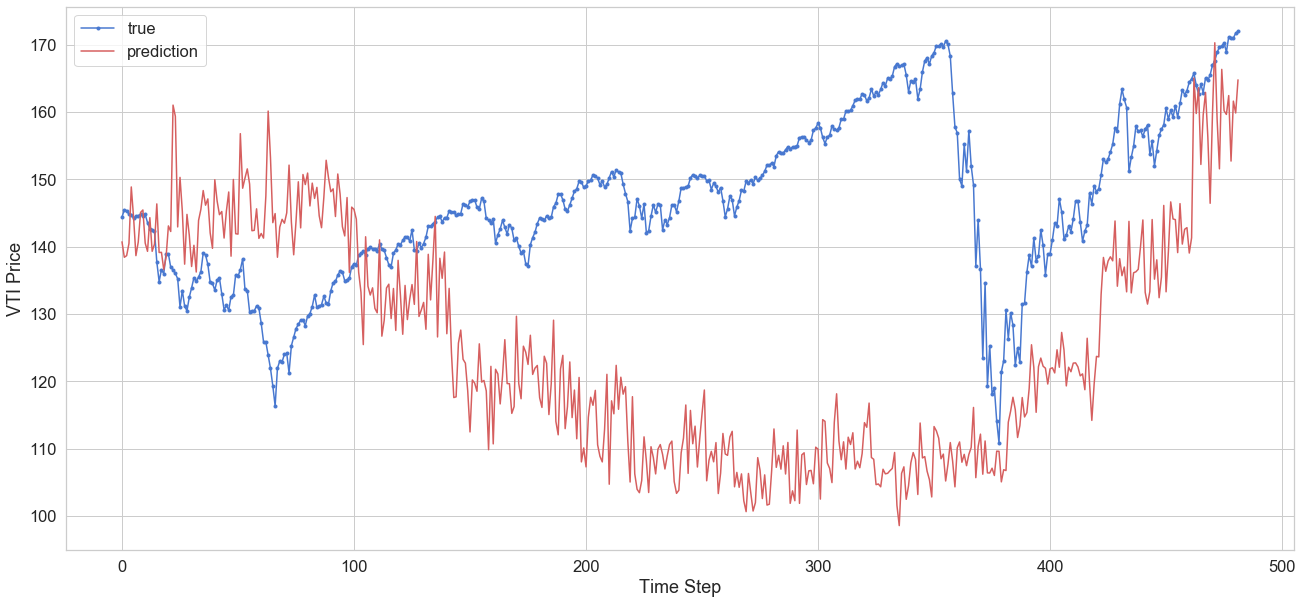

In [113]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(up_to_date_test, 'r', label="prediction")
plt.ylabel('VTI Price')
plt.xlabel('Time Step')
plt.legend()
plt.savefig('images/lstm_preds_vs_true.png')
plt.show();

In [114]:
print("RMSE = ", np.sqrt(mean_squared_error(y_test_inv.flatten(), up_to_date_test)))
print("MAE = ", mean_absolute_error(y_test_inv.flatten(), up_to_date_test))

RMSE =  31.129514196509078
MAE =  26.18857189384239


In [116]:
up_to_date_pred_outcomes = get_buy_sell(up_to_date_test)

In [117]:
confusion_matrix(y_test_outcomes, up_to_date_pred_outcomes)

array([[109, 102],
       [129, 141]])

#### Returns if I had started my trading strategy from the start of the tset period

In [121]:
calc_returns(up_to_date_pred_outcomes, y_test_inv.flatten(), 1000)

1361.8472540911478

#### Returns if I had bought at the beginning of the test period and just held

In [119]:
(1000/y_test_inv.flatten()[0])*y_test_inv.flatten()[-1]

1191.0929491619338